In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm


/Users/timhong/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
data = pd.read_excel("owid-covid-data.xlsx")
data.head()

iso_code continent     location        date  total_cases  new_cases  \
0      AFG      Asia  Afghanistan  2020-01-03          NaN        0.0   
1      AFG      Asia  Afghanistan  2020-01-04          NaN        0.0   
2      AFG      Asia  Afghanistan  2020-01-05          NaN        0.0   
3      AFG      Asia  Afghanistan  2020-01-06          NaN        0.0   
4      AFG      Asia  Afghanistan  2020-01-07          NaN        0.0   

   new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
0                 NaN           NaN         0.0                  NaN  ...   
1                 NaN           NaN         0.0                  NaN  ...   
2                 NaN           NaN         0.0                  NaN  ...   
3                 NaN           NaN         0.0                  NaN  ...   
4                 NaN           NaN         0.0                  NaN  ...   

   male_smokers  handwashing_facilities  hospital_beds_per_thousand  \
0           NaN                  37.746                         0.5   
1           NaN                  37.746                         0.5   
2           NaN                  37.746                         0.5   
3           NaN                  37.746                         0.5   
4           NaN                  37.746                         0.5   

   life_expectancy  human_development_index  population  \
0            64.83                    0.511    41128772   
1            64.83                    0.511    41128772   
2            64.83                    0.511    41128772   
3            64.83                    0.511    41128772   
4            64.83                    0.511    41128772   

   excess_mortality_cumulative_absolute  excess_mortality_cumulative  \
0                                   NaN                          NaN   
1                                   NaN                          NaN   
2                                   NaN                          NaN   
3                                   NaN                          NaN   
4                                   NaN                          NaN   

   excess_mortality  excess_mortality_cumulative_per_million  
0               NaN                                      NaN  
1               NaN                                      NaN  
2               NaN                                      NaN  
3               NaN                                      NaN  
4               NaN                                      NaN  

[5 rows x 67 columns]

In [4]:
country_list = [
    'Belgium', 'Denmark', 'Finland', 'Ireland', 'Italy',
    'Lithuania', 'Norway', 'Poland', 'Switzerland', 'United Kingdom'
]

selected_data = data[data['location'].isin(country_list)]
selected_data.head()

iso_code continent location        date  total_cases  new_cases  \
28497      BEL    Europe  Belgium  2020-01-03          NaN        0.0   
28498      BEL    Europe  Belgium  2020-01-04          NaN        0.0   
28499      BEL    Europe  Belgium  2020-01-05          NaN        0.0   
28500      BEL    Europe  Belgium  2020-01-06          NaN        0.0   
28501      BEL    Europe  Belgium  2020-01-07          NaN        0.0   

       new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
28497                 NaN           NaN         0.0                  NaN  ...   
28498                 NaN           NaN         0.0                  NaN  ...   
28499                 NaN           NaN         0.0                  NaN  ...   
28500                 NaN           NaN         0.0                  NaN  ...   
28501                 NaN           NaN         0.0                  NaN  ...   

       male_smokers  handwashing_facilities  hospital_beds_per_thousand  \
28497          31.4                     NaN                        5.64   
28498          31.4                     NaN                        5.64   
28499          31.4                     NaN                        5.64   
28500          31.4                     NaN                        5.64   
28501          31.4                     NaN                        5.64   

       life_expectancy  human_development_index  population  \
28497            81.63                    0.931    11655923   
28498            81.63                    0.931    11655923   
28499            81.63                    0.931    11655923   
28500            81.63                    0.931    11655923   
28501            81.63                    0.931    11655923   

       excess_mortality_cumulative_absolute  excess_mortality_cumulative  \
28497                                   NaN                          NaN   
28498                                   NaN                          NaN   
28499                                -151.3                        -6.34   
28500                                   NaN                          NaN   
28501                                   NaN                          NaN   

       excess_mortality  excess_mortality_cumulative_per_million  
28497               NaN                                      NaN  
28498               NaN                                      NaN  
28499             -6.34                               -13.086293  
28500               NaN                                      NaN  
28501               NaN                                      NaN  

[5 rows x 67 columns]

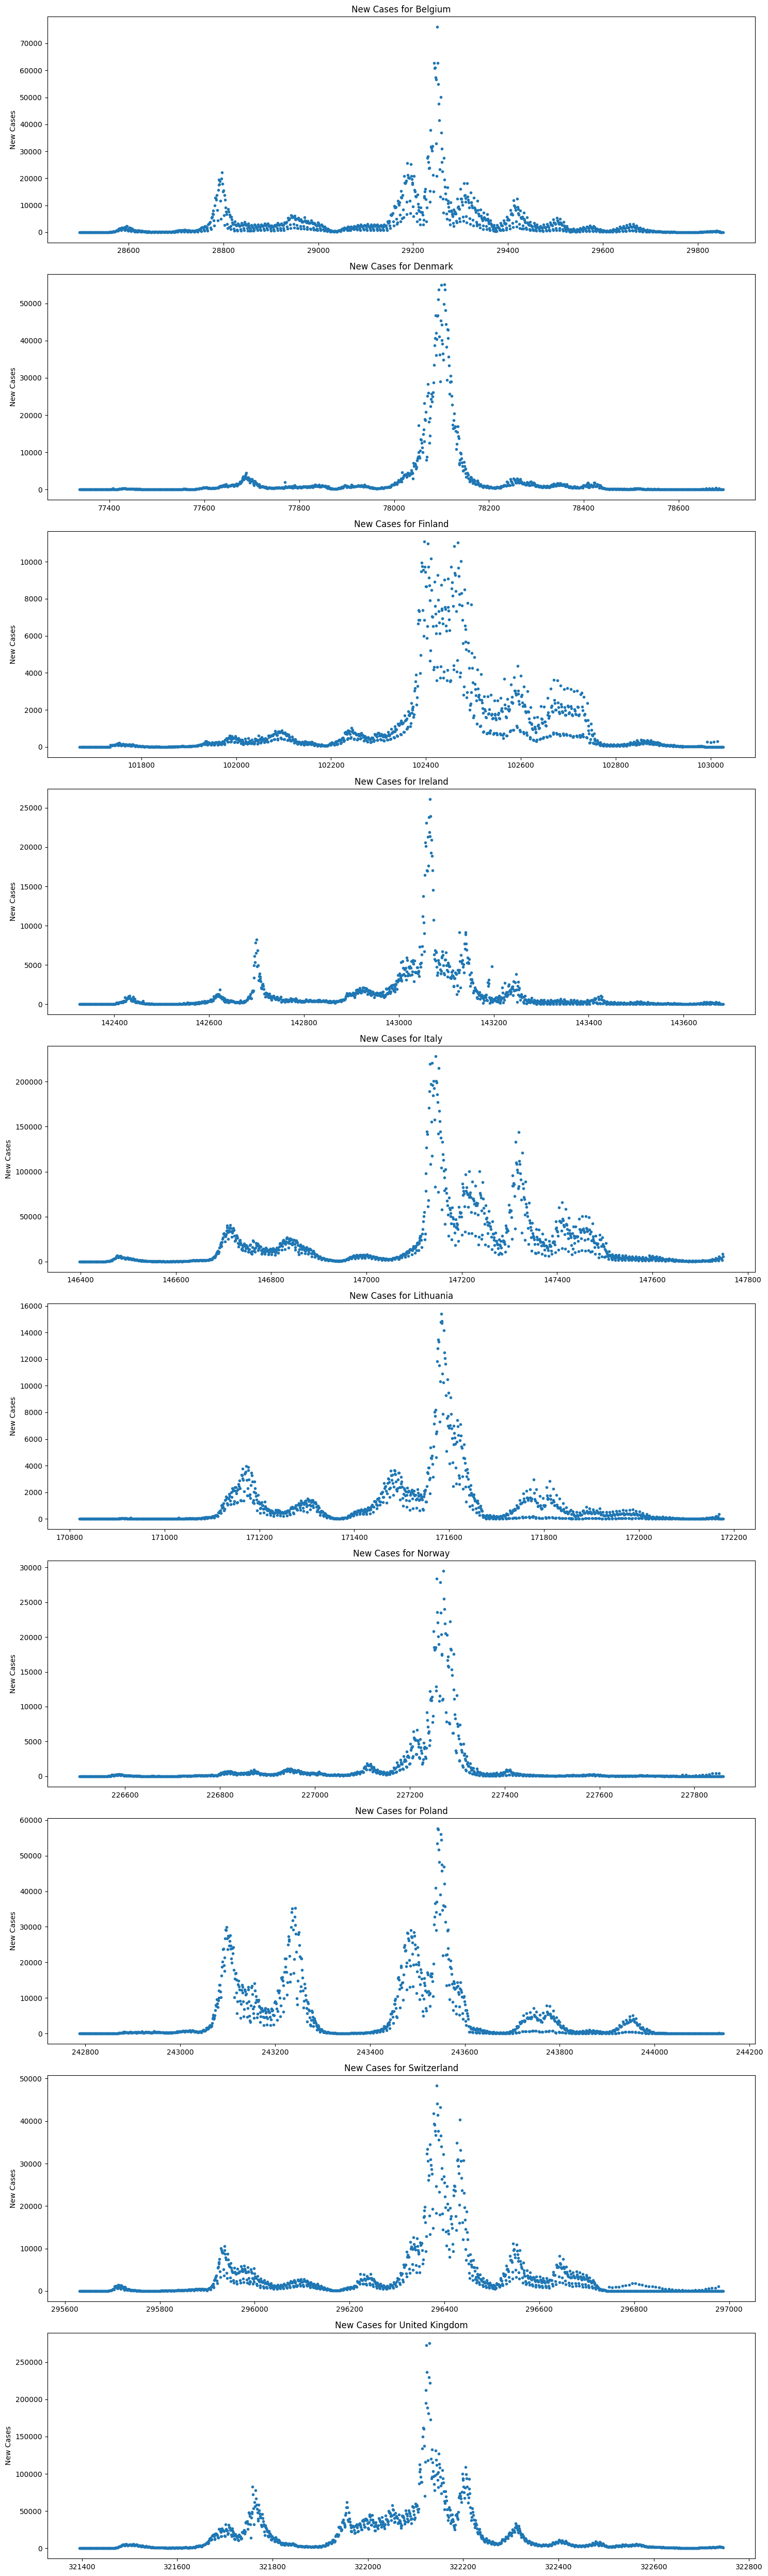

In [5]:
locations = selected_data['location'].unique()
plt.figure(figsize=(15, 5 * len(locations)))

for i, location in enumerate(locations, 1):
    plt.subplot(len(locations), 1, i)
    selected_data[selected_data['location'] == location]['new_cases'].plot(style='.', title=f'New Cases for {location}')
    plt.ylabel('New Cases')

plt.tight_layout()
plt.show()

Seems like we should isolate the parts of the data that matter - beginning and end dates contain a bunch of 0s.

## Data Cleaning

### Removing irrelevant variables

In [6]:
data_clean = selected_data[["location", "date", "new_cases"]]
data_clean.head()

location        date  new_cases
28497  Belgium  2020-01-03        0.0
28498  Belgium  2020-01-04        0.0
28499  Belgium  2020-01-05        0.0
28500  Belgium  2020-01-06        0.0
28501  Belgium  2020-01-07        0.0

### Removing irrelevant dates


In [7]:
### Find first month where majority of new_cases_smoothed isn't NaN/0 
# Convert 'ds' to datetime if it's not already
data_clean['date'] = pd.to_datetime(data_clean['date'])

# 2020 - first month
df_2020 = data_clean[data_clean['date'].dt.year == 2020]

# Count the number of days with new_cases not 0 or NA for each month
monthly_counts_2020 = df_2020[(df_2020['new_cases'] != 0) | 
                              df_2020['new_cases'].isna()].groupby(df_2020['date'].dt.to_period('M')).size()



# 2023 - last month
df_2023 = data_clean[data_clean['date'].dt.year == 2023]

# Count the number of days with new_cases not 0 or NA for each month
monthly_counts_2023 = df_2023[(df_2023['new_cases'] != 0) | 
                              df_2023['new_cases'].isna()].groupby(df_2023['date'].dt.to_period('M')).size()


/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_22180/873090102.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['date'] = pd.to_datetime(data_clean['date'])


In [8]:
monthly_counts_2020

date
2020-01      4
2020-02     40
2020-03    276
2020-04    300
2020-05    309
2020-06    296
2020-07    310
2020-08    310
2020-09    300
2020-10    310
2020-11    300
2020-12    310
Freq: M, dtype: int64

In [9]:
monthly_counts_2023

date
2023-01    297
2023-02    253
2023-03    279
2023-04    267
2023-05    279
2023-06    249
2023-07    223
2023-08    209
2023-09     95
Freq: M, dtype: int64

Our selected_data tracks 10 countries, so there should be ~10 observations a day for the ~30 a month totalling to 300-310 observations that should be tracked per month. 

Looking at 2020, 2020-03 is the first month where there are over 90% non-zero, non-missing observations.
Looking at 2023, 2023-06 is the last month where there are over 90% non-zero, non-missing observations. 

Thus, I'm first going to subset my data to go from 2020-03-01 to 2023-01-15.

In [10]:
# Subset the dataset
data_clean_subset = data_clean[(data_clean['date'] >= '2020-03-01') & (data_clean['date'] <= '2023-01-15')]

In [11]:
# check missingness
missing_values_count = data_clean_subset['new_cases'].isnull().sum()
print(missing_values_count)

0


No NA values - good


### Removing Outliers


/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_22180/2601954221.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  outliers_df = pd.concat([outliers_df, outliers_location])


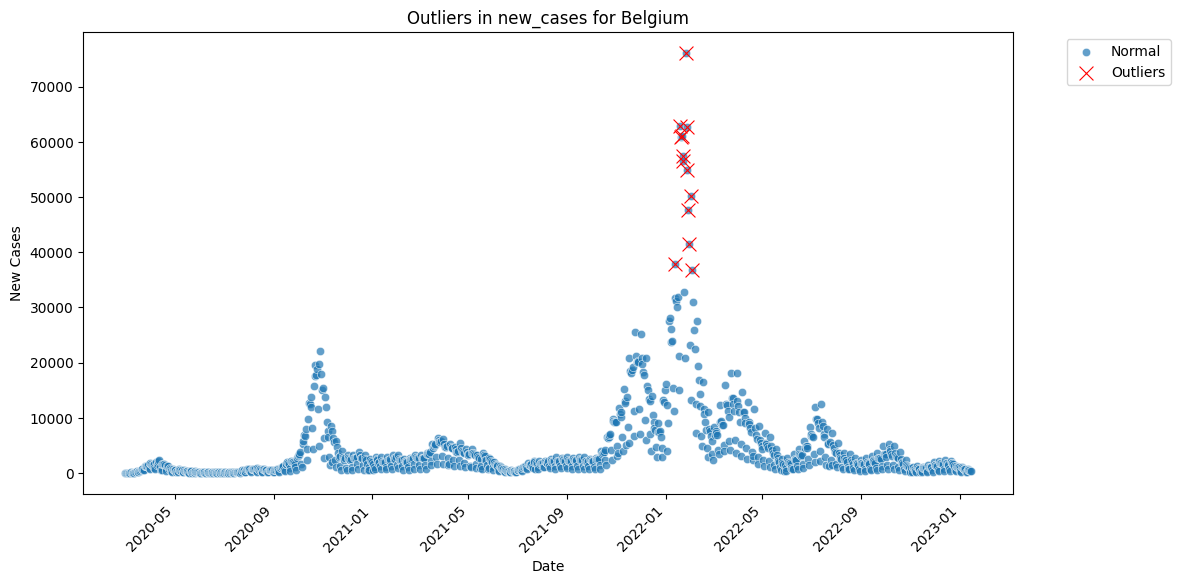

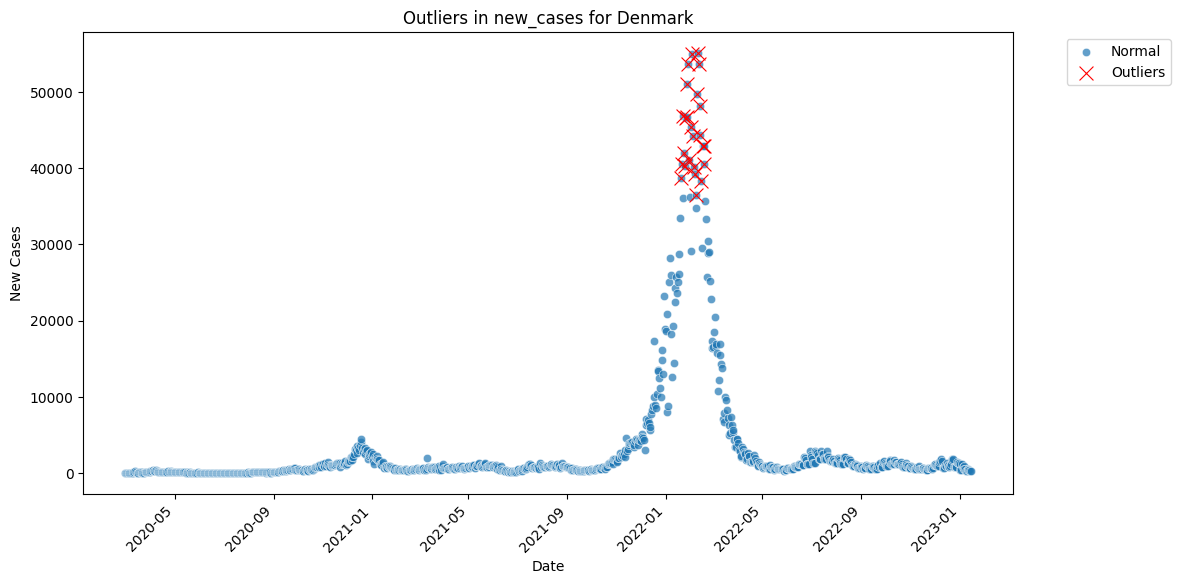

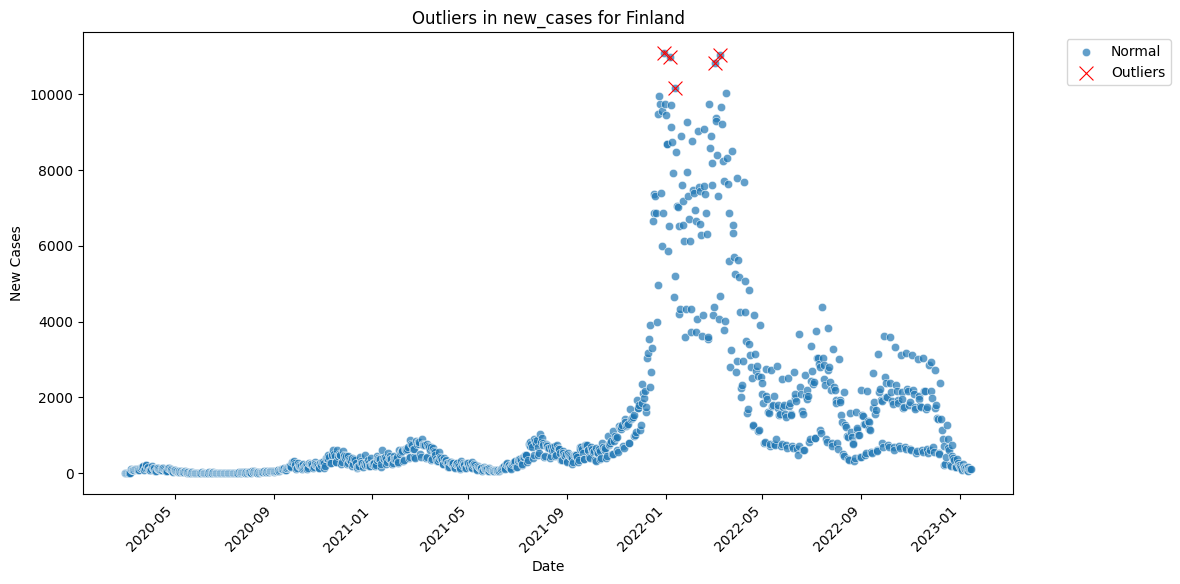

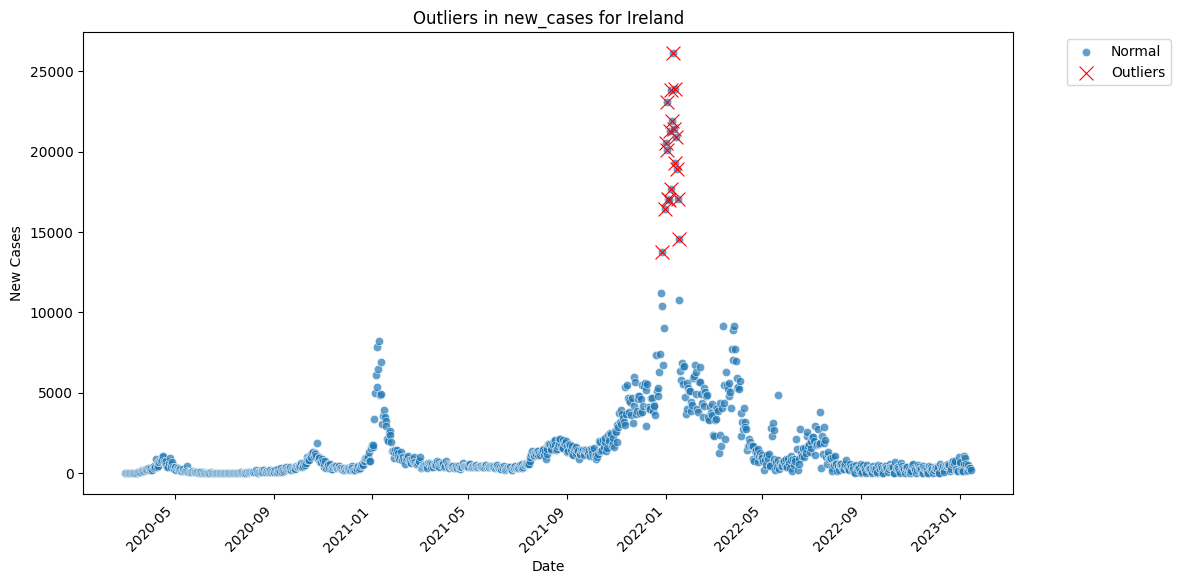

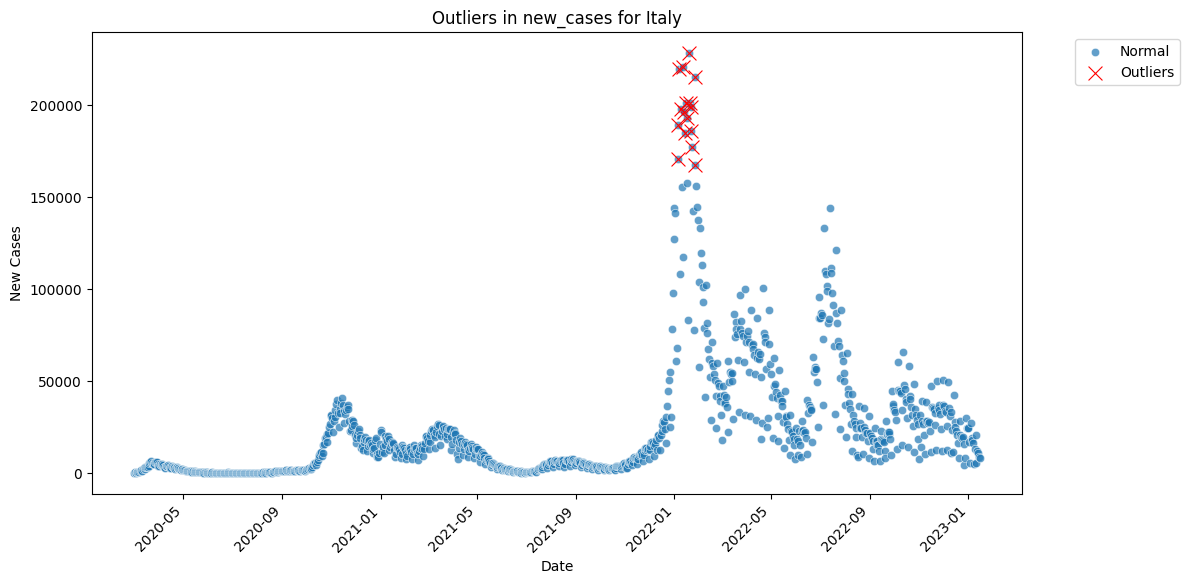

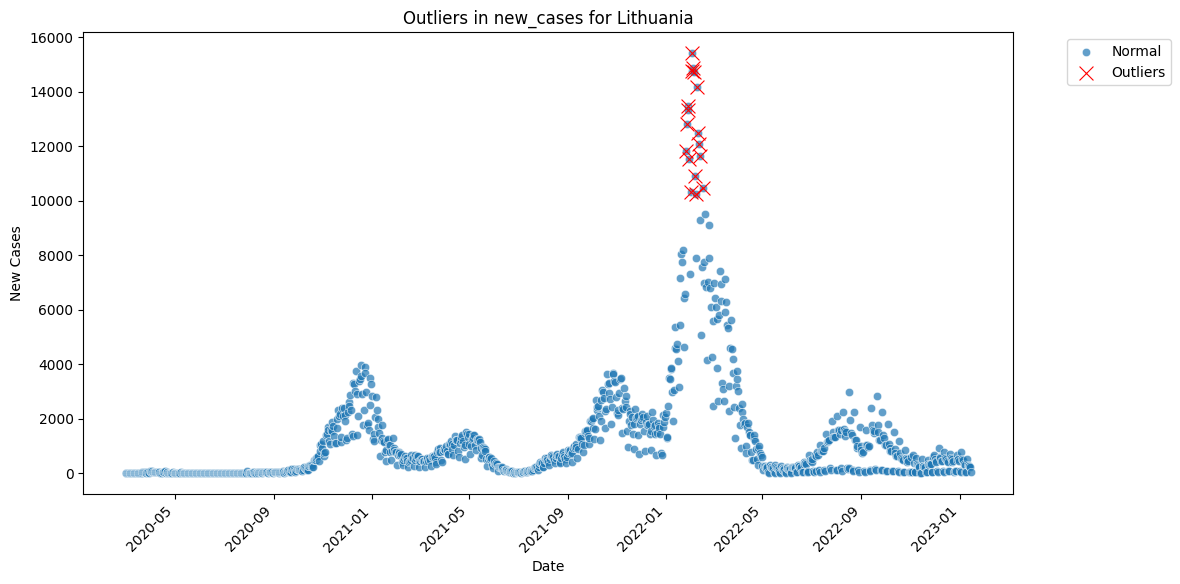

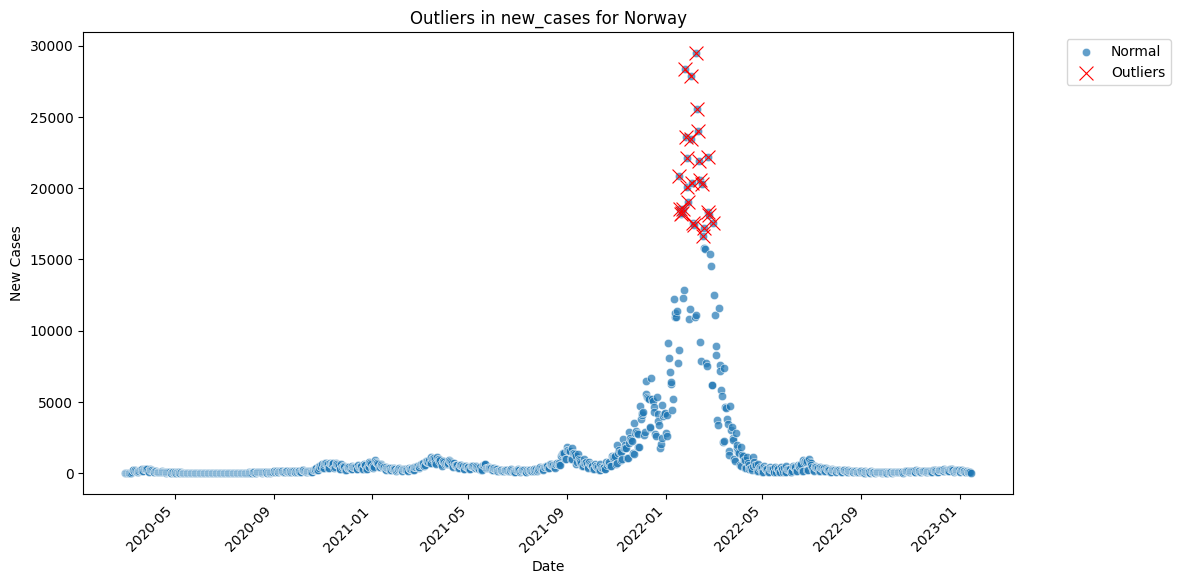

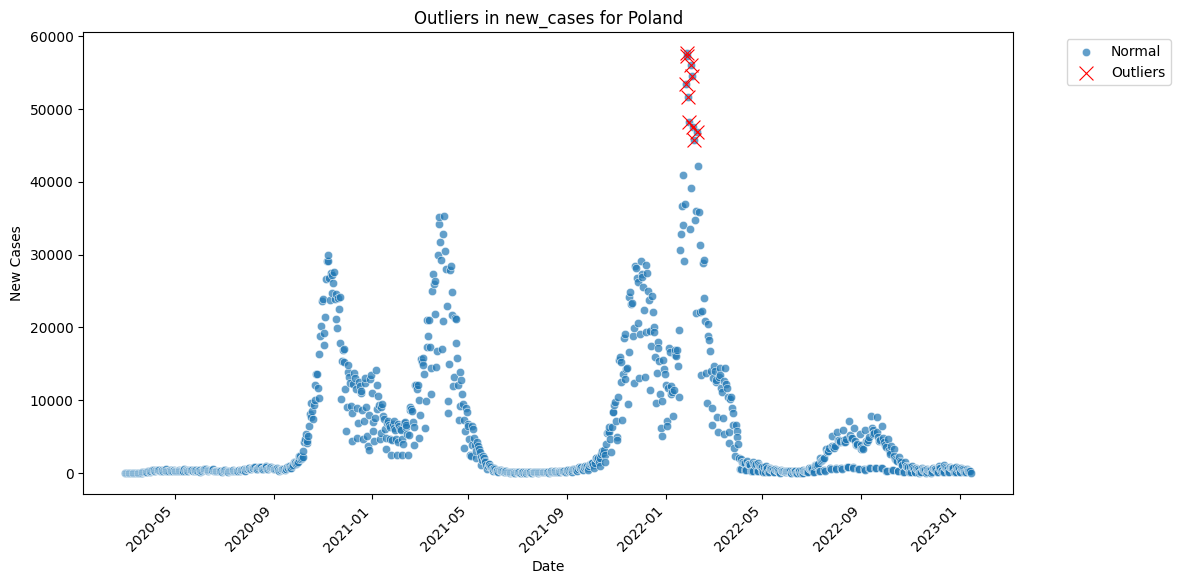

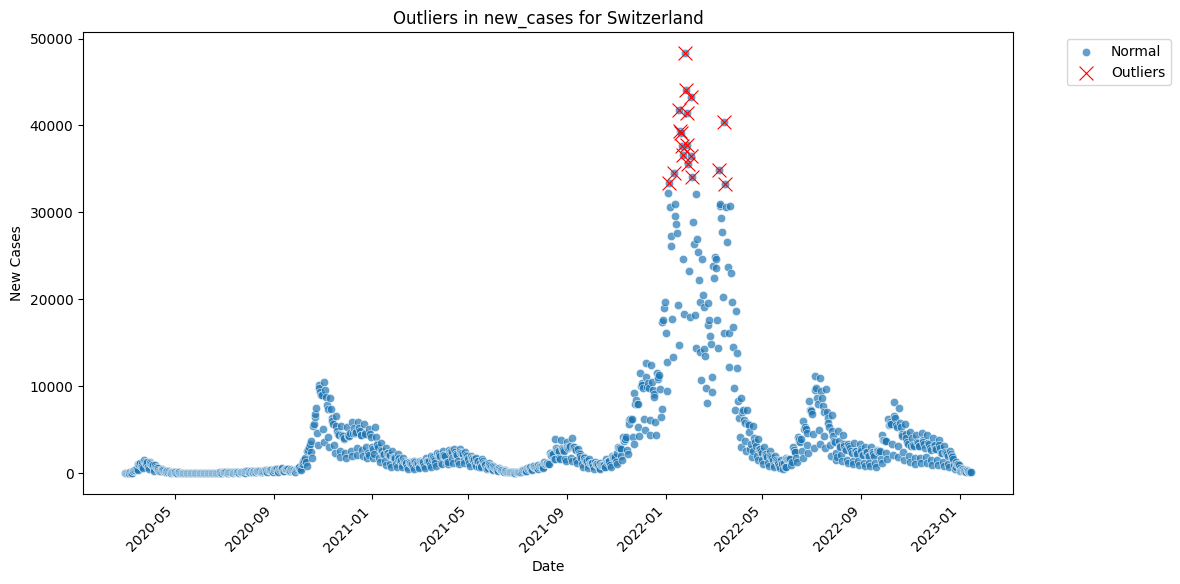

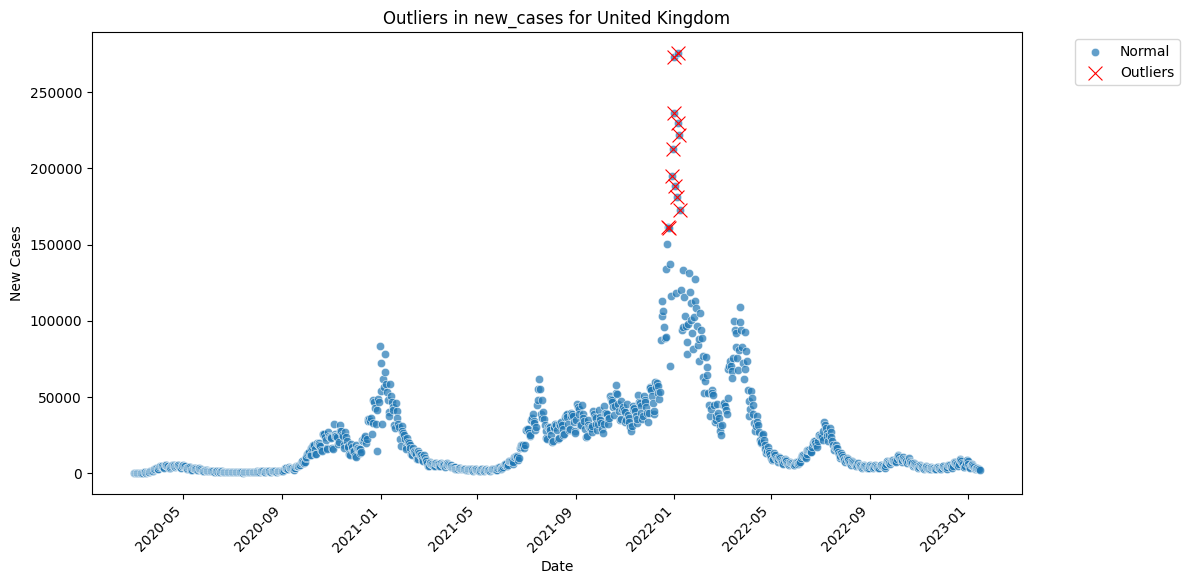

In [12]:
from scipy import stats

# Function to identify outliers using z-score
def detect_outliers_zscore(data):
    z_scores = stats.zscore(data)
    return (abs(z_scores) > 4)

# Identify outliers for each location
outliers_df = pd.DataFrame(columns=data_clean_subset.columns)
for location, group in data_clean_subset.groupby('location'):
    outliers_location = group[detect_outliers_zscore(group['new_cases'])]
    outliers_df = pd.concat([outliers_df, outliers_location])

# Plot each location's points with outliers highlighted in separate plots
for location, group in data_clean_subset.groupby('location'):
    outliers_location = group[detect_outliers_zscore(group['new_cases'])]

    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='date', y='new_cases', data=group, alpha=0.7, label='Normal')
    sns.scatterplot(x='date', y='new_cases', data=outliers_location, marker='x', s=100, color='red', label='Outliers')
    plt.title(f'Outliers in new_cases for {location}')
    plt.xlabel('Date')
    plt.ylabel('New Cases')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45, ha='right')
    plt.show()

In [13]:

def replace_outliers_with_ffill(data):
    z_scores = stats.zscore(data['new_cases'])
    data['new_cases'] = np.where(np.abs(z_scores) > 4, np.nan, data['new_cases'])
    data['new_cases'] = data['new_cases'].ffill()
    return data

# Apply the function for each location
cleaned_df = data_clean_subset.groupby('location').apply(replace_outliers_with_ffill)

# Reset the index if needed
cleaned_df = cleaned_df.reset_index(drop=True)

# Display the cleaned DataFrame with outliers replaced by ffill
print(cleaned_df)


             location       date  new_cases
0             Belgium 2020-03-01        0.0
1             Belgium 2020-03-02        0.0
2             Belgium 2020-03-03       18.0
3             Belgium 2020-03-04       19.0
4             Belgium 2020-03-05       34.0
...               ...        ...        ...
10505  United Kingdom 2023-01-11     3606.0
10506  United Kingdom 2023-01-12     3117.0
10507  United Kingdom 2023-01-13     2644.0
10508  United Kingdom 2023-01-14     2480.0
10509  United Kingdom 2023-01-15     2129.0

[10510 rows x 3 columns]


## Time Series Decomposition

<Figure size 1000x600 with 0 Axes>

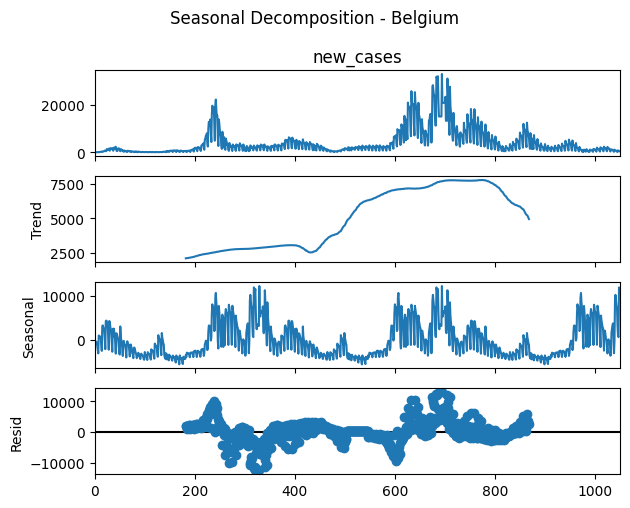

<Figure size 1000x600 with 0 Axes>

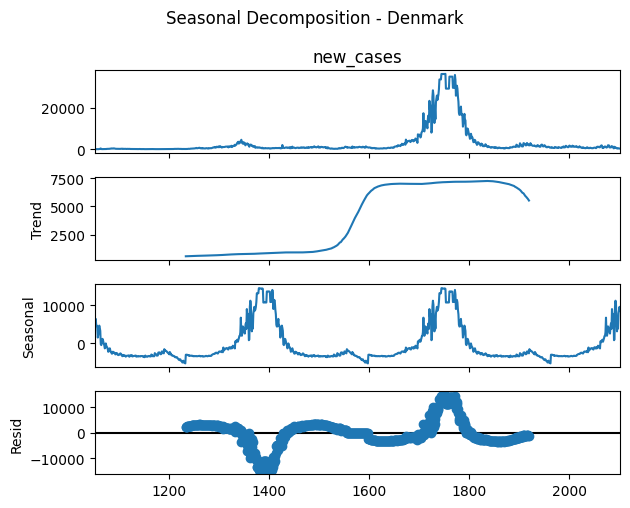

<Figure size 1000x600 with 0 Axes>

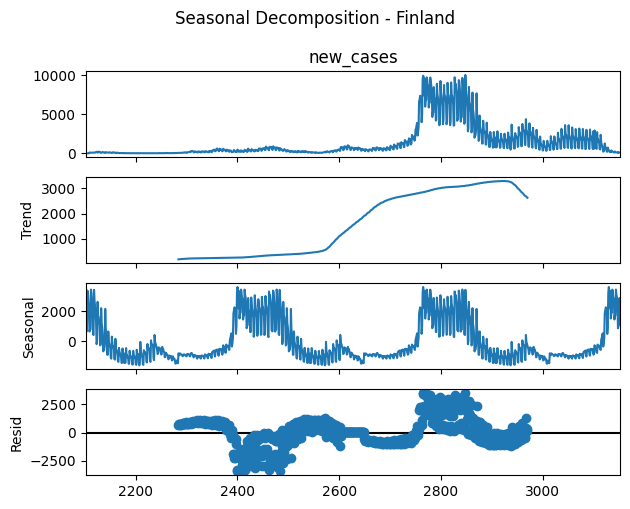

<Figure size 1000x600 with 0 Axes>

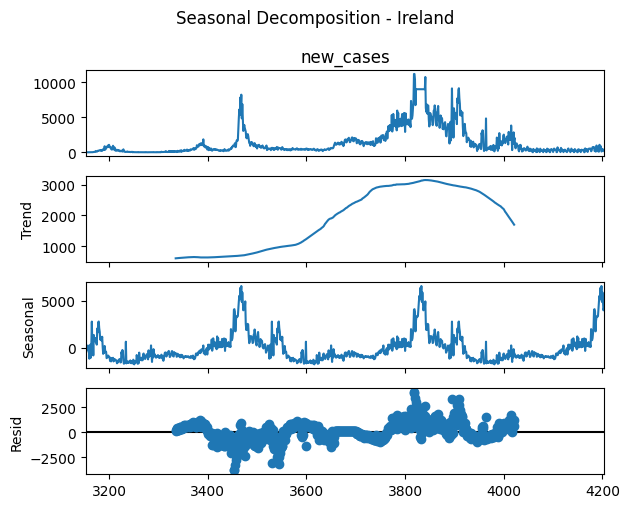

<Figure size 1000x600 with 0 Axes>

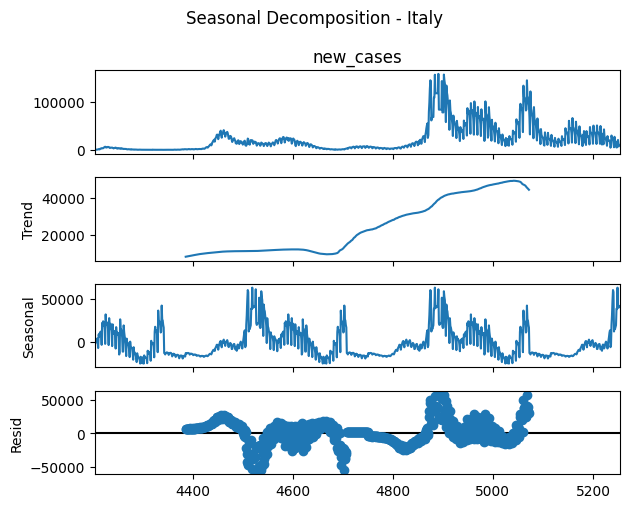

<Figure size 1000x600 with 0 Axes>

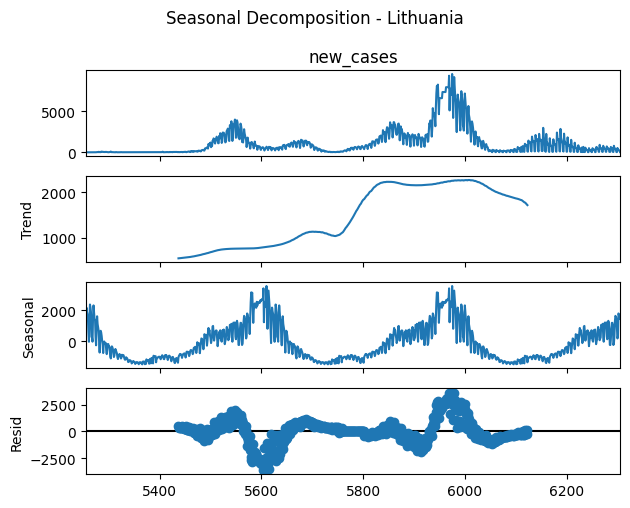

<Figure size 1000x600 with 0 Axes>

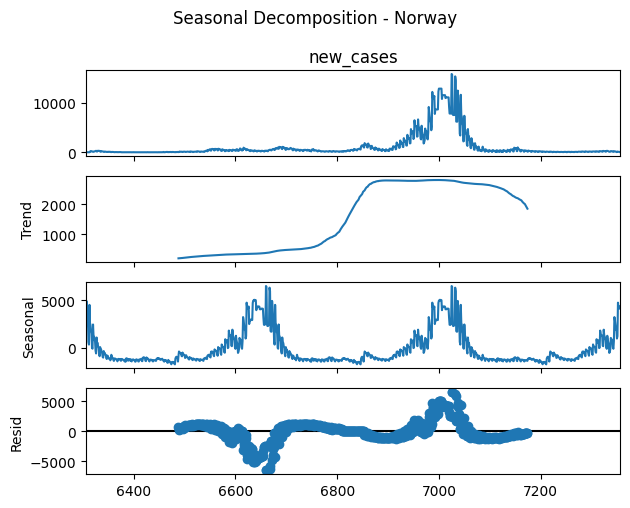

<Figure size 1000x600 with 0 Axes>

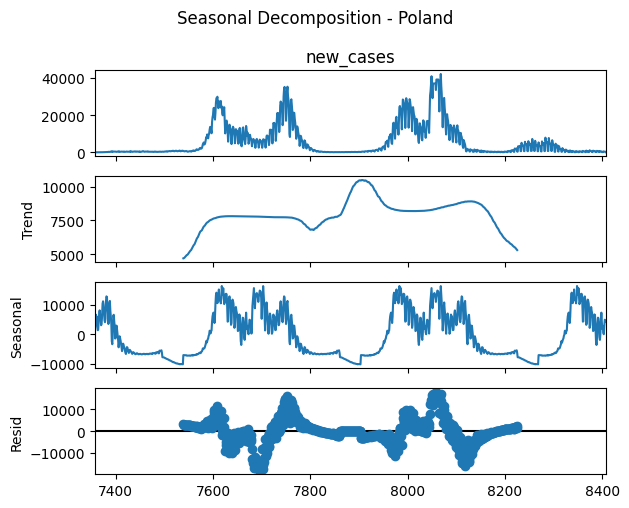

<Figure size 1000x600 with 0 Axes>

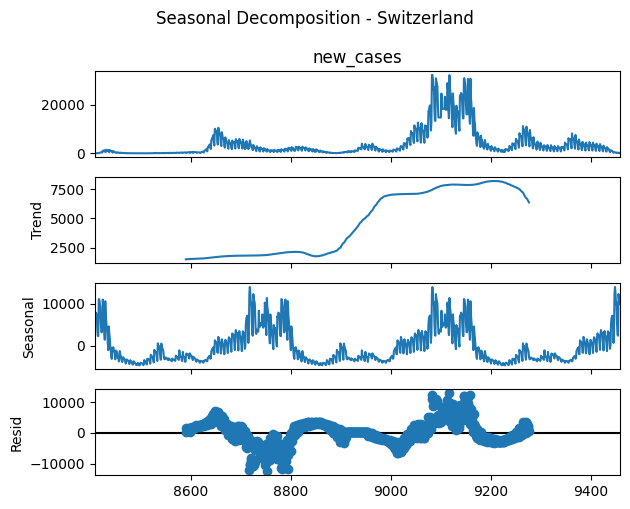

<Figure size 1000x600 with 0 Axes>

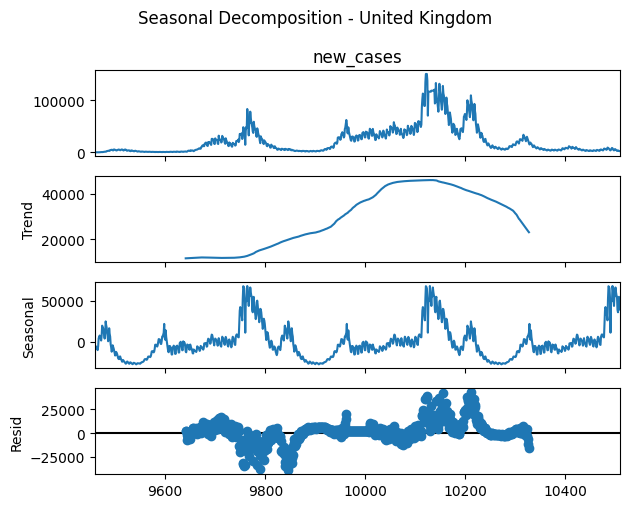

In [14]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose


for country in cleaned_df['location'].unique():
    country_data = cleaned_df[cleaned_df['location'] == country]
    result = seasonal_decompose(country_data['new_cases'], period=365)
    
    plt.figure(figsize=(10, 6))
    
    # Create plots
    result.plot()
    
    # Set the title with a higher y value to shift it up
    plt.suptitle(f'Seasonal Decomposition - {country}', y=1.05)
    
    # Display the figure
    plt.show()



### Testing for Stationarity

In [15]:
from statsmodels.tsa.stattools import adfuller

for country in cleaned_df['location'].unique():
    country_data = cleaned_df[cleaned_df['location'] == country]
    result = adfuller(country_data['new_cases'].values)
    
    print(f'Results for {country}:')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('---------------------------------------------')


Results for Belgium:
ADF Statistic: -2.850488
p-value: 0.051416
---------------------------------------------
Results for Denmark:
ADF Statistic: -2.852006
p-value: 0.051220
---------------------------------------------
Results for Finland:
ADF Statistic: -2.323164
p-value: 0.164606
---------------------------------------------
Results for Ireland:
ADF Statistic: -2.623999
p-value: 0.088138
---------------------------------------------
Results for Italy:
ADF Statistic: -3.692595
p-value: 0.004219
---------------------------------------------
Results for Lithuania:
ADF Statistic: -3.463515
p-value: 0.008975
---------------------------------------------
Results for Norway:
ADF Statistic: -2.743529
p-value: 0.066804
---------------------------------------------
Results for Poland:
ADF Statistic: -3.835590
p-value: 0.002563
---------------------------------------------
Results for Switzerland:
ADF Statistic: -1.811912
p-value: 0.374564
---------------------------------------------
Results 

Stationary (p-value < 0.05): Ireland, Italy, Lithuania, Poland, United Kingdom

Non-Stationary (p-value > 0.05): Belgium, Denmark, Finland, Norway, Switzerland

### Splitting into Stationary and Non-Stationary Sets

In [16]:
# setting locations
stationary_locations = ['Ireland', 'Italy', 'Lithuania', 'Poland', 'United Kingdom']
non_stationary_locations = ['Belgium', 'Denmark', 'Finland', 'Norway', 'Switzerland']


# creating df
stationary_df = cleaned_df[cleaned_df['location'].isin(stationary_locations)]
non_stationary_df = cleaned_df[cleaned_df['location'].isin(non_stationary_locations)]


### Differencing Non-Stationary Data

In [17]:
missing_values_count = non_stationary_df['new_cases'].isnull().sum()
print(missing_values_count)



0


#### First Order

In [18]:
# Define a list of unique locations
locations = non_stationary_df['location'].unique()

# Create an empty DataFrame to store the differenced data
differenced_df = pd.DataFrame()

# Loop through each location and apply first-order differencing
for location in locations:
    # Extract data for the current location
    subset = non_stationary_df[non_stationary_df['location'] == location].copy()

    # Apply first-order differencing to the target variable
    subset['new_cases_diff'] = subset['new_cases'].diff(1)

    # Append the differenced data to the new DataFrame
    differenced_df = pd.concat([differenced_df, subset])

differenced_df = differenced_df.fillna(0)

In [19]:
for country in differenced_df['location'].unique():
    country_data = differenced_df[differenced_df['location'] == country]
    result = adfuller(country_data['new_cases_diff'].values)
    
    print(f'Results for {country}:')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('---------------------------------------------')

Results for Belgium:
ADF Statistic: -8.463496
p-value: 0.000000
---------------------------------------------
Results for Denmark:
ADF Statistic: -4.512879
p-value: 0.000186
---------------------------------------------
Results for Finland:
ADF Statistic: -5.555376
p-value: 0.000002
---------------------------------------------
Results for Norway:
ADF Statistic: -5.495728
p-value: 0.000002
---------------------------------------------
Results for Switzerland:
ADF Statistic: -10.173764
p-value: 0.000000
---------------------------------------------


## Grid Search for Optimal Parameters

In [ ]:
## setting date as index across
stationary_df.set_index('date', inplace=True)
differenced_df.set_index('date', inplace=True)

### Stationary DF

In [ ]:
# import pandas as pd
# from statsmodels.tsa.arima.model import ARIMA
# from sklearn.metrics import mean_squared_error
# from math import sqrt
# from itertools import product
# from tqdm import tqdm

# # Assuming stationary_df is already loaded with the required columns

# # Define a function to calculate RMSE for a given ARIMA order
# def calculate_rmse(data, order):
#     split = int(len(data) * 0.98667935)  
#     train, test = data[:split], data[split:]
    
#     history = list(train)
#     predictions = []
    
#     for t in range(len(test)):
#         model = ARIMA(history, order=order)
#         results = model.fit()
#         yhat = results.forecast()[0]
#         predictions.append(yhat)
#         history.append(test[t])
    
#     rmse = sqrt(mean_squared_error(test, predictions))
#     return rmse

# # Define a function to perform grid search using RMSE
# def grid_search_arima(data, location):
#     location_data = data[data['location'] == location]['new_cases']
    
#     p_values = range(0, 3)
#     d_values = range(0, 1)
#     q_values = range(0, 3)
    
#     orders = list(product(p_values, d_values, q_values))
    
#     best_rmse = float('inf')
#     best_order = None
    
#     for order in tqdm(orders, desc=f'Grid search for {location}'):
#         try:
#             rmse = calculate_rmse(location_data, order)
            
#             if rmse < best_rmse:
#                 best_rmse = rmse
#                 best_order = order
#         except:
#             continue
    
#     print(f"Best ARIMA Order for {location}: {best_order} RMSE: {best_rmse}")

# # Iterate over unique locations in your dataset and perform grid search
# unique_locations = stationary_df['location'].unique()
# for location in unique_locations:
#     grid_search_arima(stationary_df, location)


### Differenced DF

In [23]:
# import pandas as pd
# import numpy as np
# from pmdarima import auto_arima
# from sklearn.metrics import mean_squared_error
# from itertools import product

# # Function for grid search
# def grid_search(data, p_values, d_values, q_values):
#     best_score, best_cfg = float("inf"), None

#     for p, d, q in product(p_values, d_values, q_values):
#         order = (p, d, q)
#         try:
#             model = auto_arima(data, order=order, suppress_warnings=True, seasonal=True, stepwise=True)
#             mse = mean_squared_error(data, model.predict_in_sample())
#             if mse < best_score:
#                 best_score, best_cfg = mse, order
#         except:
#             continue

#     return best_cfg

# # Define the range of p, d, q values to search
# p_values = range(0, 4)
# d_values = range(0, 1)
# q_values = range(0, 4)

# # Iterate over unique locations
# for location in differenced_df['location'].unique():
#     # Filter DataFrame for the current location
#     location_df = differenced_df[differenced_df['location'] == location]

#     # Extract the target variable
#     y = location_df['new_cases_diff']

#     # Perform grid search
#     best_order = grid_search(y, p_values, d_values, q_values)

#     # Display the results
#     print(f"Location: {location}")
#     print(f"Best (p, d, q) values: {best_order}")
#     print("-----")

Location: Belgium
Best (p, d, q) values: (0, 0, 0)
-----
Location: Denmark
Best (p, d, q) values: (0, 0, 0)
-----
Location: Finland
Best (p, d, q) values: (0, 0, 0)
-----
Location: Norway
Best (p, d, q) values: (0, 0, 0)
-----
Location: Switzerland
Best (p, d, q) values: (0, 0, 0)
-----


In [55]:
import statsmodels.api as sm
import pandas as pd
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

belgium_df = differenced_df[differenced_df['location'] == 'Belgium']

# Function to evaluate ARIMA model
def evaluate_arima_model(data, arima_order):
    # prepare training dataset
    train_size = int(len(data) * 0.98667935)
    train, test = data[0:train_size], data[train_size:]
    history = [x for x in train]
    
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    
    # calculate out-of-sample error
    error = mean_squared_error(test, predictions)
    return error

# Function to perform grid search for optimal p, d, and q values
def grid_search(data, p_values, d_values, q_values):
    data = data.astype('float32')
    best_score, best_cfg = float("inf"), None
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    mse = evaluate_arima_model(data, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order, mse))
                except:
                    continue

    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

# Extract the target variable
target_variable = belgium_df['new_cases_diff']

# Define the range of p, d, q values to search
p_values = range(0, 4)
d_values = range(0, 1)
q_values = range(0, 4)

# Perform grid search for the specified DataFrame
grid_search(target_variable, p_values, d_values, q_values)

/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_22180/2377423144.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])


ARIMA(0, 0, 0) MSE=11125659.540


/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_22180/2377423144.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])


ARIMA(0, 0, 1) MSE=8561893.445


/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_22180/2377423144.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])


ARIMA(0, 0, 2) MSE=8367730.334


/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_22180/2377423144.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])


ARIMA(1, 0, 0) MSE=10401529.593


/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_22180/2377423144.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])


ARIMA(1, 0, 1) MSE=8271930.738


/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_22180/2377423144.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 2) MSE=8485251.406


/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_22180/2377423144.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

ARIMA(1, 0, 3) MSE=8108305.911


/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_22180/2377423144.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])


ARIMA(2, 0, 0) MSE=9825739.962


/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_22180/2377423144.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])


ARIMA(2, 0, 1) MSE=8162644.476


/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_22180/2377423144.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization 

ARIMA(2, 0, 3) MSE=7443388.461


/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_22180/2377423144.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])


ARIMA(3, 0, 0) MSE=9321792.659


/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_22180/2377423144.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(3, 0, 1) MSE=8120046.381


/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_22180/2377423144.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])


ARIMA(3, 0, 2) MSE=7823025.807


/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_22180/2377423144.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check 

ARIMA(3, 0, 3) MSE=8034110.261
Best ARIMA(2, 0, 3) MSE=7443388.461


Using grid search to tune Belgium, a non-stationary country, gave me the best p d q of (2, 0, 3). I will use this p, d, q for all the non-stationary countries for this section.

### I. Stationary

1. Ireland

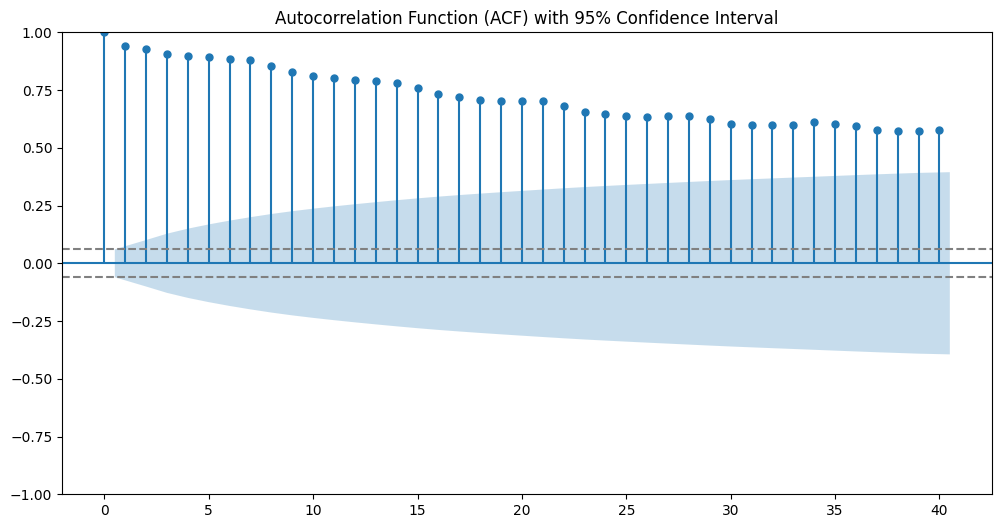

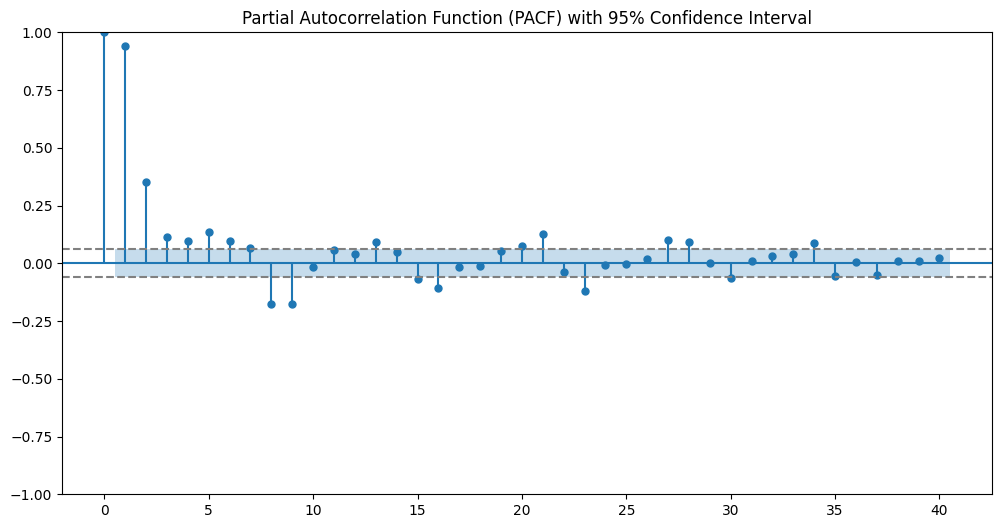

In [110]:
import statsmodels.api as sm
ireland_df = stationary_df[stationary_df['location'] == 'Ireland']

# Extract the relevant columns
target_variable = ireland_df['new_cases']

# Plot ACF with threshold lines
fig, ax = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_acf(target_variable, lags=40, ax=ax)
ax.axhline(y=1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
ax.axhline(y=-1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
plt.title('Autocorrelation Function (ACF) with 95% Confidence Interval')
plt.show()

# Plot PACF with threshold lines
fig, ax = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_pacf(target_variable, lags=40, ax=ax)
ax.axhline(y=1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
ax.axhline(y=-1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function (PACF) with 95% Confidence Interval')
plt.show()

/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Train RMSE: 628.3945605264543
Test RMSE: 397.16974231510613
Test sRMSE: 91.27541190020824


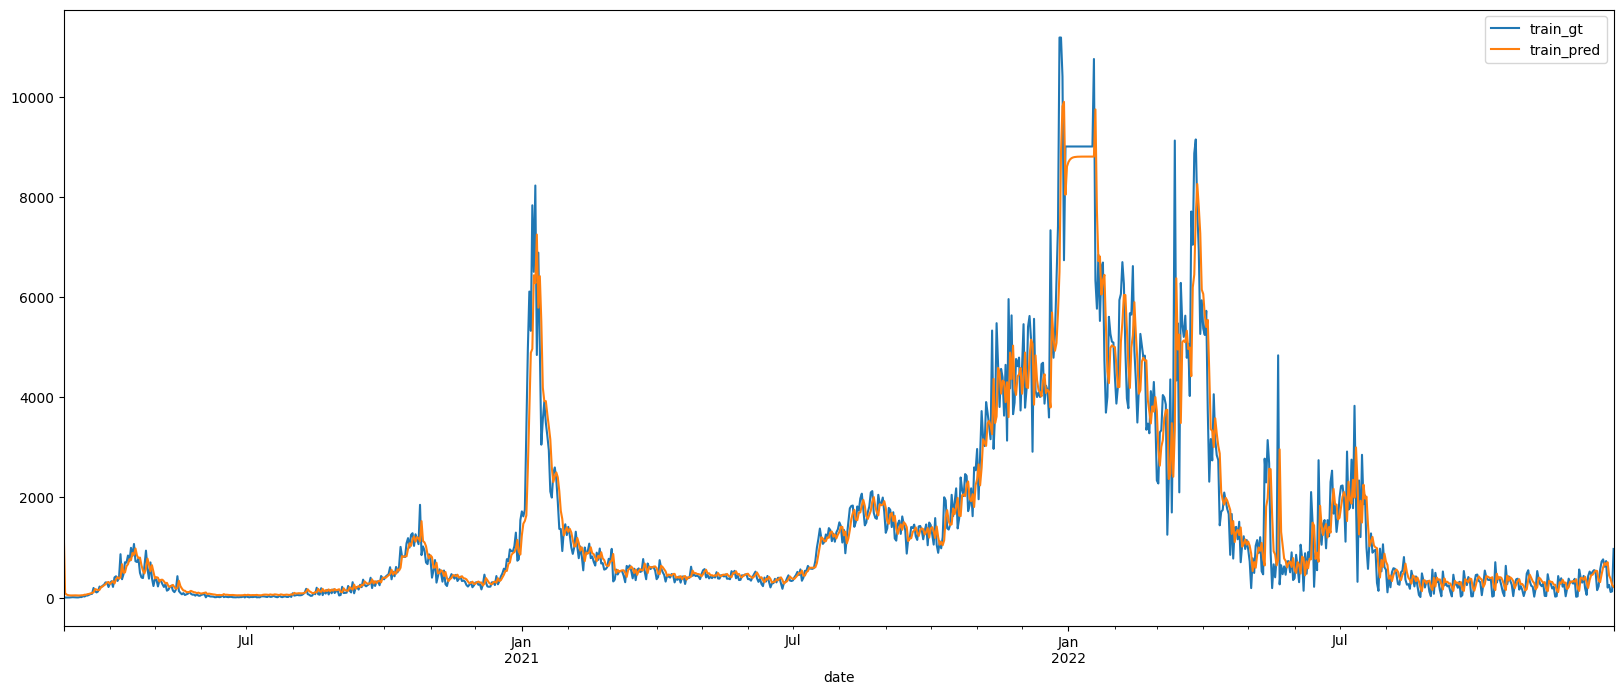

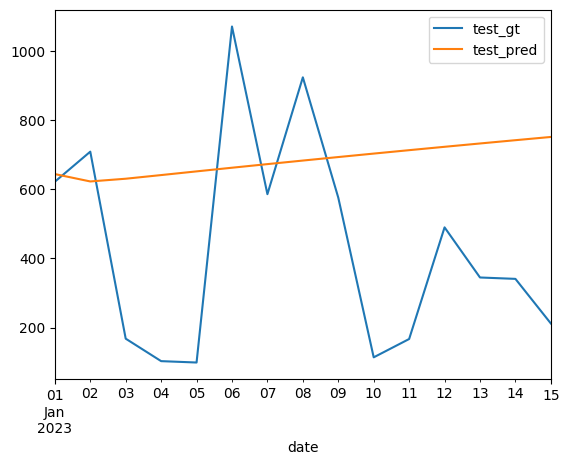

In [111]:
train_size = 0.98667935  
ireland_split = int(len(ireland_df) * train_size)
ireland_train = ireland_df.iloc[:ireland_split]
ireland_test = ireland_df.iloc[ireland_split:]

ireland_train = ireland_train.drop(columns = ['location'])
ireland_test = ireland_test.drop(columns = ['location'])

model = ARIMA(ireland_train, order=(2, 0, 1))
model = model.fit()
train_pred=model.fittedvalues
train_pred.index = ireland_train.index
pd.concat([ireland_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
test_pred = model.predict(start=len(ireland_train), end=len(ireland_train)+len(ireland_test)-1, dynamic=True)
test_pred.index = ireland_test.index
pd.concat([ireland_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
train_rmse = np.sqrt(mean_squared_error(ireland_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(ireland_test, test_pred))
test_srmse = test_rmse / np.mean(ireland_test) * 100

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Test sRMSE: {test_srmse}')

ireland_train_rmse = train_rmse
ireland_test_rmse = test_rmse
ireland_test_srmse = test_srmse

2. Italy

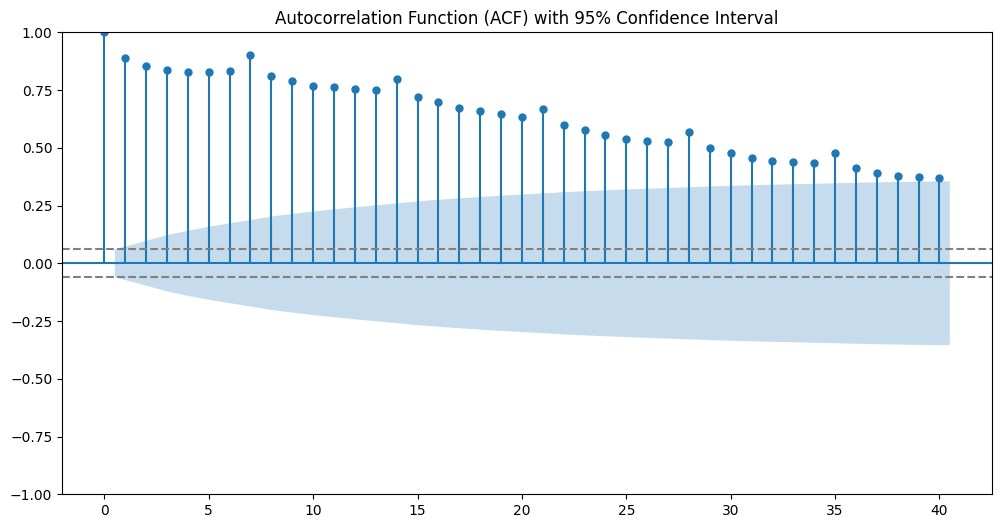

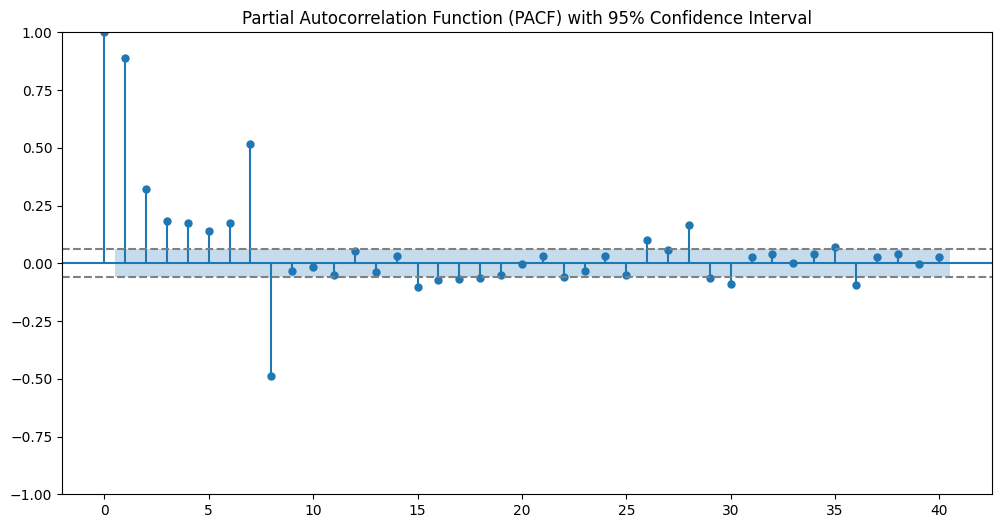

In [112]:
import statsmodels.api as sm
italy_df = stationary_df[stationary_df['location'] == 'Italy']

# Extract the relevant columns
target_variable = italy_df['new_cases']

# Plot ACF with threshold lines
fig, ax = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_acf(target_variable, lags=40, ax=ax)
ax.axhline(y=1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
ax.axhline(y=-1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
plt.title('Autocorrelation Function (ACF) with 95% Confidence Interval')
plt.show()

# Plot PACF with threshold lines
fig, ax = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_pacf(target_variable, lags=40, ax=ax)
ax.axhline(y=1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
ax.axhline(y=-1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function (PACF) with 95% Confidence Interval')
plt.show()

/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels

Train RMSE: 10792.857534997898
Test RMSE: 9753.826543687774
Test sRMSE: 68.8667442482074


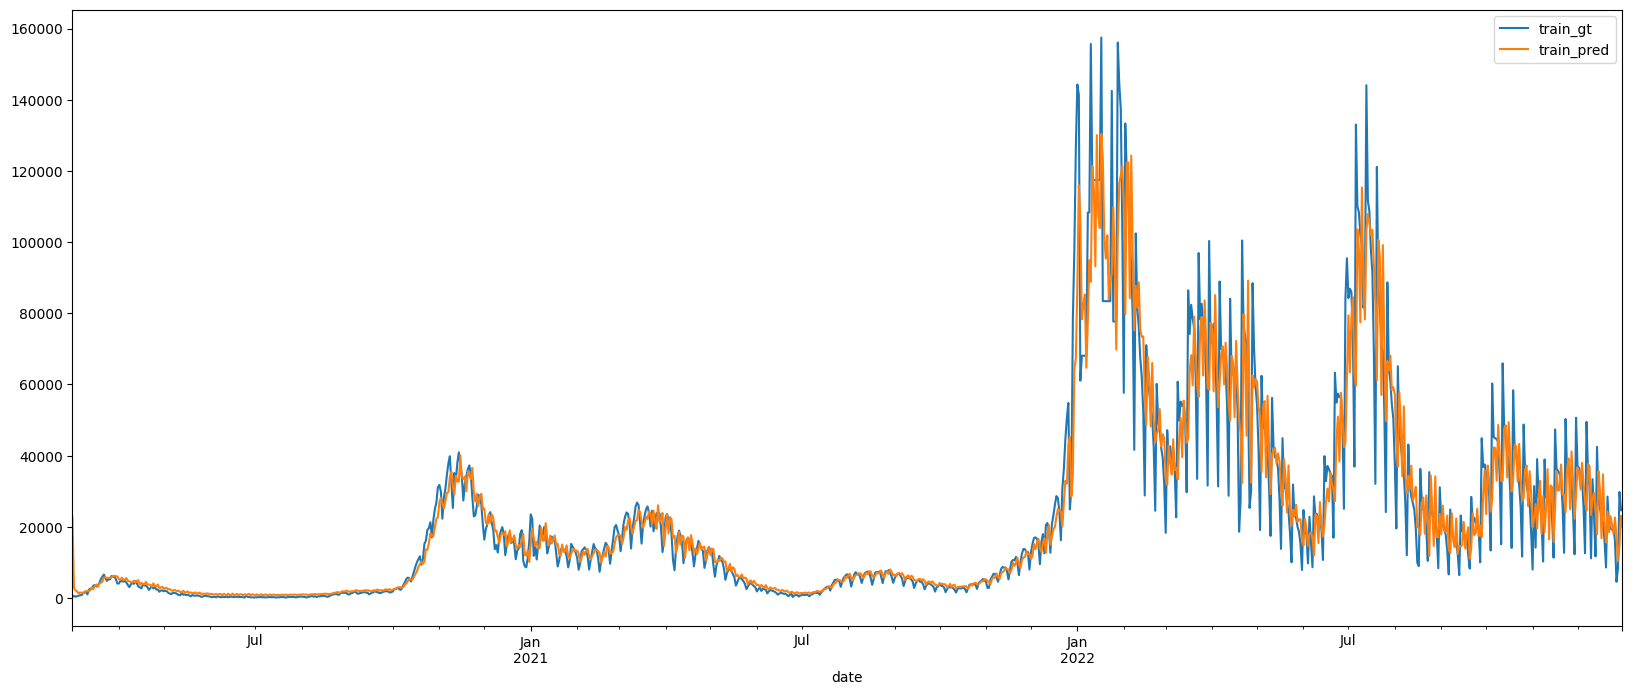

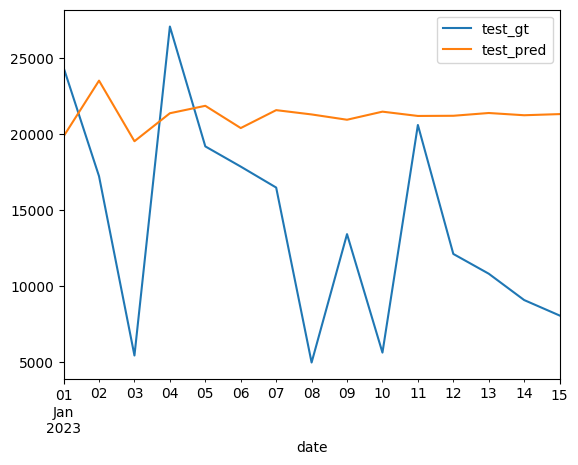

In [113]:
train_size = 0.98667935  
italy_split = int(len(italy_df) * train_size)
italy_train = italy_df.iloc[:italy_split]
italy_test = italy_df.iloc[italy_split:]

italy_train = italy_train.drop(columns = ['location'])
italy_test = italy_test.drop(columns = ['location'])

model = ARIMA(italy_train, order=(3, 0, 3))
model = model.fit()
train_pred=model.fittedvalues
train_pred.index = italy_train.index
pd.concat([italy_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
test_pred = model.predict(start=len(italy_train), end=len(italy_train)+len(italy_test)-1, dynamic=True)
test_pred.index = italy_test.index
pd.concat([italy_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
train_rmse = np.sqrt(mean_squared_error(italy_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(italy_test, test_pred))
test_srmse = test_rmse / np.mean(italy_test) * 100

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Test sRMSE: {test_srmse}')

italy_train_rmse = train_rmse
italy_test_rmse = test_rmse
italy_test_srmse = test_srmse

3. Lithuania

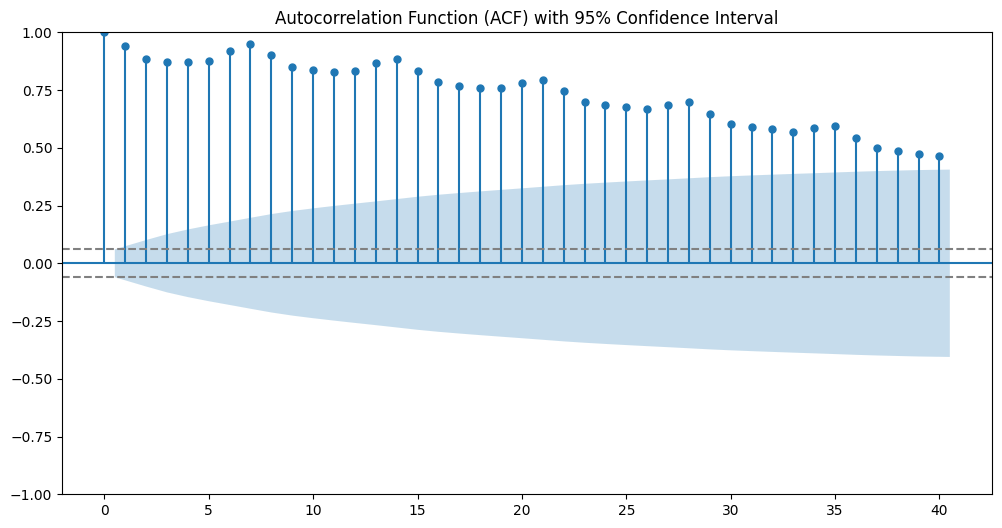

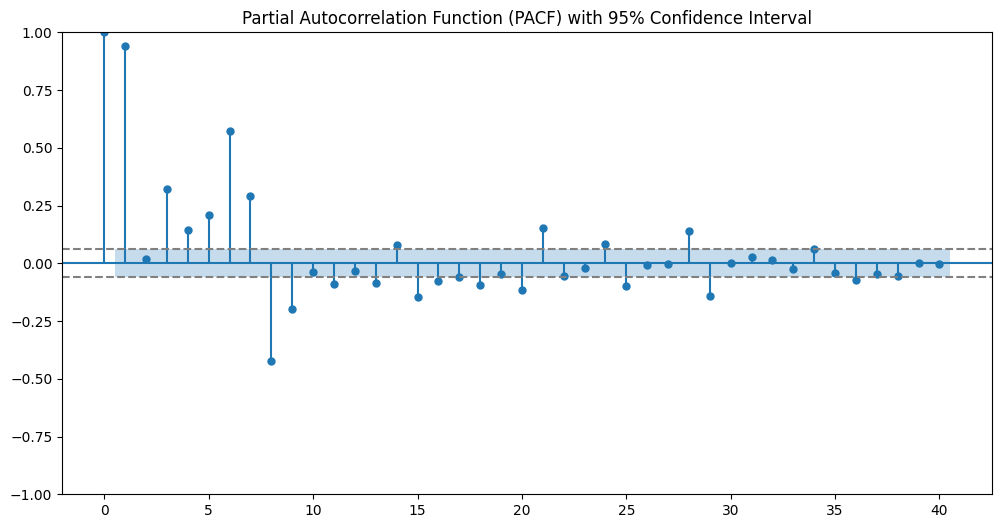

In [114]:
import statsmodels.api as sm
lithuania_df = stationary_df[stationary_df['location'] == 'Lithuania']

# Extract the relevant columns
target_variable = lithuania_df['new_cases']

# Plot ACF with threshold lines
fig, ax = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_acf(target_variable, lags=40, ax=ax)
ax.axhline(y=1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
ax.axhline(y=-1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
plt.title('Autocorrelation Function (ACF) with 95% Confidence Interval')
plt.show()

# Plot PACF with threshold lines
fig, ax = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_pacf(target_variable, lags=40, ax=ax)
ax.axhline(y=1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
ax.axhline(y=-1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function (PACF) with 95% Confidence Interval')
plt.show()

/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Train RMSE: 447.68576417423355
Test RMSE: 244.72242565732958
Test sRMSE: 88.02964951702504


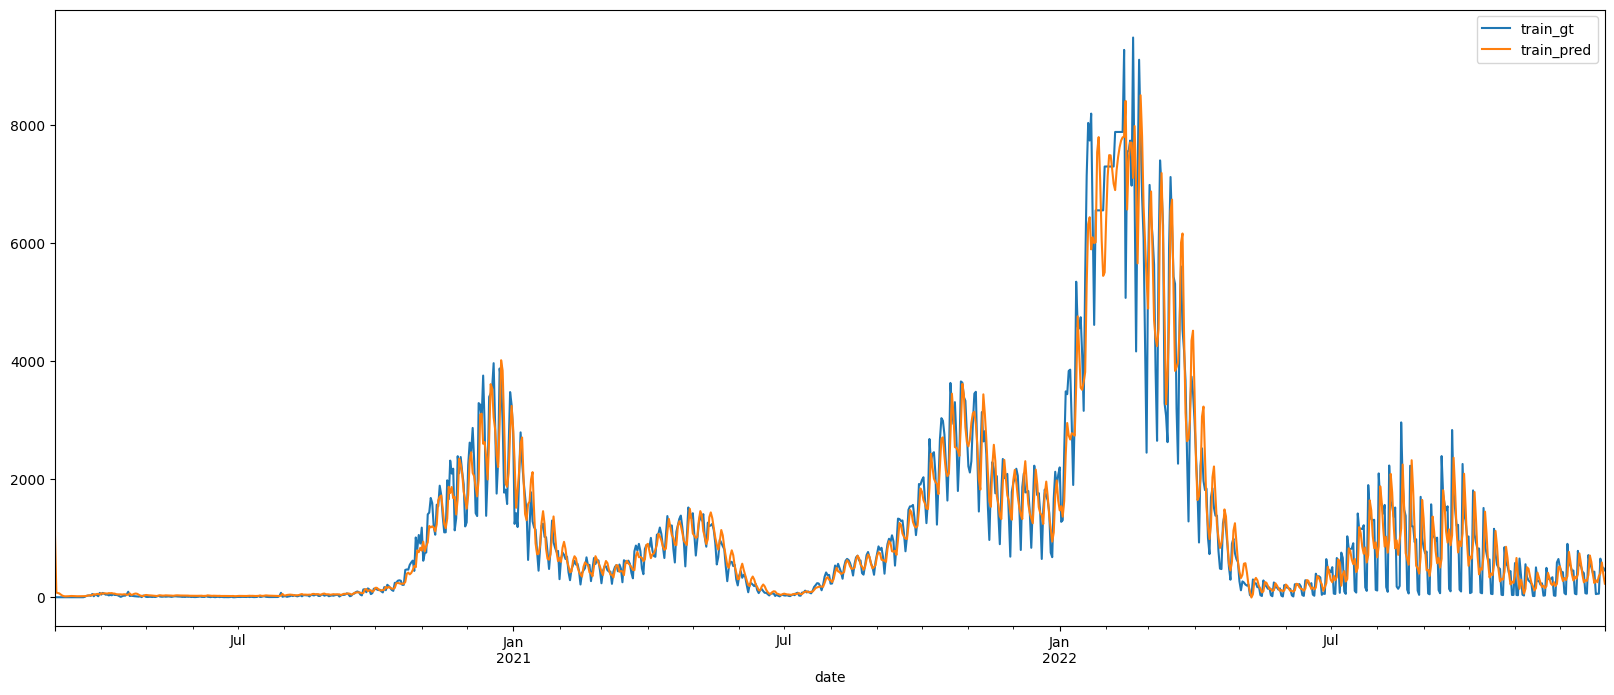

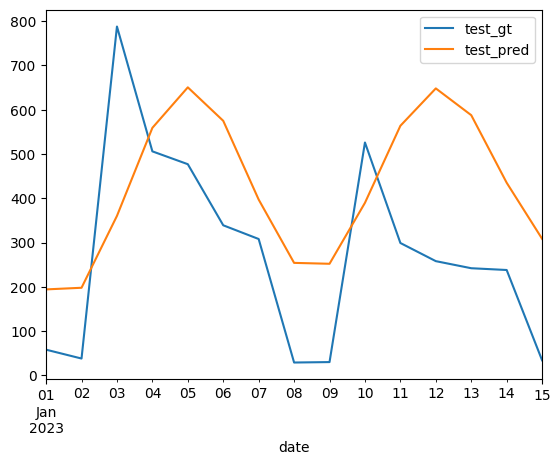

In [115]:
train_size = 0.98667935  
lithuania_split = int(len(lithuania_df) * train_size)
lithuania_train = lithuania_df.iloc[:lithuania_split]
lithuania_test = lithuania_df.iloc[lithuania_split:]

lithuania_train = lithuania_train.drop(columns = ['location'])
lithuania_test = lithuania_test.drop(columns = ['location'])

model = ARIMA(lithuania_train, order=(3, 0, 3))
model = model.fit()
train_pred=model.fittedvalues
train_pred.index = lithuania_train.index
pd.concat([lithuania_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
test_pred = model.predict(start=len(lithuania_train), end=len(lithuania_train)+len(lithuania_test)-1, dynamic=True)
test_pred.index = lithuania_test.index
pd.concat([lithuania_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
train_rmse = np.sqrt(mean_squared_error(lithuania_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(lithuania_test, test_pred))
test_srmse = test_rmse / np.mean(lithuania_test) * 100

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Test sRMSE: {test_srmse}')

lithuania_train_rmse = train_rmse
lithuania_test_rmse = test_rmse
lithuania_test_srmse = test_srmse

4. Poland

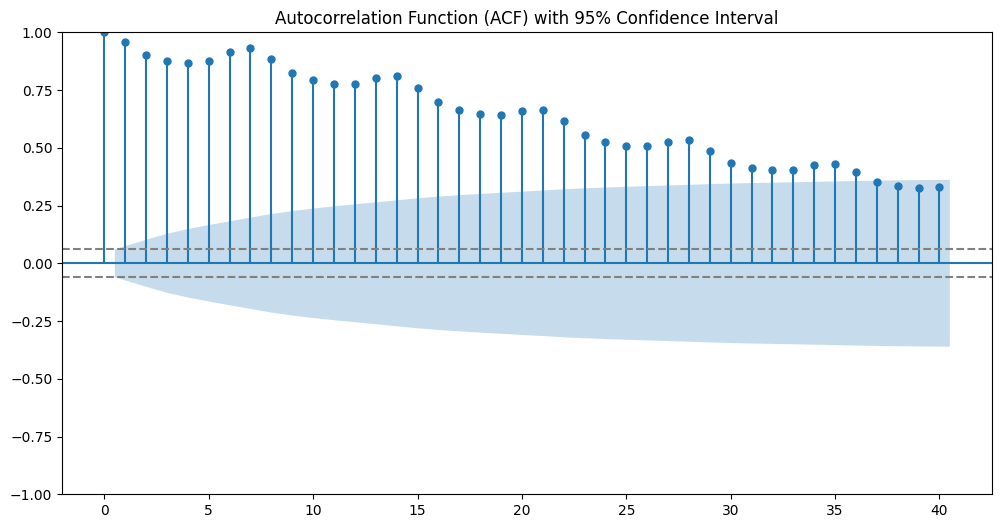

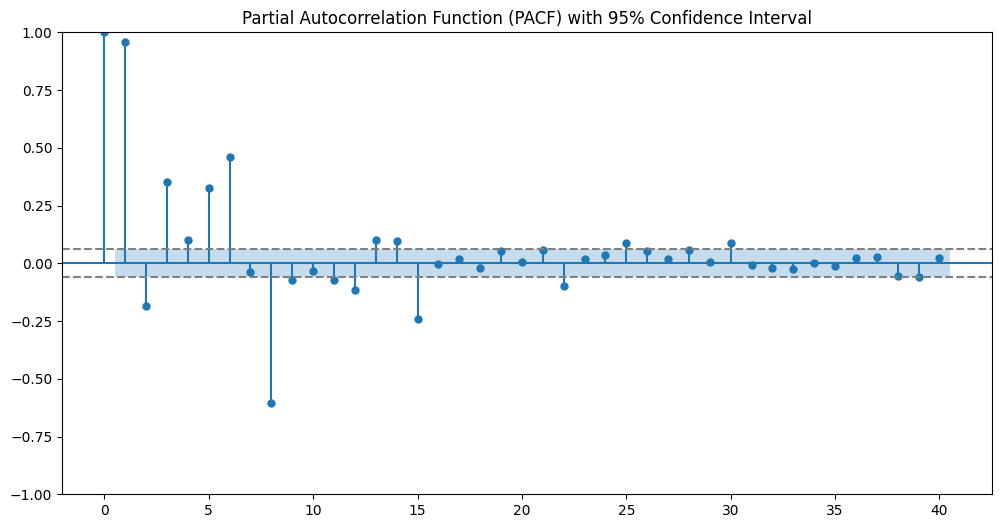

In [116]:
import statsmodels.api as sm
poland_df = stationary_df[stationary_df['location'] == 'Poland']

# Extract the relevant columns
target_variable = poland_df['new_cases']

# Plot ACF with threshold lines
fig, ax = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_acf(target_variable, lags=40, ax=ax)
ax.axhline(y=1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
ax.axhline(y=-1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
plt.title('Autocorrelation Function (ACF) with 95% Confidence Interval')
plt.show()

# Plot PACF with threshold lines
fig, ax = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_pacf(target_variable, lags=40, ax=ax)
ax.axhline(y=1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
ax.axhline(y=-1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function (PACF) with 95% Confidence Interval')
plt.show()

/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels

Train RMSE: 2202.598672705946
Test RMSE: 1706.647007321964
Test sRMSE: 528.1556655628112


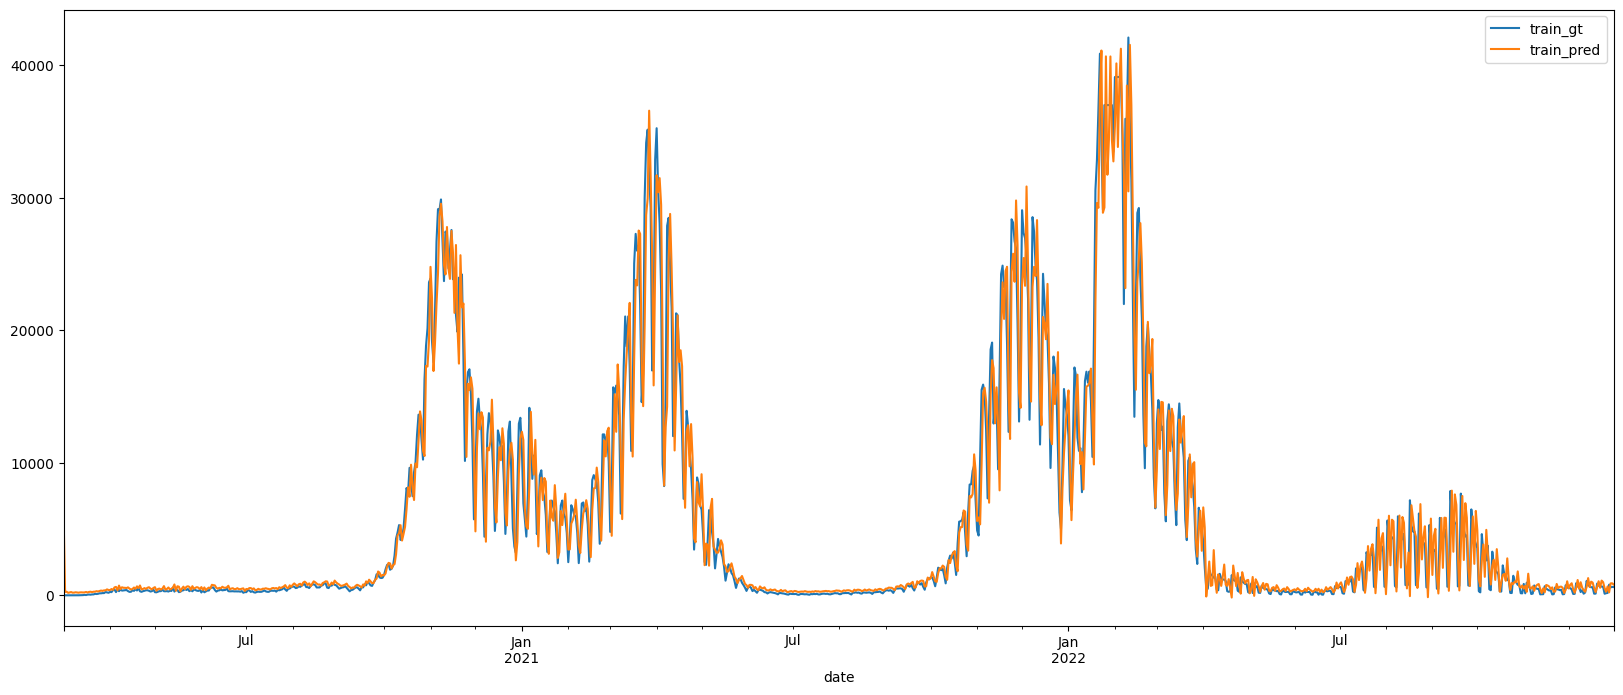

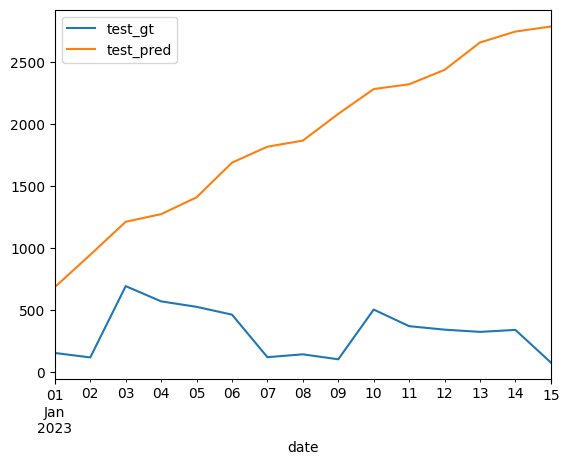

In [117]:
train_size = 0.98667935  
poland_split = int(len(poland_df) * train_size)
poland_train = poland_df.iloc[:poland_split]
poland_test = poland_df.iloc[poland_split:]

poland_train = poland_train.drop(columns = ['location'])
poland_test = poland_test.drop(columns = ['location'])

model = ARIMA(poland_train, order=(3, 0, 2))
model = model.fit()
train_pred=model.fittedvalues
train_pred.index = poland_train.index
pd.concat([poland_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
test_pred = model.predict(start=len(poland_train), end=len(poland_train)+len(poland_test)-1, dynamic=True)
test_pred.index = poland_test.index
pd.concat([poland_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
train_rmse = np.sqrt(mean_squared_error(poland_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(poland_test, test_pred))
test_srmse = test_rmse / np.mean(poland_test) * 100

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Test sRMSE: {test_srmse}')

poland_train_rmse = train_rmse
poland_test_rmse = test_rmse
poland_test_srmse = test_srmse

5. United Kingdom

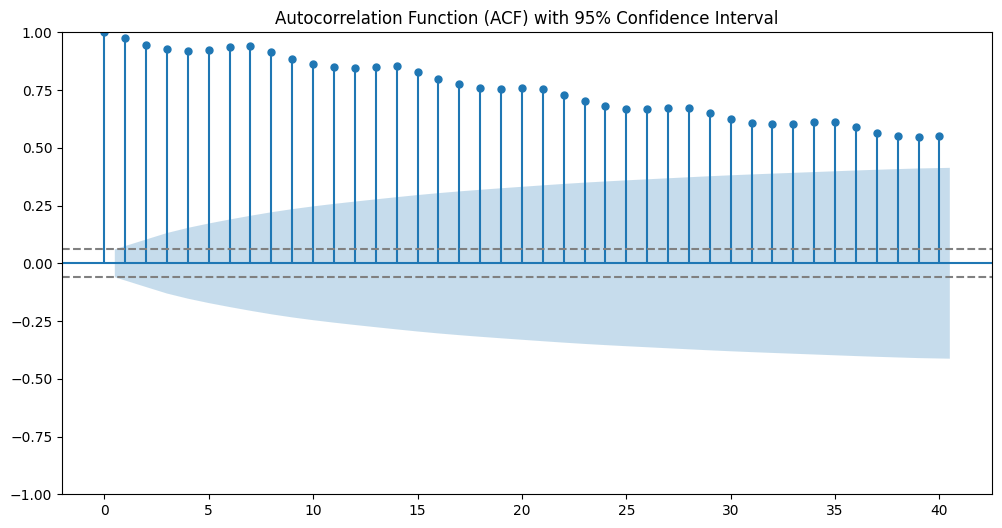

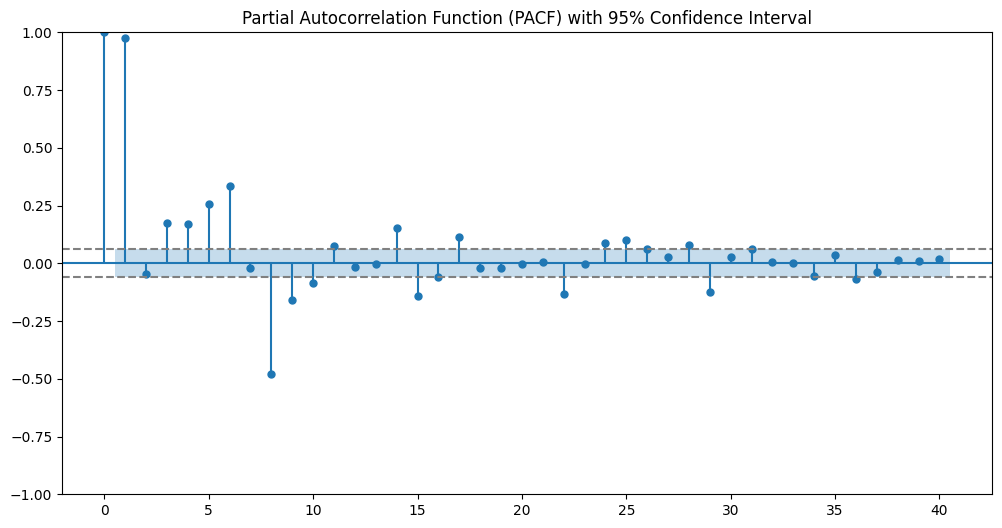

In [118]:
import statsmodels.api as sm
uk_df = stationary_df[stationary_df['location'] == 'United Kingdom']

# Extract the relevant columns
target_variable = uk_df['new_cases']

# Plot ACF with threshold lines
fig, ax = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_acf(target_variable, lags=40, ax=ax)
ax.axhline(y=1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
ax.axhline(y=-1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
plt.title('Autocorrelation Function (ACF) with 95% Confidence Interval')
plt.show()

# Plot PACF with threshold lines
fig, ax = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_pacf(target_variable, lags=40, ax=ax)
ax.axhline(y=1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
ax.axhline(y=-1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function (PACF) with 95% Confidence Interval')
plt.show()

/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels

Train RMSE: 5863.3453911783745
Test RMSE: 4051.928106793893
Test sRMSE: 102.94009722051453


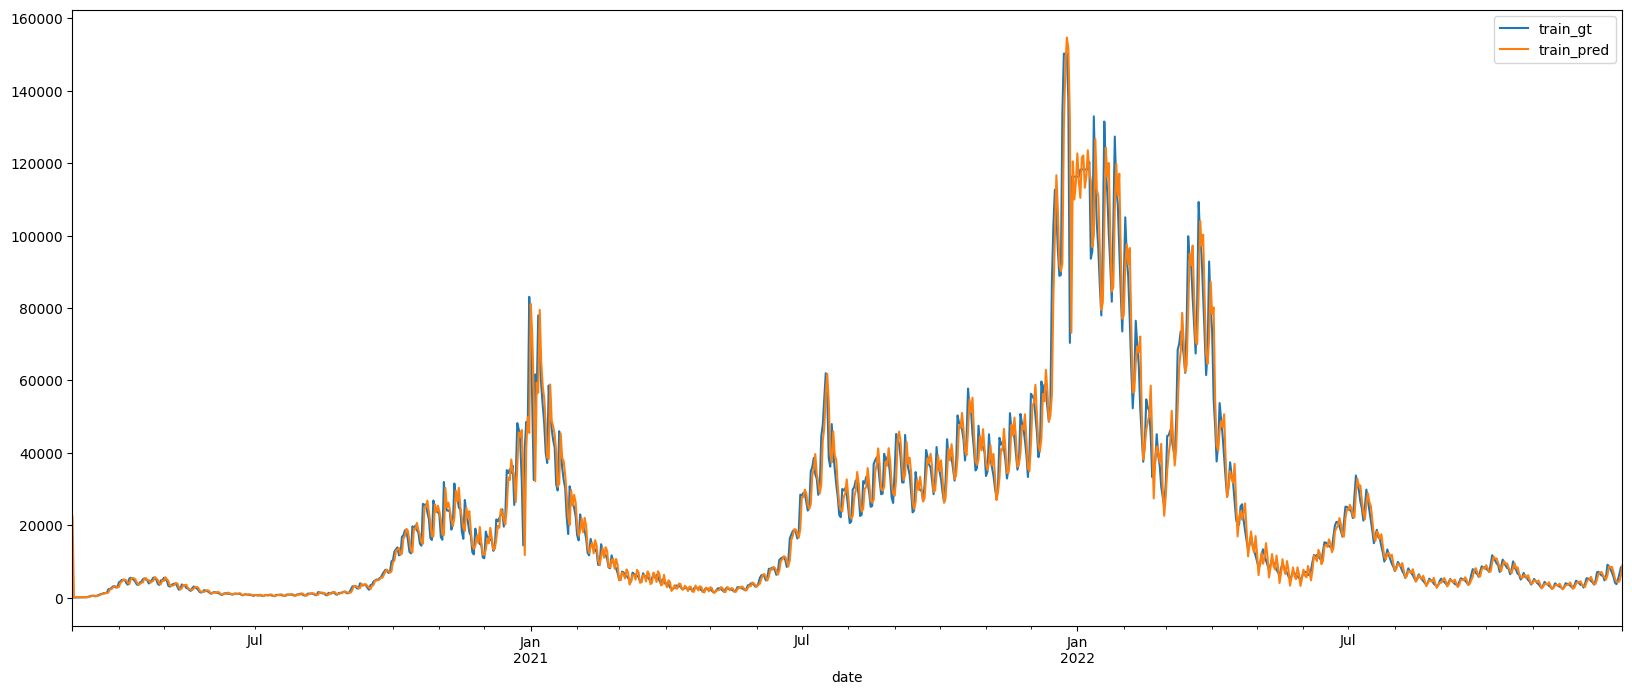

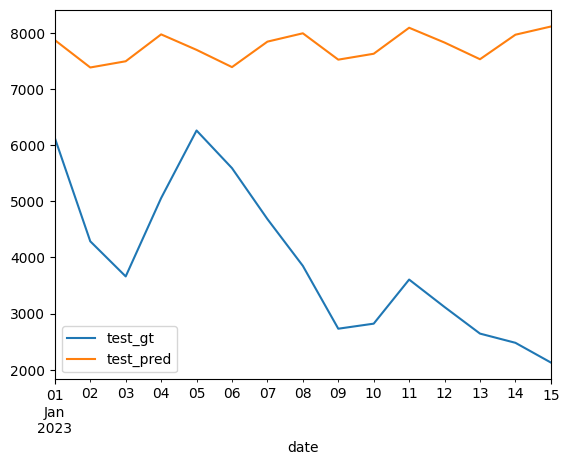

In [119]:
train_size = 0.98667935  
uk_split = int(len(uk_df) * train_size)
uk_train = uk_df.iloc[:uk_split]
uk_test = uk_df.iloc[uk_split:]

uk_train = uk_train.drop(columns = ['location'])
uk_test = uk_test.drop(columns = ['location'])

model = ARIMA(uk_train, order=(3, 0, 2))
model = model.fit()
train_pred=model.fittedvalues
train_pred.index = uk_train.index
pd.concat([uk_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
test_pred = model.predict(start=len(uk_train), end=len(uk_train)+len(uk_test)-1, dynamic=True)
test_pred.index = uk_test.index
pd.concat([uk_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])

train_rmse = np.sqrt(mean_squared_error(uk_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(uk_test, test_pred))
test_srmse = test_rmse / np.mean(uk_test) * 100

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Test sRMSE: {test_srmse}')

uk_train_rmse = train_rmse
uk_test_rmse = test_rmse
uk_test_srmse = test_srmse

### II. Non-Stationary

6. Belgium

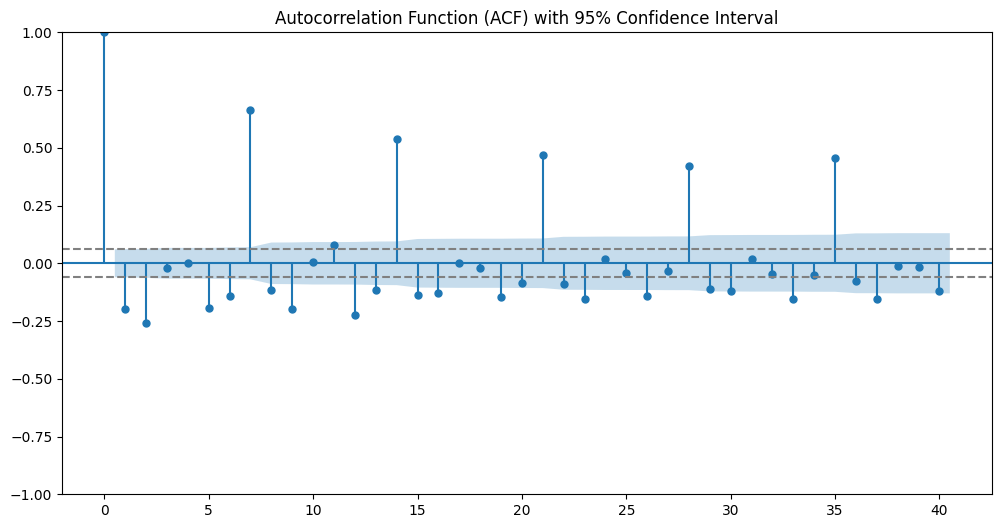

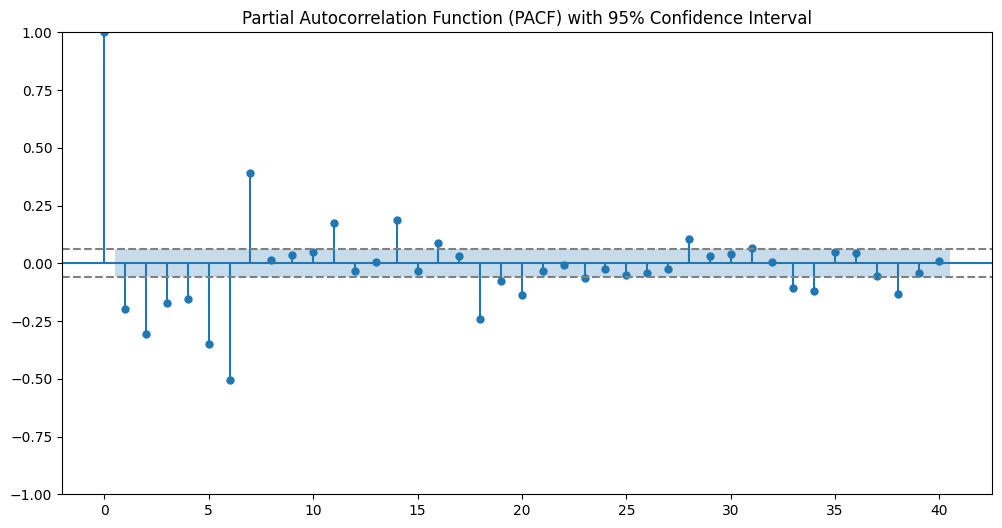

In [120]:
import statsmodels.api as sm
belgium_df = differenced_df[differenced_df['location'] == 'Belgium']

# Extract the relevant columns
target_variable = belgium_df['new_cases_diff']

# Plot ACF with threshold lines
fig, ax = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_acf(target_variable, lags=40, ax=ax)
ax.axhline(y=1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
ax.axhline(y=-1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
plt.title('Autocorrelation Function (ACF) with 95% Confidence Interval')
plt.show()

# Plot PACF with threshold lines
fig, ax = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_pacf(target_variable, lags=40, ax=ax)
ax.axhline(y=1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
ax.axhline(y=-1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function (PACF) with 95% Confidence Interval')
plt.show()

/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


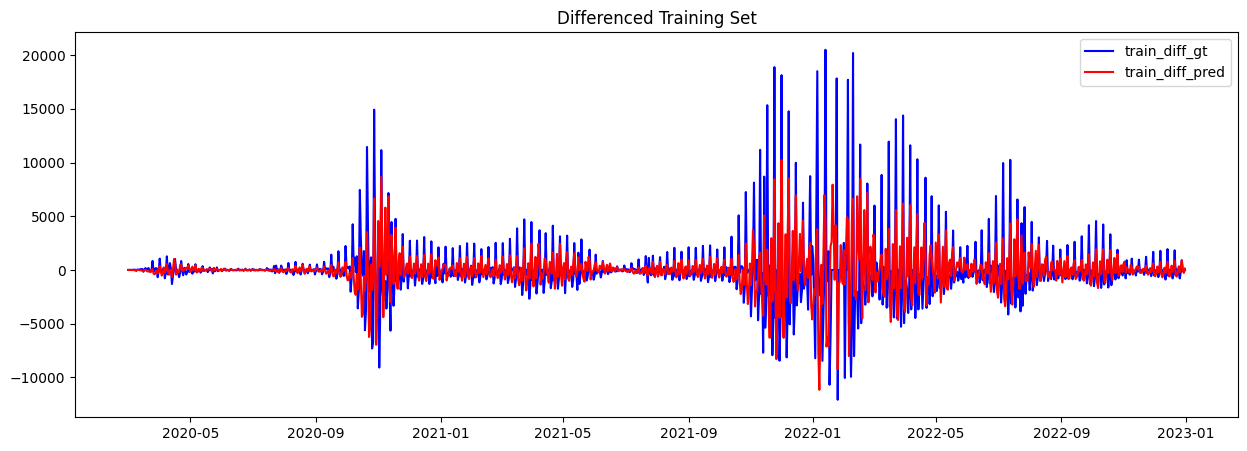

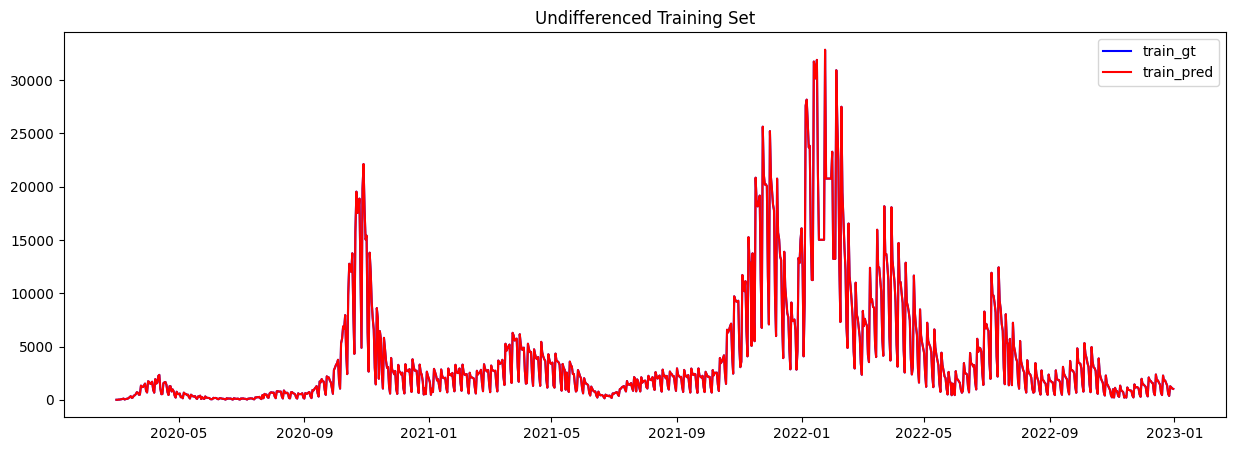

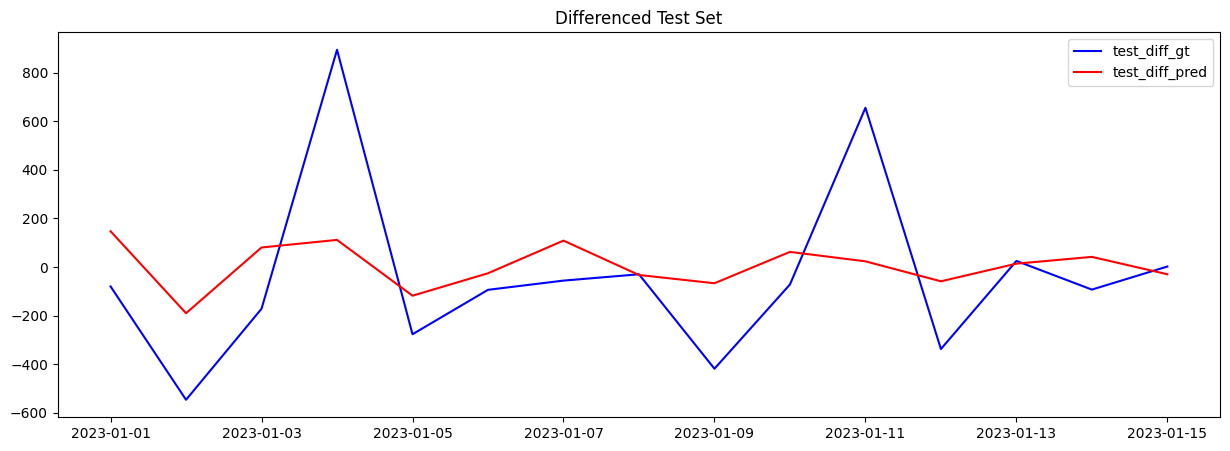

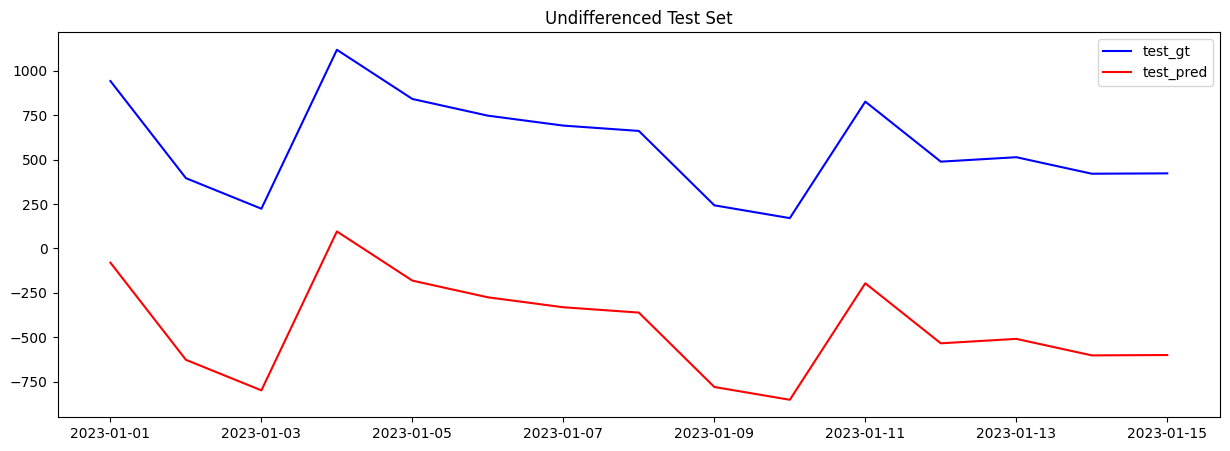

Train RMSE: 6754.471563227992
Test RMSE: 494.9595943104851


In [121]:
train_size = 0.98667935
belgium_split = int(len(belgium_df) * train_size)
belgium_train = belgium_df.iloc[:belgium_split]
belgium_test = belgium_df.iloc[belgium_split:]

# Fit the ARIMA model on the differenced data
model = ARIMA(belgium_train['new_cases_diff'], order=(2, 0, 3))
model = model.fit()

# Get predictions on the differenced training set
train_pred_diff = model.fittedvalues

# Construct the differenced DataFrame for training set
differenced_train = belgium_train.copy()
differenced_train['new_cases_pred_diff'] = train_pred_diff

# Plot differenced training set
plt.figure(figsize=(15, 5))
plt.plot(differenced_train['new_cases_diff'], label='train_diff_gt', color='blue')
plt.plot(train_pred_diff, label='train_diff_pred', color='red')
plt.legend()
plt.title('Differenced Training Set')
plt.show()

# Undifference the training predictions
train_pred = differenced_train['new_cases_diff'].cumsum()

# Construct the undifferenced DataFrame for training set
undifferenced_train = belgium_train.copy()
undifferenced_train['new_cases_pred'] = train_pred

# Plot undifferenced training set
plt.figure(figsize=(15, 5))
plt.plot(undifferenced_train['new_cases'], label='train_gt', color='blue')
plt.plot(train_pred, label='train_pred', color='red')
plt.legend()
plt.title('Undifferenced Training Set')
plt.show()

# Get predictions on the differenced test set
test_pred_diff = model.predict(start=len(belgium_train), end=len(belgium_train) + len(belgium_test) - 1, dynamic=True)

# Construct the differenced DataFrame for test set
differenced_test = belgium_test.copy()
differenced_test['new_cases_pred_diff'] = test_pred_diff

# Plot differenced test set
plt.figure(figsize=(15, 5))
plt.plot(differenced_test['new_cases_diff'], label='test_diff_gt', color='blue')
plt.plot(test_pred_diff, label='test_diff_pred', color='red')
plt.legend()
plt.title('Differenced Test Set')
plt.show()

# Undifference the test predictions
test_pred = differenced_test['new_cases_diff'].cumsum()

# Construct the undifferenced DataFrame for test set
undifferenced_test = belgium_test.copy()
undifferenced_test['new_cases_pred'] = test_pred

# Plot undifferenced test set
plt.figure(figsize=(15, 5))
plt.plot(undifferenced_test['new_cases'], label='test_gt', color='blue')
plt.plot(test_pred, label='test_pred', color='red')
plt.legend()
plt.title('Undifferenced Test Set')
plt.show()

# Calculate RMSE for training and test sets
train_rmse = np.sqrt(mean_squared_error(differenced_train['new_cases_diff'], train_pred))
test_rmse = np.sqrt(mean_squared_error(differenced_test['new_cases_diff'], test_pred))
test_srmse = test_rmse / np.mean(differenced_test['new_cases_diff']) * 100

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

belgium_train_rmse = train_rmse
belgium_test_rmse = test_rmse
belgium_test_srmse = test_srmse

7. Denmark

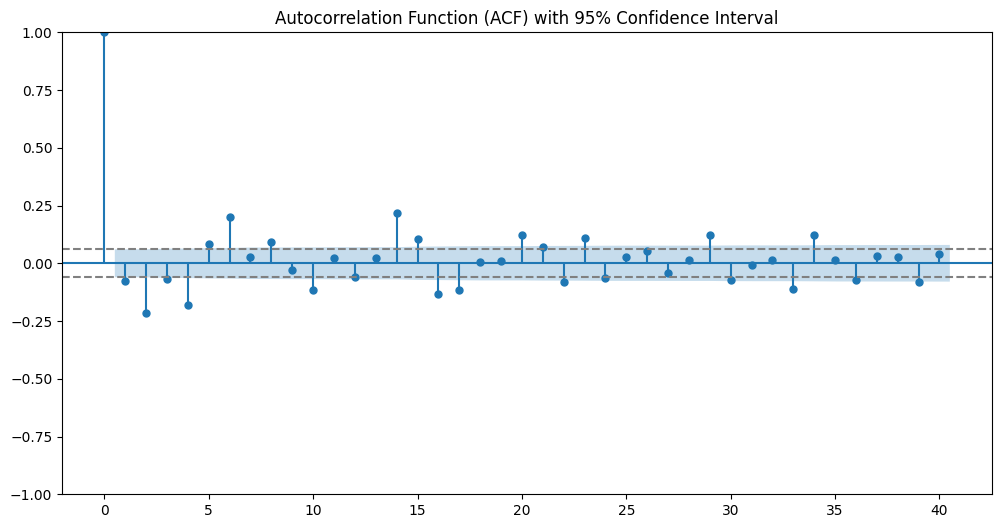

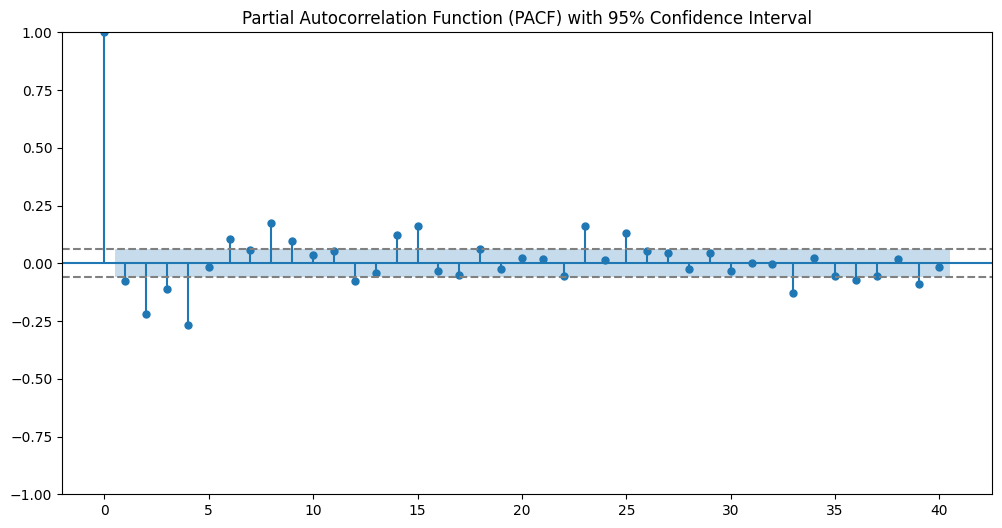

In [122]:
import statsmodels.api as sm
denmark_df = differenced_df[differenced_df['location'] == 'Denmark']

# Extract the relevant columns
target_variable = denmark_df['new_cases_diff']

# Plot ACF with threshold lines
fig, ax = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_acf(target_variable, lags=40, ax=ax)
ax.axhline(y=1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
ax.axhline(y=-1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
plt.title('Autocorrelation Function (ACF) with 95% Confidence Interval')
plt.show()

# Plot PACF with threshold lines
fig, ax = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_pacf(target_variable, lags=40, ax=ax)
ax.axhline(y=1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
ax.axhline(y=-1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function (PACF) with 95% Confidence Interval')
plt.show()

/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


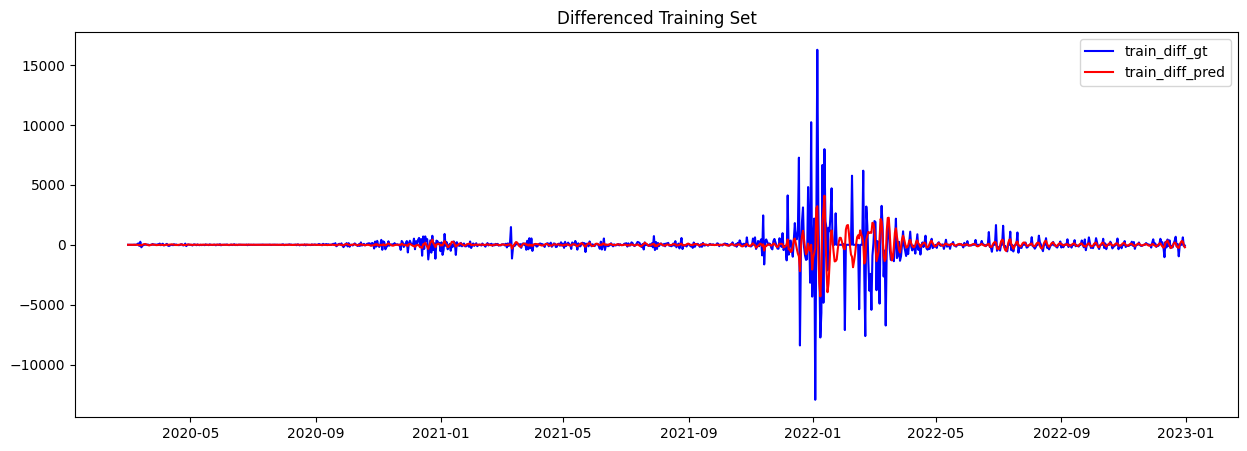

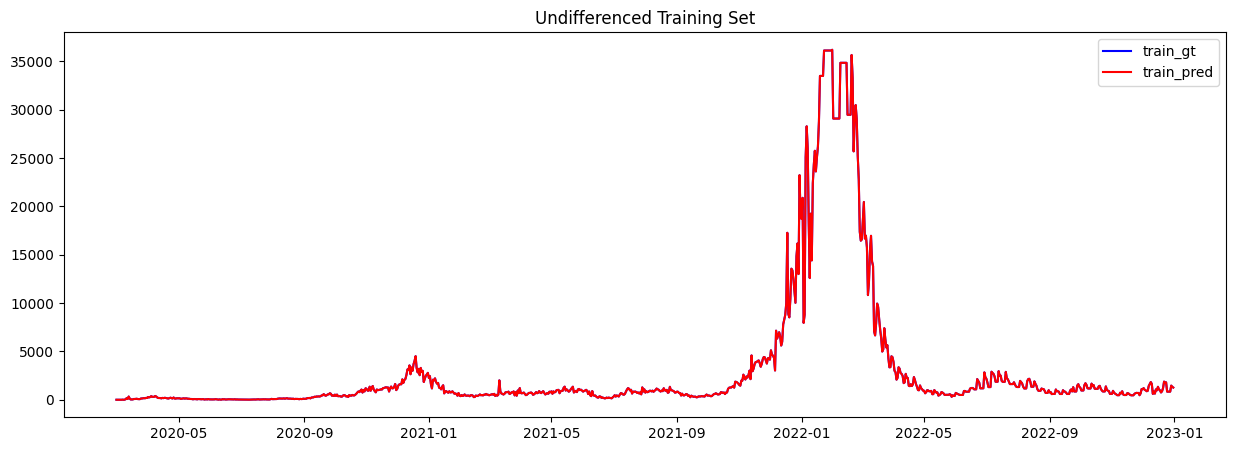

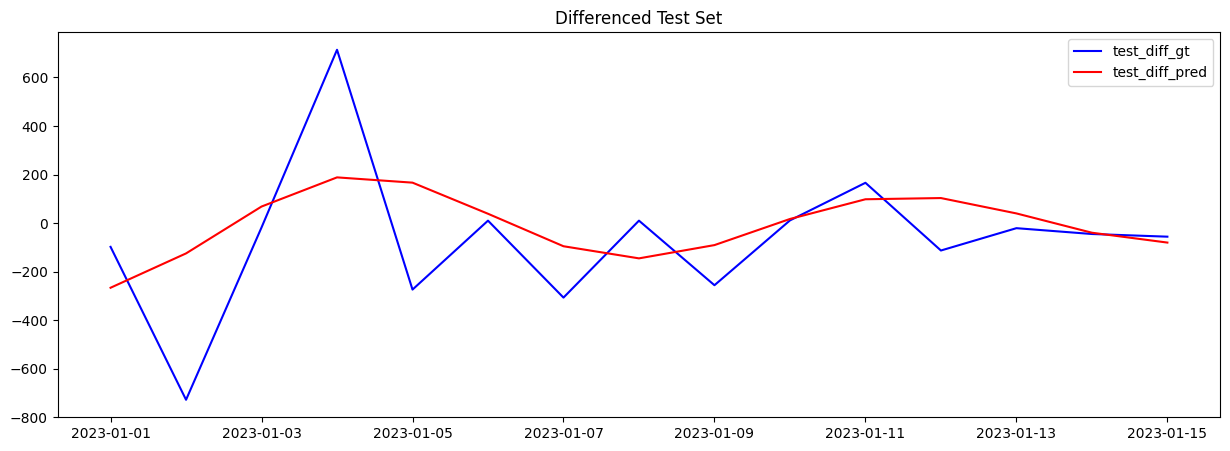

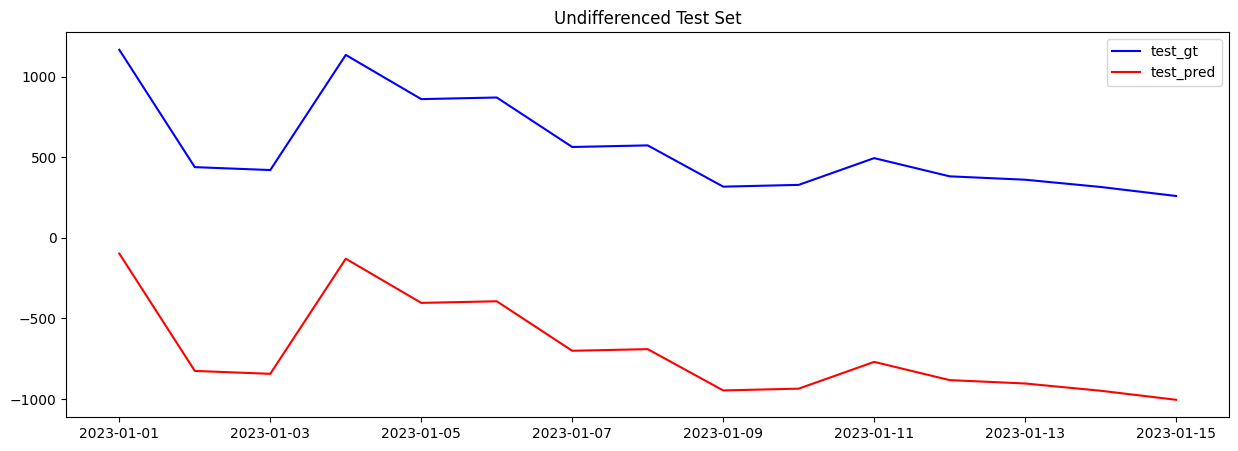

Train RMSE: 7535.096119295827
Test RMSE: 710.4815737699794
Test sRMSE: -1060.420259358178


In [123]:
train_size = 0.98667935
denmark_split = int(len(denmark_df) * train_size)
denmark_train = denmark_df.iloc[:denmark_split]
denmark_test = denmark_df.iloc[denmark_split:]

# Fit the ARIMA model on the differenced data
model = ARIMA(denmark_train['new_cases_diff'], order=(2, 0, 3))
model = model.fit()

# Get predictions on the differenced training set
train_pred_diff = model.fittedvalues

# Construct the differenced DataFrame for training set
differenced_train = denmark_train.copy()
differenced_train['new_cases_pred_diff'] = train_pred_diff

# Plot differenced training set
plt.figure(figsize=(15, 5))
plt.plot(denmark_train['new_cases_diff'], label='train_diff_gt', color='blue')
plt.plot(train_pred_diff, label='train_diff_pred', color='red')
plt.legend()
plt.title('Differenced Training Set')
plt.show()

# Undifference the training predictions
train_pred = differenced_train['new_cases_diff'].cumsum()

# Construct the undifferenced DataFrame for training set
undifferenced_train = denmark_train.copy()
undifferenced_train['new_cases_pred'] = train_pred

# Plot undifferenced training set
plt.figure(figsize=(15, 5))
plt.plot(undifferenced_train['new_cases'], label='train_gt', color='blue')
plt.plot(train_pred, label='train_pred', color='red')
plt.legend()
plt.title('Undifferenced Training Set')
plt.show()

# Get predictions on the differenced test set
test_pred_diff = model.predict(start=len(denmark_train), end=len(denmark_train) + len(denmark_test) - 1, dynamic=True)

# Construct the differenced DataFrame for test set
differenced_test = denmark_test.copy()
differenced_test['new_cases_pred_diff'] = test_pred_diff

# Plot differenced test set
plt.figure(figsize=(15, 5))
plt.plot(differenced_test['new_cases_diff'], label='test_diff_gt', color='blue')
plt.plot(test_pred_diff, label='test_diff_pred', color='red')
plt.legend()
plt.title('Differenced Test Set')
plt.show()

# Undifference the test predictions
test_pred = differenced_test['new_cases_diff'].cumsum()

# Construct the undifferenced DataFrame for test set
undifferenced_test = denmark_test.copy()
undifferenced_test['new_cases_pred'] = test_pred

# Plot undifferenced test set
plt.figure(figsize=(15, 5))
plt.plot(undifferenced_test['new_cases'], label='test_gt', color='blue')
plt.plot(test_pred, label='test_pred', color='red')
plt.legend()
plt.title('Undifferenced Test Set')
plt.show()

# Calculate RMSE for training and test sets
train_rmse = np.sqrt(mean_squared_error(differenced_train['new_cases_diff'], train_pred))
test_rmse = np.sqrt(mean_squared_error(differenced_test['new_cases_diff'], test_pred))
test_srmse = test_rmse / np.mean(differenced_test['new_cases_diff']) * 100

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Test sRMSE: {test_srmse}')

denmark_train_rmse = train_rmse
denmark_test_rmse = test_rmse
denmark_test_srmse = test_srmse

8. Finland

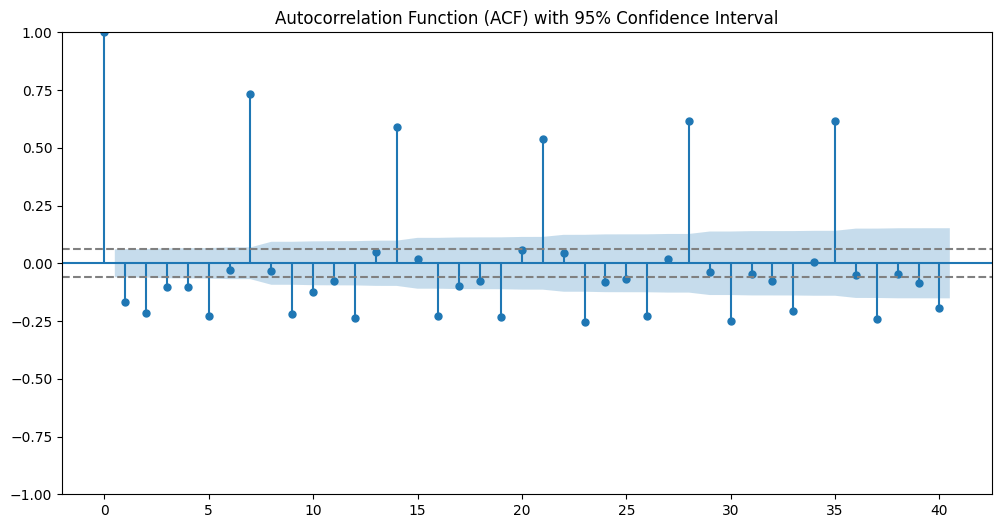

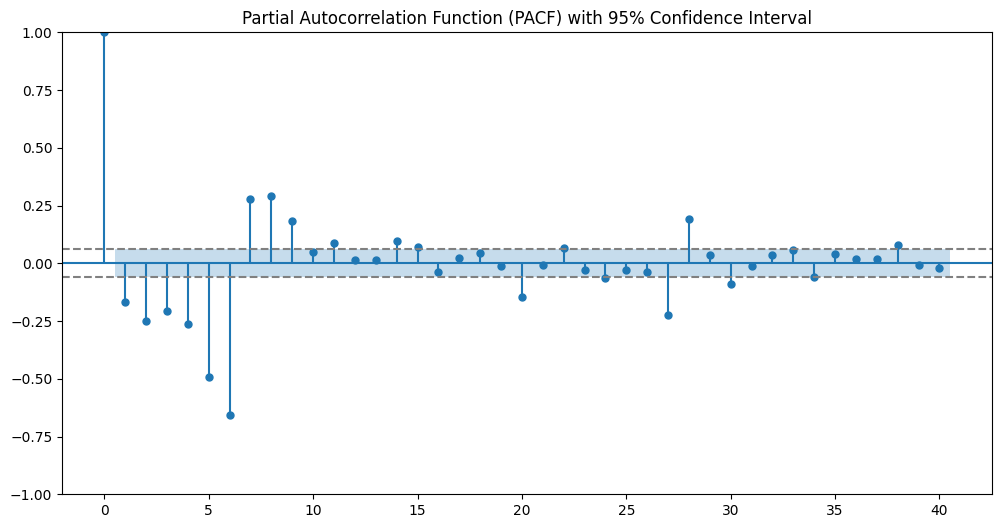

In [124]:
import statsmodels.api as sm
finland_df = differenced_df[differenced_df['location'] == 'Finland']

# Extract the relevant columns
target_variable = finland_df['new_cases_diff']

# Plot ACF with threshold lines
fig, ax = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_acf(target_variable, lags=40, ax=ax)
ax.axhline(y=1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
ax.axhline(y=-1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
plt.title('Autocorrelation Function (ACF) with 95% Confidence Interval')
plt.show()

# Plot PACF with threshold lines
fig, ax = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_pacf(target_variable, lags=40, ax=ax)
ax.axhline(y=1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
ax.axhline(y=-1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function (PACF) with 95% Confidence Interval')
plt.show()

/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


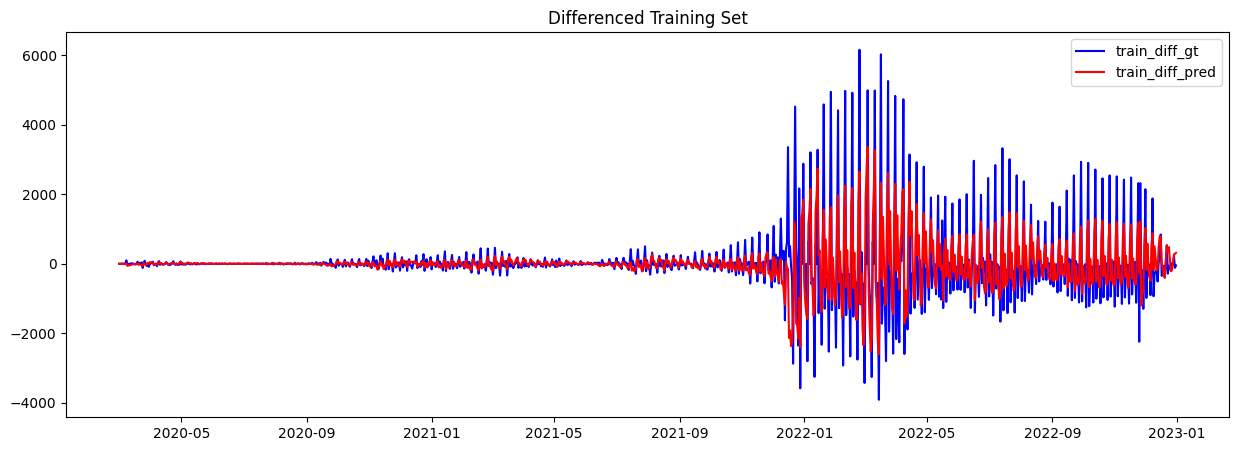

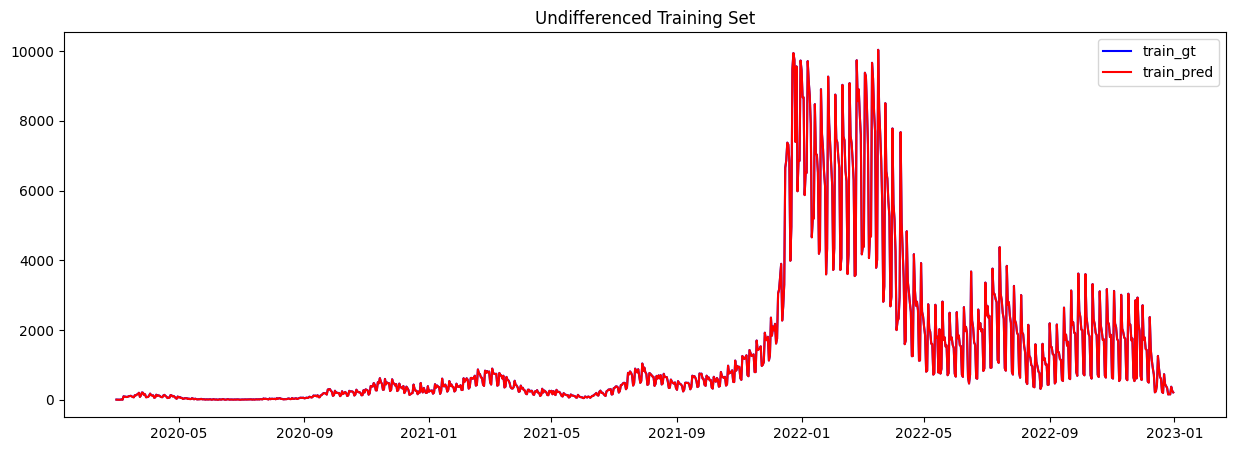

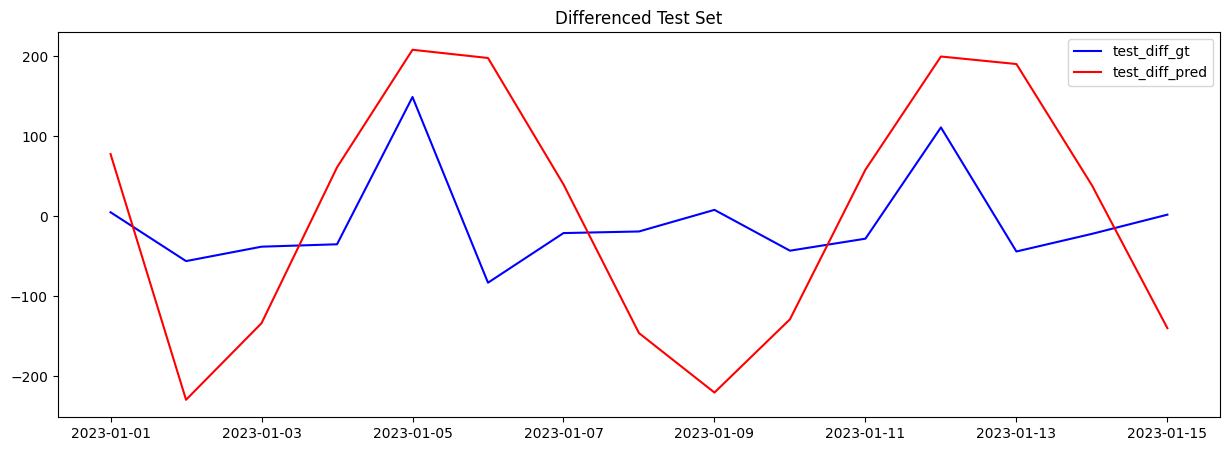

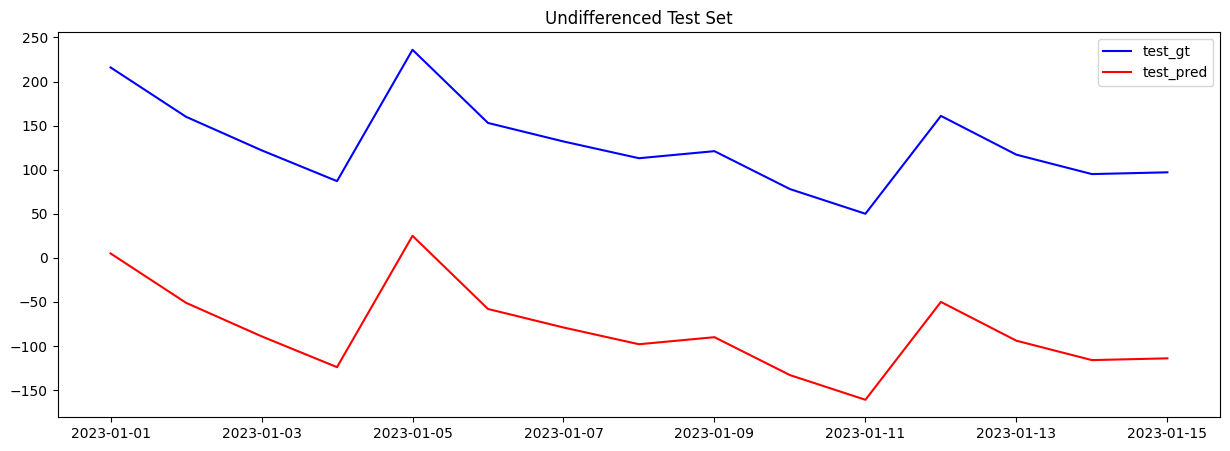

Train RMSE: 2523.1975146382115
Test RMSE: 90.28067345783371
Test sRMSE: -1187.903598129391


In [125]:
train_size = 0.98667935
finland_split = int(len(finland_df) * train_size)
finland_train = finland_df.iloc[:finland_split]
finland_test = finland_df.iloc[finland_split:]

# Fit the ARIMA model on the differenced data
model = ARIMA(finland_train['new_cases_diff'], order=(2, 0, 3))
model = model.fit()

# Get predictions on the differenced training set
train_pred_diff = model.fittedvalues

# Construct the differenced DataFrame for training set
differenced_train = finland_train.copy()
differenced_train['new_cases_pred_diff'] = train_pred_diff

# Plot differenced training set
plt.figure(figsize=(15, 5))
plt.plot(finland_train['new_cases_diff'], label='train_diff_gt', color='blue')
plt.plot(train_pred_diff, label='train_diff_pred', color='red')
plt.legend()
plt.title('Differenced Training Set')
plt.show()

# Undifference the training predictions
train_pred = differenced_train['new_cases_diff'].cumsum()

# Construct the undifferenced DataFrame for training set
undifferenced_train = finland_train.copy()
undifferenced_train['new_cases_pred'] = train_pred

# Plot undifferenced training set
plt.figure(figsize=(15, 5))
plt.plot(undifferenced_train['new_cases'], label='train_gt', color='blue')
plt.plot(train_pred, label='train_pred', color='red')
plt.legend()
plt.title('Undifferenced Training Set')
plt.show()

# Get predictions on the differenced test set
test_pred_diff = model.predict(start=len(finland_train), end=len(finland_train) + len(finland_test) - 1, dynamic=True)

# Construct the differenced DataFrame for test set
differenced_test = finland_test.copy()
differenced_test['new_cases_pred_diff'] = test_pred_diff

# Plot differenced test set
plt.figure(figsize=(15, 5))
plt.plot(differenced_test['new_cases_diff'], label='test_diff_gt', color='blue')
plt.plot(test_pred_diff, label='test_diff_pred', color='red')
plt.legend()
plt.title('Differenced Test Set')
plt.show()

# Undifference the test predictions
test_pred = differenced_test['new_cases_diff'].cumsum()

# Construct the undifferenced DataFrame for test set
undifferenced_test = finland_test.copy()
undifferenced_test['new_cases_pred'] = test_pred

# Plot undifferenced test set
plt.figure(figsize=(15, 5))
plt.plot(undifferenced_test['new_cases'], label='test_gt', color='blue')
plt.plot(test_pred, label='test_pred', color='red')
plt.legend()
plt.title('Undifferenced Test Set')
plt.show()

# Calculate RMSE for training and test sets
train_rmse = np.sqrt(mean_squared_error(differenced_train['new_cases_diff'], train_pred))
test_rmse = np.sqrt(mean_squared_error(differenced_test['new_cases_diff'], test_pred))
test_srmse = test_rmse / np.mean(differenced_test['new_cases_diff']) * 100

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Test sRMSE: {test_srmse}')

finland_train_rmse = train_rmse
finland_test_rmse = test_rmse
finland_test_srmse = test_srmse

ACF tails off
PACF cuts off after lag 1 (pretty much)
ARIMA (1, 1, 0)

9. Norway

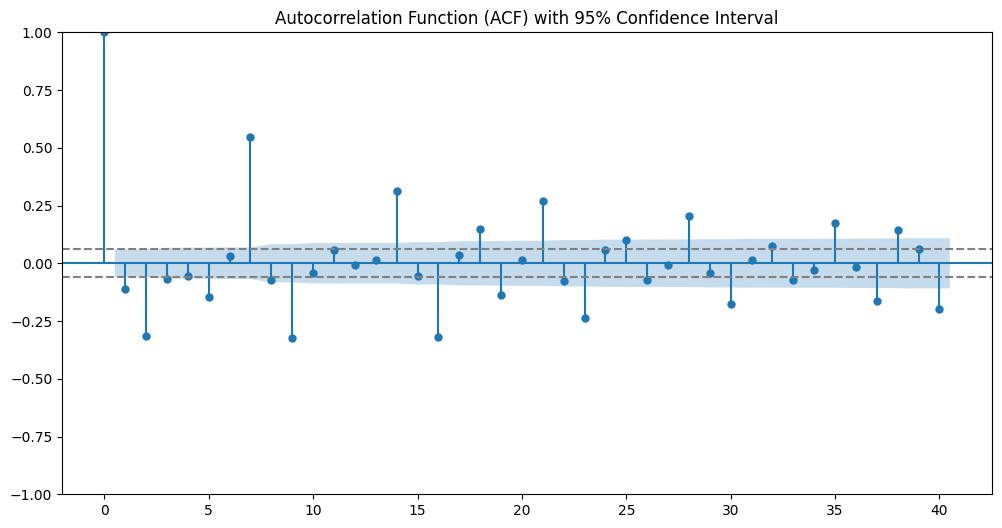

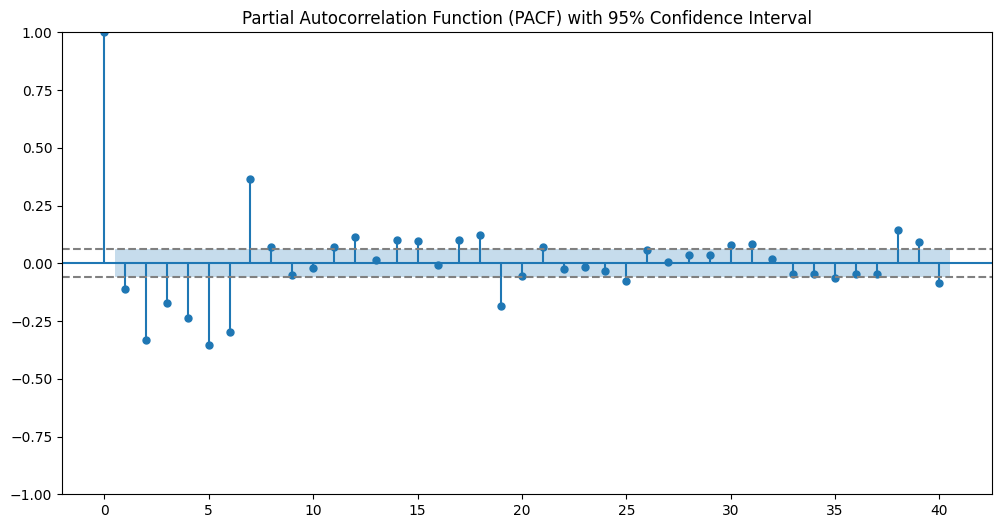

In [126]:
import statsmodels.api as sm
norway_df = differenced_df[differenced_df['location'] == 'Norway']

# Extract the relevant columns
target_variable = norway_df['new_cases_diff']

# Plot ACF with threshold lines
fig, ax = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_acf(target_variable, lags=40, ax=ax)
ax.axhline(y=1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
ax.axhline(y=-1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
plt.title('Autocorrelation Function (ACF) with 95% Confidence Interval')
plt.show()

# Plot PACF with threshold lines
fig, ax = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_pacf(target_variable, lags=40, ax=ax)
ax.axhline(y=1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
ax.axhline(y=-1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function (PACF) with 95% Confidence Interval')
plt.show()

/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


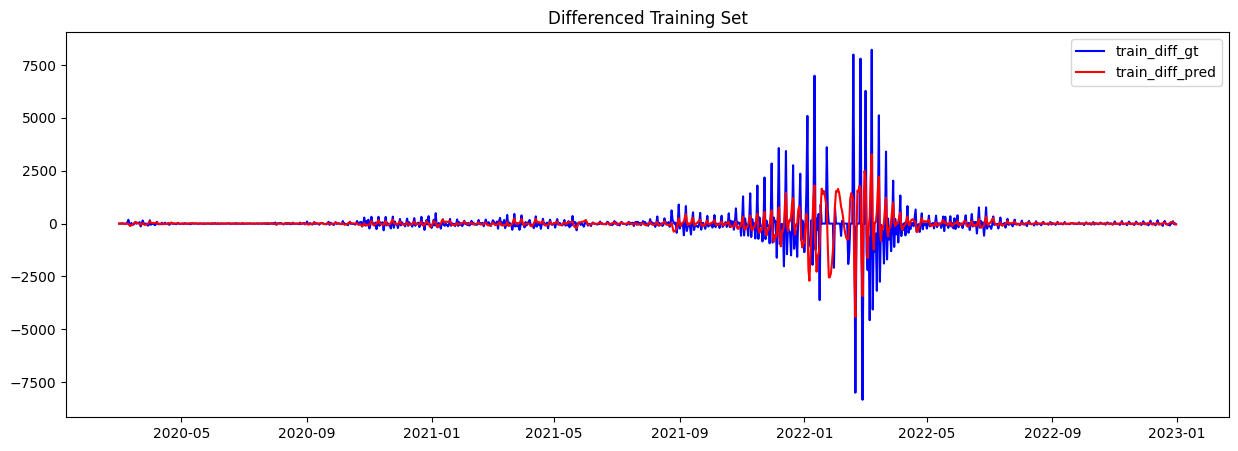

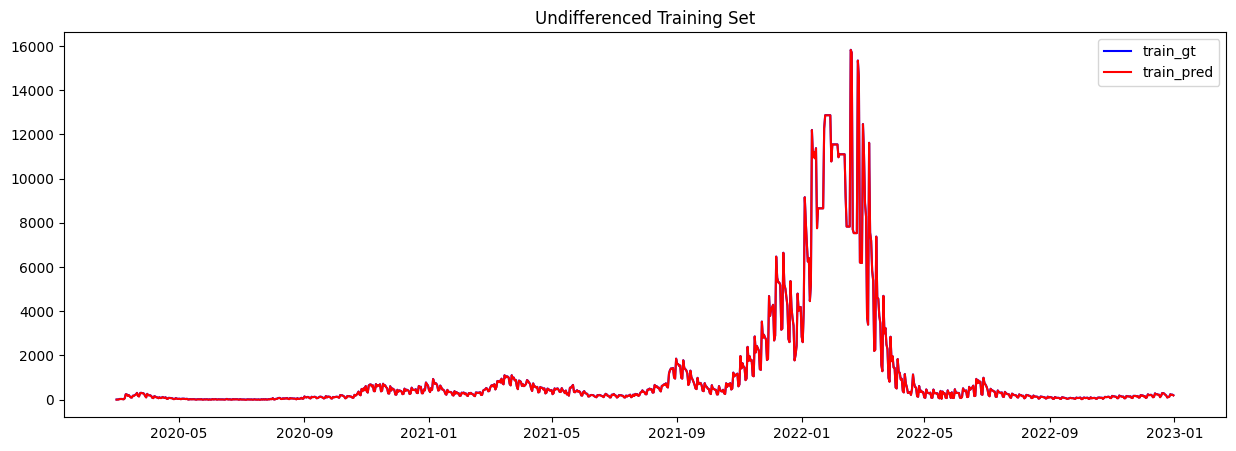

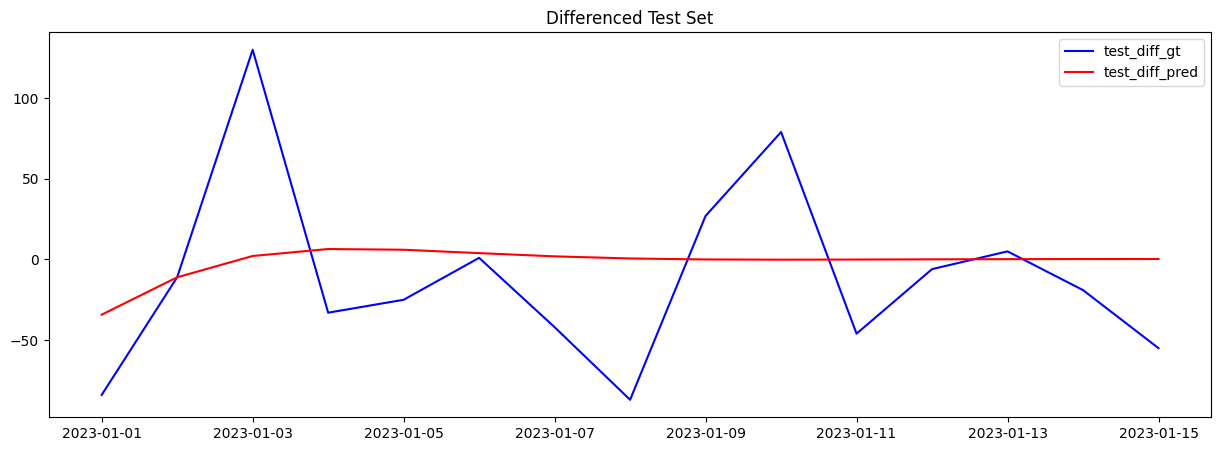

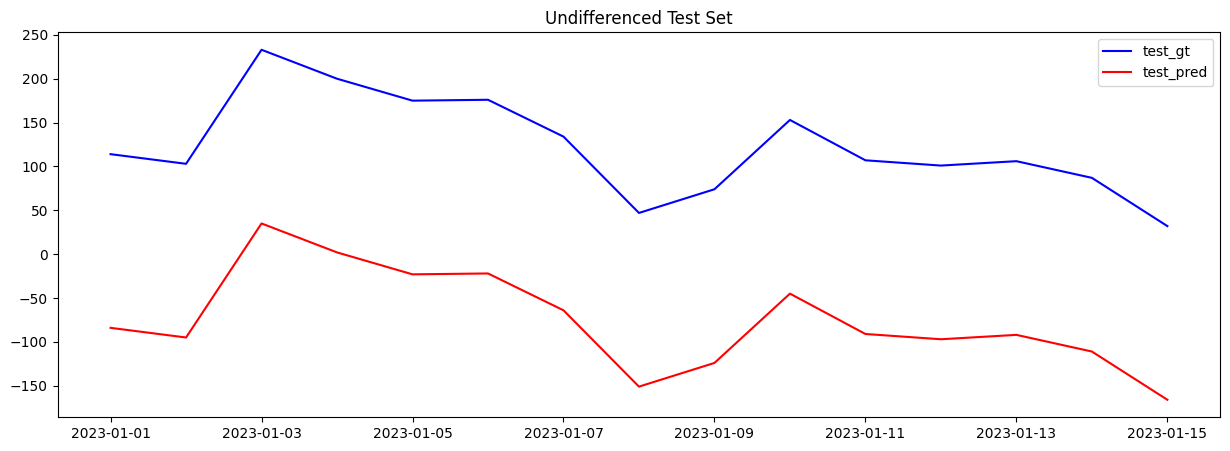

Train RMSE: 2768.1531927361966
Test RMSE: 82.09587890590693
Test sRMSE: -741.8302310774723


In [127]:
train_size = 0.98667935
norway_split = int(len(norway_df) * train_size)
norway_train = norway_df.iloc[:norway_split]
norway_test = norway_df.iloc[norway_split:]

# Fit the ARIMA model on the differenced data
model = ARIMA(norway_train['new_cases_diff'], order=(2, 0, 3))
model = model.fit()

# Get predictions on the differenced training set
train_pred_diff = model.fittedvalues

# Construct the differenced DataFrame for training set
differenced_train = norway_train.copy()
differenced_train['new_cases_pred_diff'] = train_pred_diff

# Plot differenced training set
plt.figure(figsize=(15, 5))
plt.plot(norway_train['new_cases_diff'], label='train_diff_gt', color='blue')
plt.plot(train_pred_diff, label='train_diff_pred', color='red')
plt.legend()
plt.title('Differenced Training Set')
plt.show()

# Undifference the training predictions
train_pred = differenced_train['new_cases_diff'].cumsum()

# Construct the undifferenced DataFrame for training set
undifferenced_train = norway_train.copy()
undifferenced_train['new_cases_pred'] = train_pred

# Plot undifferenced training set
plt.figure(figsize=(15, 5))
plt.plot(undifferenced_train['new_cases'], label='train_gt', color='blue')
plt.plot(train_pred, label='train_pred', color='red')
plt.legend()
plt.title('Undifferenced Training Set')
plt.show()

# Get predictions on the differenced test set
test_pred_diff = model.predict(start=len(norway_train), end=len(norway_train) + len(norway_test) - 1, dynamic=True)

# Construct the differenced DataFrame for test set
differenced_test = norway_test.copy()
differenced_test['new_cases_pred_diff'] = test_pred_diff

# Plot differenced test set
plt.figure(figsize=(15, 5))
plt.plot(differenced_test['new_cases_diff'], label='test_diff_gt', color='blue')
plt.plot(test_pred_diff, label='test_diff_pred', color='red')
plt.legend()
plt.title('Differenced Test Set')
plt.show()

# Undifference the test predictions
test_pred = differenced_test['new_cases_diff'].cumsum()

# Construct the undifferenced DataFrame for test set
undifferenced_test = norway_test.copy()
undifferenced_test['new_cases_pred'] = test_pred

# Plot undifferenced test set
plt.figure(figsize=(15, 5))
plt.plot(undifferenced_test['new_cases'], label='test_gt', color='blue')
plt.plot(test_pred, label='test_pred', color='red')
plt.legend()
plt.title('Undifferenced Test Set')
plt.show()


train_rmse = np.sqrt(mean_squared_error(differenced_train['new_cases_diff'], train_pred))
test_rmse = np.sqrt(mean_squared_error(differenced_test['new_cases_diff'], test_pred))
test_srmse = test_rmse / np.mean(differenced_test['new_cases_diff']) * 100

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Test sRMSE: {test_srmse}')

norway_train_rmse = train_rmse
norway_test_rmse = test_rmse
norway_test_srmse = test_srmse

Both ACF and PACF tail off - hard to manually find p & q (without doing it by hand)
Will use auto-ARIMA inputs: ARIMA (0, 1, 0) - random walk

10. Switzerland

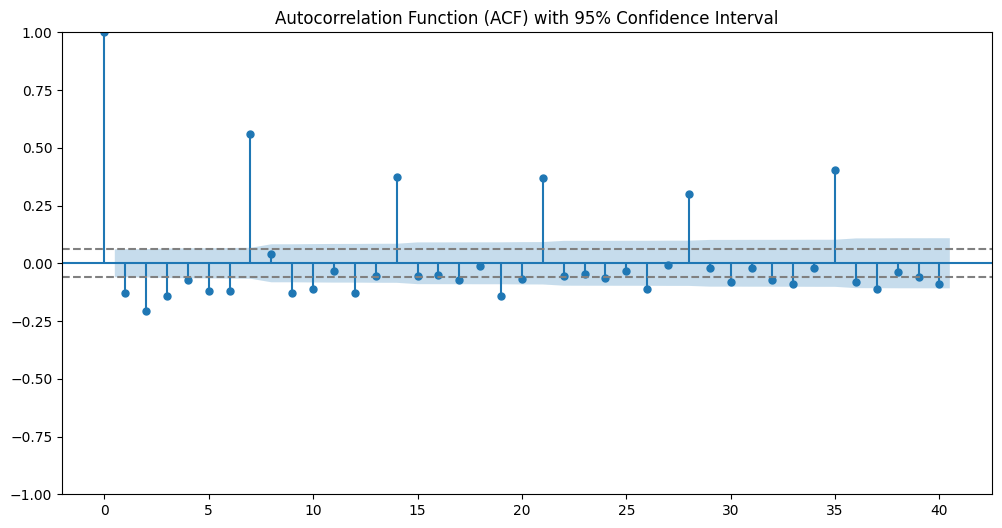

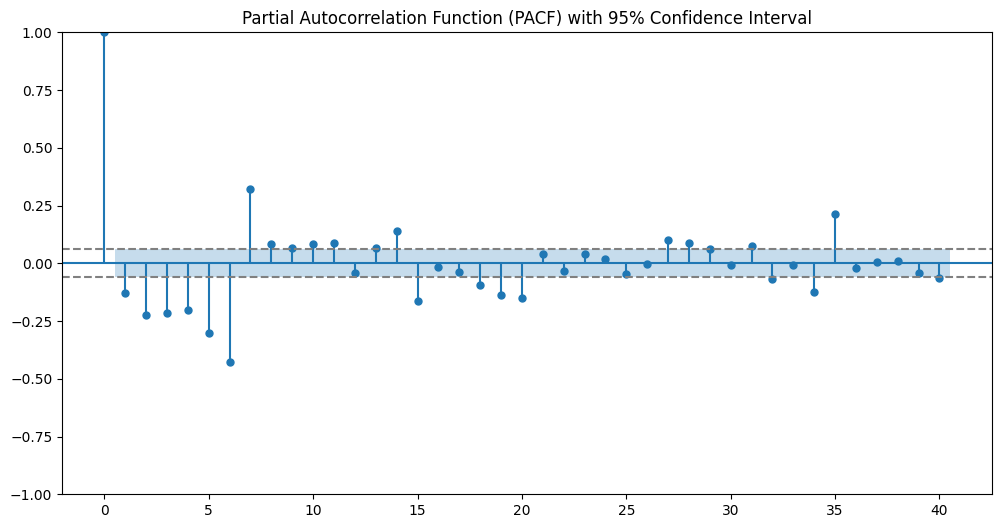

In [128]:
import statsmodels.api as sm
switzerland_df = differenced_df[differenced_df['location'] == 'Switzerland']

# Extract the relevant columns
target_variable = switzerland_df['new_cases_diff']

# Plot ACF with threshold lines
fig, ax = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_acf(target_variable, lags=40, ax=ax)
ax.axhline(y=1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
ax.axhline(y=-1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
plt.title('Autocorrelation Function (ACF) with 95% Confidence Interval')
plt.show()

# Plot PACF with threshold lines
fig, ax = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_pacf(target_variable, lags=40, ax=ax)
ax.axhline(y=1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
ax.axhline(y=-1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function (PACF) with 95% Confidence Interval')
plt.show()

/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


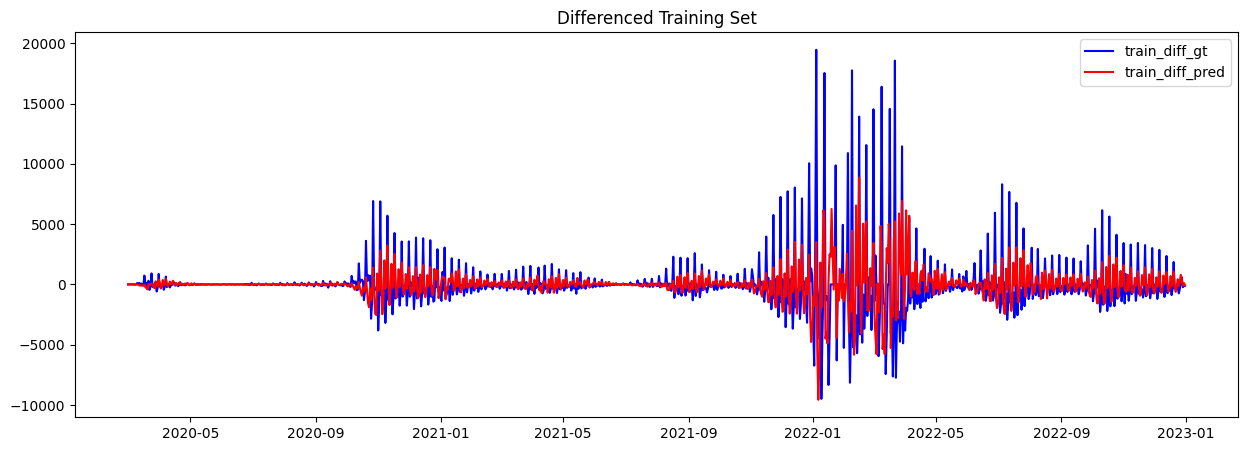

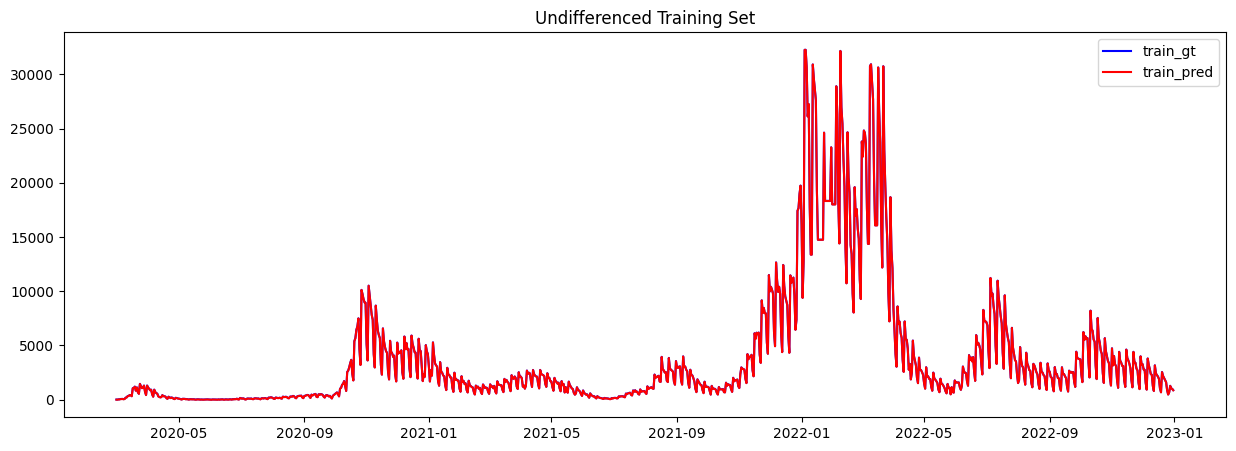

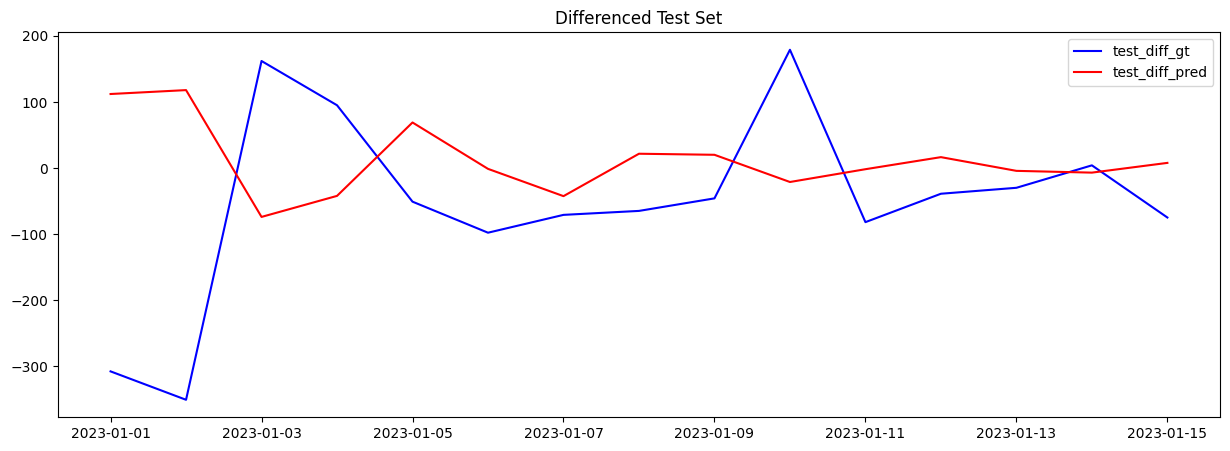

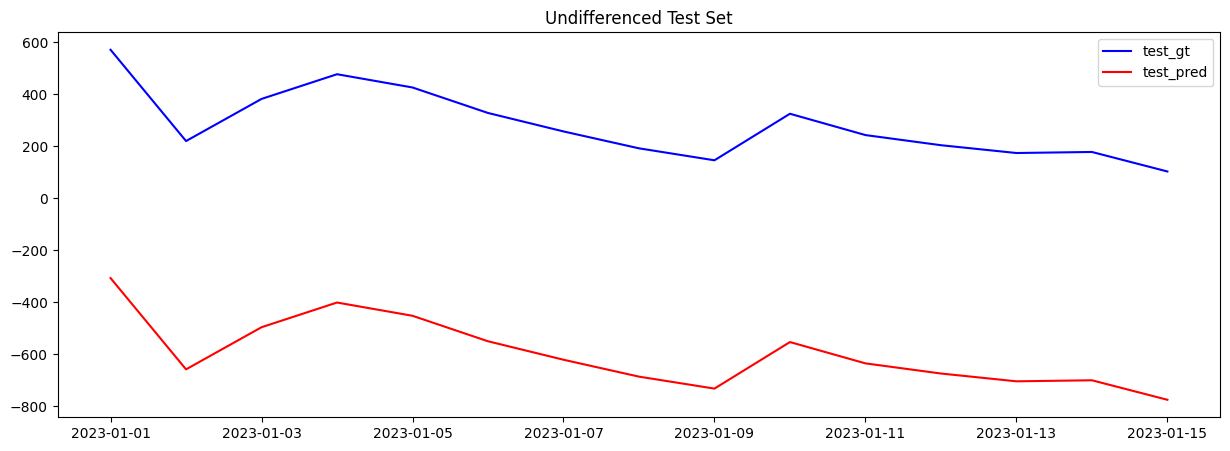

Train RMSE: 6971.356724699403
Test RMSE: 577.2447776579129
Test sRMSE: -1115.8082042356564


In [129]:
train_size = 0.98667935
switzerland_split = int(len(switzerland_df) * train_size)
switzerland_train = switzerland_df.iloc[:switzerland_split]
switzerland_test = switzerland_df.iloc[switzerland_split:]

# Fit the ARIMA model on the differenced data
model = ARIMA(switzerland_train['new_cases_diff'], order=(2, 0, 3))
model = model.fit()

# Get predictions on the differenced training set
train_pred_diff = model.fittedvalues

# Construct the differenced DataFrame for training set
differenced_train = switzerland_train.copy()
differenced_train['new_cases_pred_diff'] = train_pred_diff

# Plot differenced training set
plt.figure(figsize=(15, 5))
plt.plot(switzerland_train['new_cases_diff'], label='train_diff_gt', color='blue')
plt.plot(train_pred_diff, label='train_diff_pred', color='red')
plt.legend()
plt.title('Differenced Training Set')
plt.show()

# Undifference the training predictions
train_pred = differenced_train['new_cases_diff'].cumsum()

# Construct the undifferenced DataFrame for training set
undifferenced_train = switzerland_train.copy()
undifferenced_train['new_cases_pred'] = train_pred

# Plot undifferenced training set
plt.figure(figsize=(15, 5))
plt.plot(undifferenced_train['new_cases'], label='train_gt', color='blue')
plt.plot(train_pred, label='train_pred', color='red')
plt.legend()
plt.title('Undifferenced Training Set')
plt.show()

# Get predictions on the differenced test set
test_pred_diff = model.predict(start=len(switzerland_train), end=len(switzerland_train) + len(switzerland_test) - 1, dynamic=True)

# Construct the differenced DataFrame for test set
differenced_test = switzerland_test.copy()
differenced_test['new_cases_pred_diff'] = test_pred_diff

# Plot differenced test set
plt.figure(figsize=(15, 5))
plt.plot(differenced_test['new_cases_diff'], label='test_diff_gt', color='blue')
plt.plot(test_pred_diff, label='test_diff_pred', color='red')
plt.legend()
plt.title('Differenced Test Set')
plt.show()

# Undifference the test predictions
test_pred = differenced_test['new_cases_diff'].cumsum()

# Construct the undifferenced DataFrame for test set
undifferenced_test = switzerland_test.copy()
undifferenced_test['new_cases_pred'] = test_pred

# Plot undifferenced test set
plt.figure(figsize=(15, 5))
plt.plot(undifferenced_test['new_cases'], label='test_gt', color='blue')
plt.plot(test_pred, label='test_pred', color='red')
plt.legend()
plt.title('Undifferenced Test Set')
plt.show()

# Calculate RMSE for training and test sets
train_rmse = np.sqrt(mean_squared_error(differenced_train['new_cases_diff'], train_pred))
test_rmse = np.sqrt(mean_squared_error(differenced_test['new_cases_diff'], test_pred))
test_srmse = test_rmse / np.mean(differenced_test['new_cases_diff']) * 100

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Test sRMSE: {test_srmse}')


switzerland_train_rmse = train_rmse
switzerland_test_rmse = test_rmse
switzerland_test_srmse = test_srmse

### Results

In [130]:
train_rmses = [belgium_train_rmse, denmark_train_rmse, finland_train_rmse, ireland_train_rmse, italy_train_rmse,
               lithuania_train_rmse, norway_train_rmse, poland_train_rmse, switzerland_train_rmse, uk_train_rmse]

test_rmses = [belgium_test_rmse, denmark_test_rmse, finland_test_rmse, ireland_test_rmse, italy_test_rmse,
              lithuania_test_rmse, norway_test_rmse, poland_test_rmse, switzerland_test_rmse, uk_test_rmse]

#test_srmses = [belgium_test_srmse, denmark_test_srmse, finland_test_srmse, ireland_test_srmse, italy_test_srmse,
              # lithuania_test_srmse, norway_test_srmse, poland_test_srmse, switzerland_test_srmse, uk_test_srmse]

results_table = pd.DataFrame({
    'Location': country_list,
    'Train RMSE': train_rmses,
    'Test RMSE': test_rmses})

results_table

Location    Train RMSE    Test RMSE
0         Belgium   6754.471563   494.959594
1         Denmark   7535.096119   710.481574
2         Finland   2523.197515    90.280673
3         Ireland    628.394561   397.169742
4           Italy  10792.857535  9753.826544
5       Lithuania    447.685764   244.722426
6          Norway   2768.153193    82.095879
7          Poland   2202.598673  1706.647007
8     Switzerland   6971.356725   577.244778
9  United Kingdom   5863.345391  4051.928107

# Auto ARIMA


### Auto-ARIMA tuning for p, d, q values

In [131]:
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error


# Define the list of countries in your dataset
countries = stationary_df['location'].unique()

# Function to fit auto ARIMA for each country and print optimal (p, d, q)
def fit_auto_arima(data, country):
    subset = data[data['location'] == country]

    # Extract the target variable (replace 'your_column_of_interest' with your actual column name)
    y = subset['new_cases']

    # Fit auto ARIMA
    model = pm.auto_arima(y, seasonal=False, suppress_warnings=True)
    
    # Print optimal (p, d, q) values
    print(f'Optimal (p, d, q) for {country}: {model.order}')

# Apply the function for each country
for country in countries:
    fit_auto_arima(stationary_df, country)



Optimal (p, d, q) for Ireland: (5, 1, 0)
Optimal (p, d, q) for Italy: (5, 1, 5)
Optimal (p, d, q) for Lithuania: (5, 1, 4)
Optimal (p, d, q) for Poland: (5, 1, 5)
Optimal (p, d, q) for United Kingdom: (5, 1, 5)


In [132]:
location_counts = differenced_df['location'].value_counts()
examine = differenced_df[differenced_df['location'] == 'Switzerland']
examine.head()

location  new_cases  new_cases_diff
date                                              
2020-03-01  Switzerland       13.0             0.0
2020-03-02  Switzerland       12.0            -1.0
2020-03-03  Switzerland       30.0            18.0
2020-03-04  Switzerland       33.0             3.0
2020-03-05  Switzerland       61.0            28.0

In [133]:
# Iterate over unique locations
for location in differenced_df['location'].unique():
    # Filter DataFrame for the current location
    location_df = differenced_df[differenced_df['location'] == location]

    # Extract the target variable
    y = location_df['new_cases_diff']

    # Perform auto-ARIMA
    model = auto_arima(y, suppress_warnings=True, seasonal=True, stepwise=True)
    
    # Extract the optimal p, d, q values
    p, d, q = model.order

    # Display the results
    print(f"Location: {location}")
    print(f"Optimal (p, d, q) values: ({p}, {d}, {q})")
    print("-----")

Location: Belgium
Optimal (p, d, q) values: (5, 0, 4)
-----
Location: Denmark
Optimal (p, d, q) values: (4, 0, 4)
-----
Location: Finland
Optimal (p, d, q) values: (5, 0, 3)
-----
Location: Norway
Optimal (p, d, q) values: (5, 0, 4)
-----
Location: Switzerland
Optimal (p, d, q) values: (5, 0, 4)
-----


### I. Stationary

1. Ireland

Train RMSE: 622.6423591737334
Test RMSE: 309.2670652165475
Test sRMSE: 71.0740918990074


/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


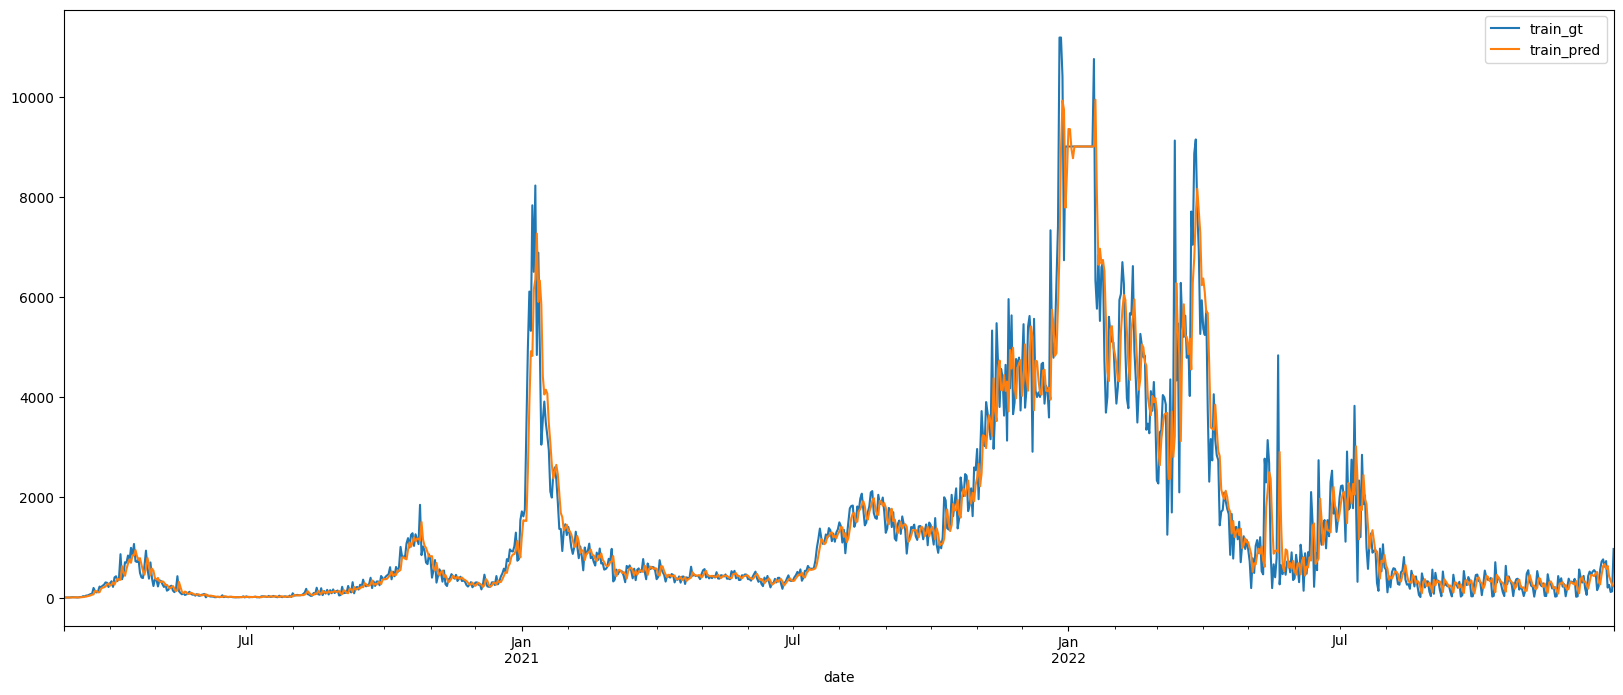

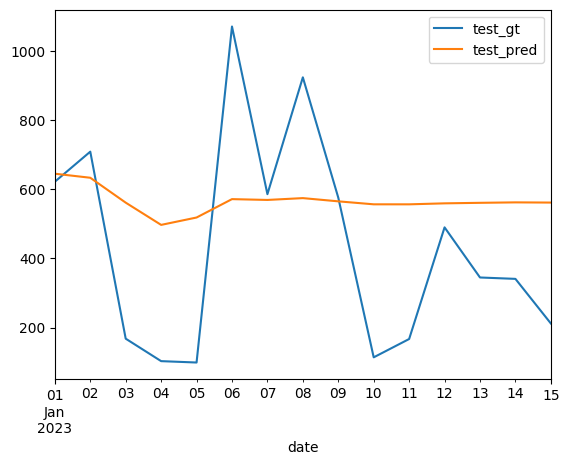

In [134]:
ireland_df = stationary_df[stationary_df['location'] == 'Ireland']
train_size = 0.98667935  
ireland_split = int(len(ireland_df) * train_size)
ireland_train = ireland_df.iloc[:ireland_split]
ireland_test = ireland_df.iloc[ireland_split:]

ireland_train = ireland_train.drop(columns = ['location'])
ireland_test = ireland_test.drop(columns = ['location'])

model = ARIMA(ireland_train, order=(5, 1, 0))
model = model.fit()
train_pred=model.fittedvalues
train_pred.index = ireland_train.index
pd.concat([ireland_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
test_pred = model.predict(start=len(ireland_train), end=len(ireland_train)+len(ireland_test)-1, dynamic=True)
test_pred.index = ireland_test.index
pd.concat([ireland_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
train_rmse = np.sqrt(mean_squared_error(ireland_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(ireland_test, test_pred))
test_srmse = test_rmse / np.mean(ireland_test) * 100

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Test sRMSE: {test_srmse}')

ireland_train_rmse = train_rmse
ireland_test_rmse = test_rmse
ireland_test_srmse = test_srmse

2. Italy

/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Train RMSE: 9725.273045882184
Test RMSE: 9945.403956913791
Test sRMSE: 70.21937366613645


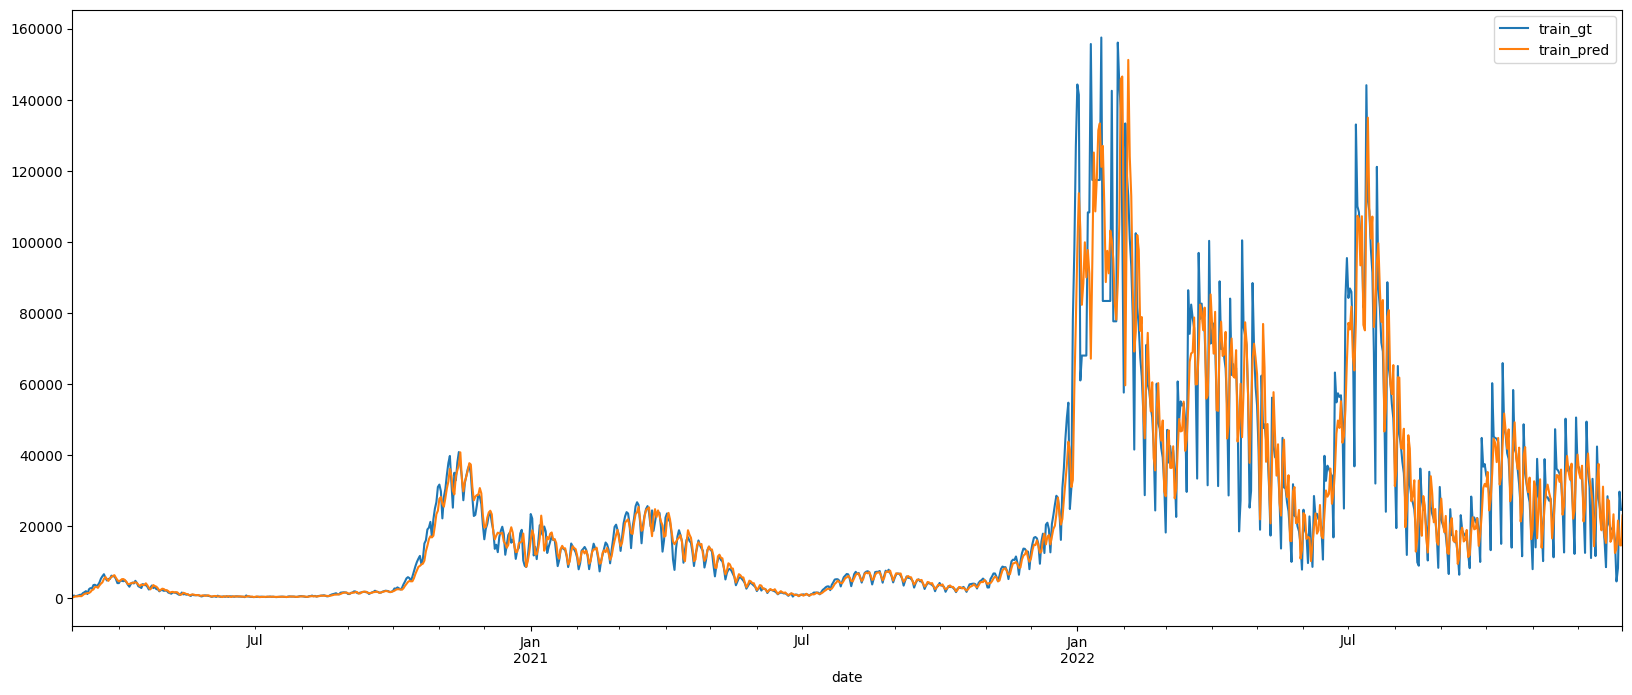

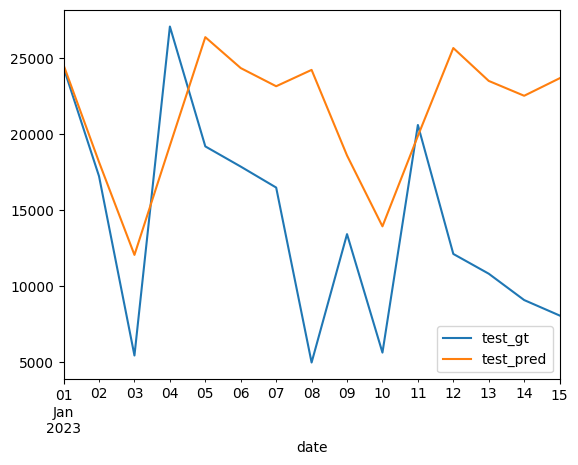

In [135]:
italy_df = stationary_df[stationary_df['location'] == 'Italy']
train_size = 0.98667935  
italy_split = int(len(italy_df) * train_size)
italy_train = italy_df.iloc[:italy_split]
italy_test = italy_df.iloc[italy_split:]

italy_train = italy_train.drop(columns = ['location'])
italy_test = italy_test.drop(columns = ['location'])

model = ARIMA(italy_train, order=(5, 1, 5))
model = model.fit()
train_pred=model.fittedvalues
train_pred.index = italy_train.index
pd.concat([italy_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
test_pred = model.predict(start=len(italy_train), end=len(italy_train)+len(italy_test)-1, dynamic=True)
test_pred.index = italy_test.index
pd.concat([italy_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
train_rmse = np.sqrt(mean_squared_error(italy_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(italy_test, test_pred))
test_srmse = test_rmse / np.mean(italy_test) * 100

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Test sRMSE: {test_srmse}')

italy_train_rmse = train_rmse
italy_test_rmse = test_rmse
italy_test_srmse = test_srmse

3. Lithuania

/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Train RMSE: 362.6075435603071
Test RMSE: 182.40700198398503
Test sRMSE: 65.6140294906421


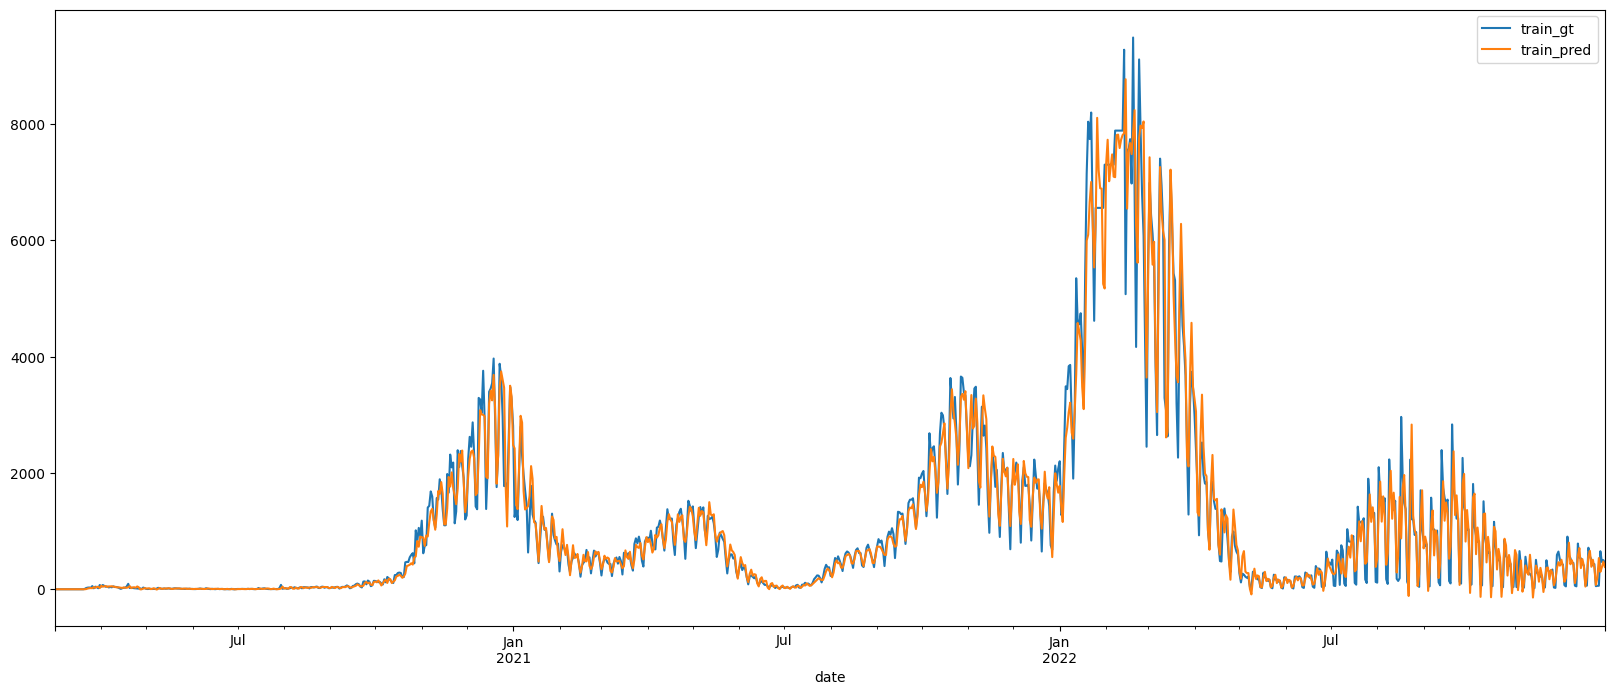

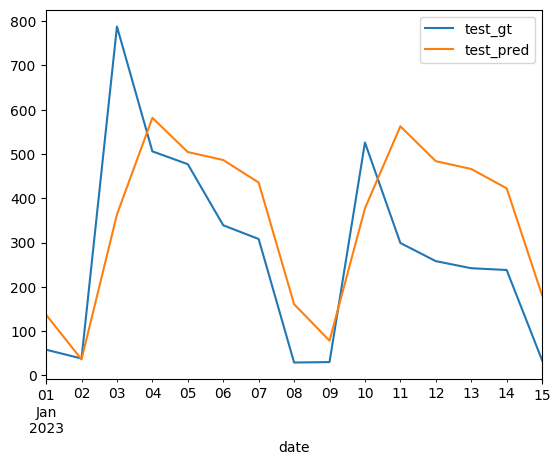

In [136]:
lithuania_df = stationary_df[stationary_df['location'] == 'Lithuania']
train_size = 0.98667935  
lithuania_split = int(len(lithuania_df) * train_size)
lithuania_train = lithuania_df.iloc[:lithuania_split]
lithuania_test = lithuania_df.iloc[lithuania_split:]

lithuania_train = lithuania_train.drop(columns = ['location'])
lithuania_test = lithuania_test.drop(columns = ['location'])

model = ARIMA(lithuania_train, order=(5, 1, 4))
model = model.fit()
train_pred=model.fittedvalues
train_pred.index = lithuania_train.index
pd.concat([lithuania_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
test_pred = model.predict(start=len(lithuania_train), end=len(lithuania_train)+len(lithuania_test)-1, dynamic=True)
test_pred.index = lithuania_test.index
pd.concat([lithuania_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
train_rmse = np.sqrt(mean_squared_error(lithuania_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(lithuania_test, test_pred))
test_srmse = test_rmse / np.mean(lithuania_test) * 100

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Test sRMSE: {test_srmse}')

lithuania_train_rmse = train_rmse
lithuania_test_rmse = test_rmse
lithuania_test_srmse = test_srmse

4. Poland

/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Train RMSE: 1561.500404549302
Test RMSE: 225.5957476900502
Test sRMSE: 69.81506530535904


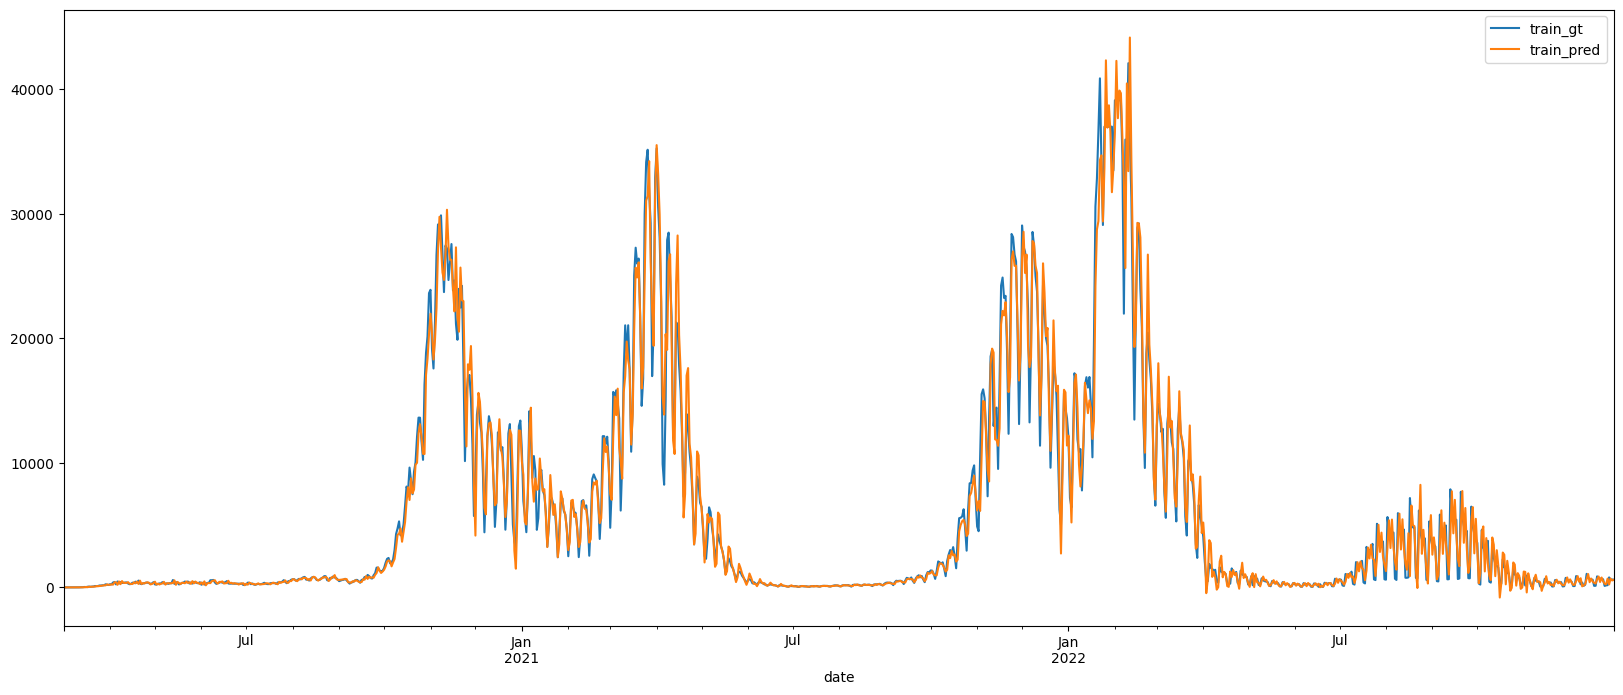

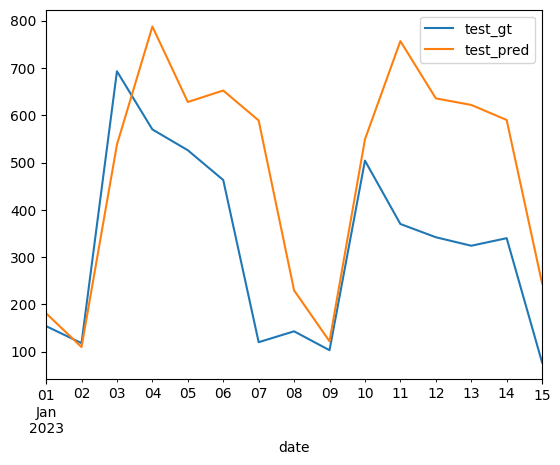

In [137]:
poland_df = stationary_df[stationary_df['location'] == 'Poland']
train_size = 0.98667935  
poland_split = int(len(poland_df) * train_size)
poland_train = poland_df.iloc[:poland_split]
poland_test = poland_df.iloc[poland_split:]

poland_train = poland_train.drop(columns = ['location'])
poland_test = poland_test.drop(columns = ['location'])

model = ARIMA(poland_train, order=(5, 1, 5))
model = model.fit()
train_pred=model.fittedvalues
train_pred.index = poland_train.index
pd.concat([poland_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
test_pred = model.predict(start=len(poland_train), end=len(poland_train)+len(poland_test)-1, dynamic=True)
test_pred.index = poland_test.index
pd.concat([poland_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
train_rmse = np.sqrt(mean_squared_error(poland_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(poland_test, test_pred))
test_srmse = test_rmse / np.mean(poland_test) * 100

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Test sRMSE: {test_srmse}')

poland_train_rmse = train_rmse
poland_test_rmse = test_rmse
poland_test_srmse = test_srmse

5. United Kingdom

/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Train RMSE: 4606.358365921921
Test RMSE: 3270.860462914607
Test sRMSE: 83.09690724339737


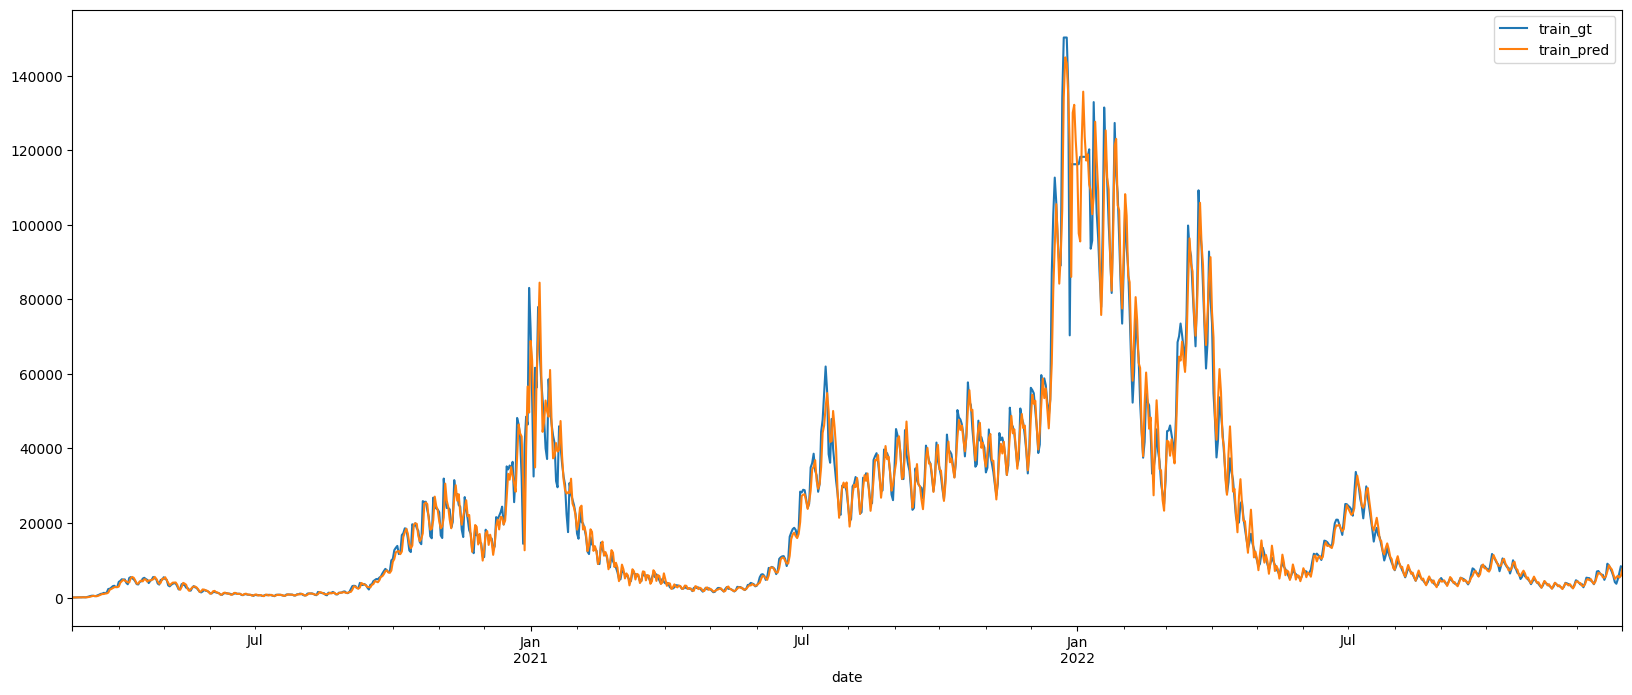

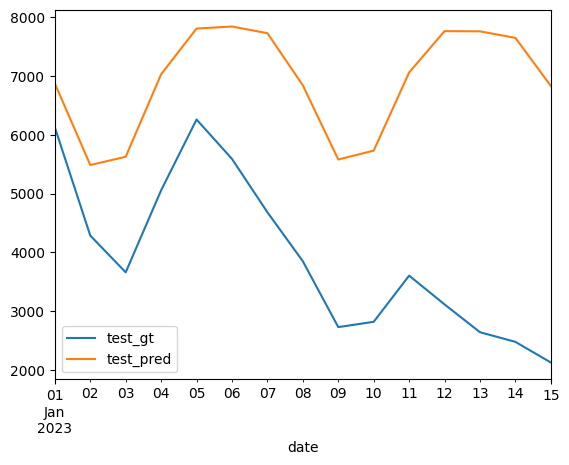

In [138]:
uk_df = stationary_df[stationary_df['location'] == 'United Kingdom']
train_size = 0.98667935  
uk_split = int(len(uk_df) * train_size)
uk_train = uk_df.iloc[:uk_split]
uk_test = uk_df.iloc[uk_split:]

uk_train = uk_train.drop(columns = ['location'])
uk_test = uk_test.drop(columns = ['location'])

model = ARIMA(uk_train, order=(5, 1, 5))
model = model.fit()
train_pred=model.fittedvalues
train_pred.index = uk_train.index
pd.concat([uk_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
test_pred = model.predict(start=len(uk_train), end=len(uk_train)+len(uk_test)-1, dynamic=True)
test_pred.index = uk_test.index
pd.concat([uk_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])

train_rmse = np.sqrt(mean_squared_error(uk_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(uk_test, test_pred))
test_srmse = test_rmse / np.mean(uk_test) * 100

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Test sRMSE: {test_srmse}')

uk_train_rmse = train_rmse
uk_test_rmse = test_rmse
uk_test_srmse = test_srmse

### II. Non-Stationary

6. Belgium

/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


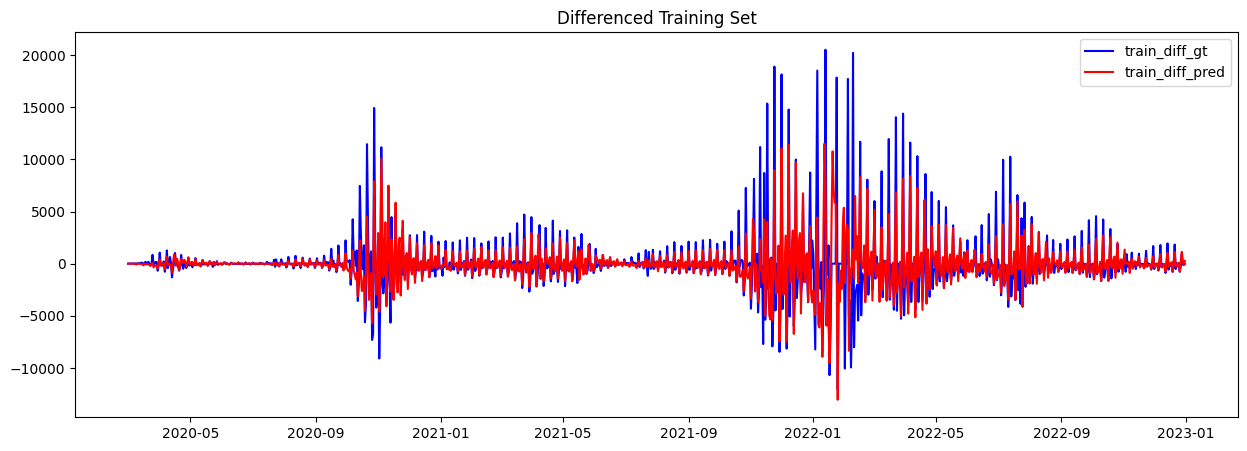

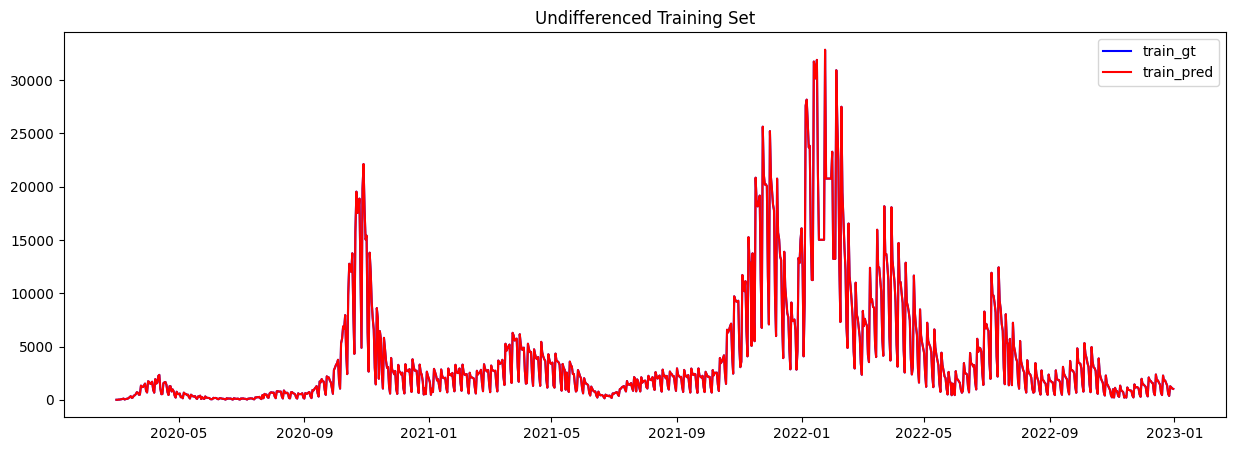

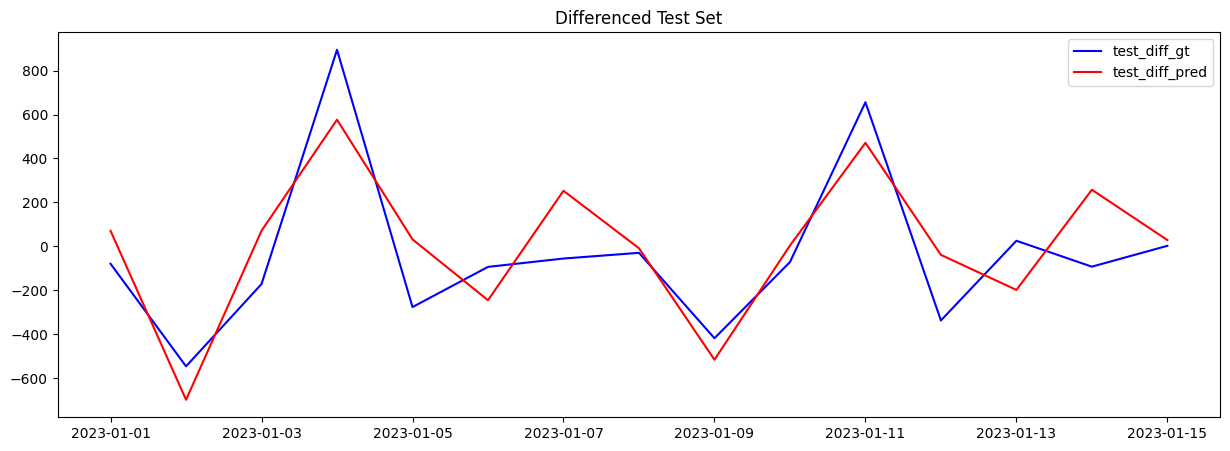

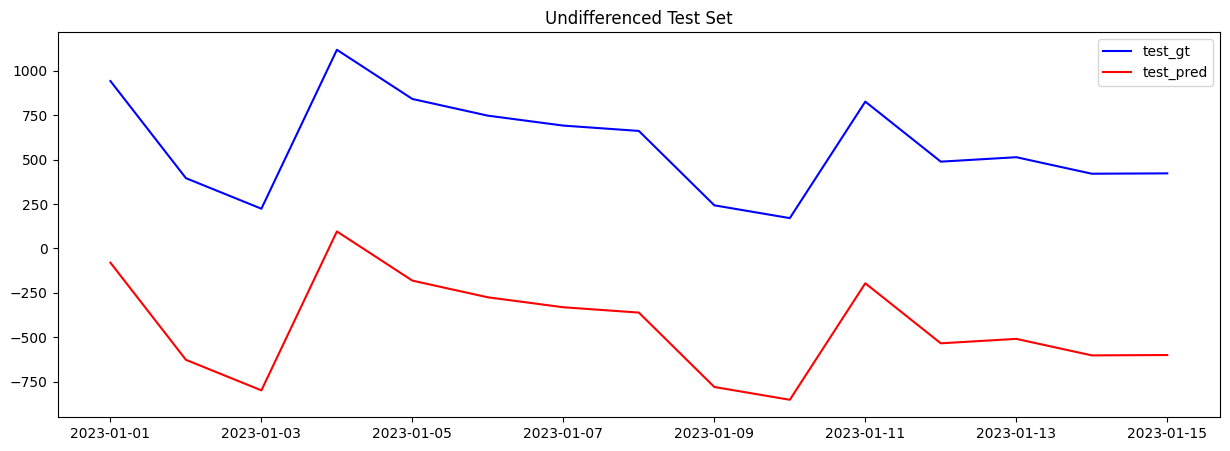

Train RMSE: 6754.471563227992
Test RMSE: 494.9595943104851


In [139]:
belgium_df = differenced_df[differenced_df['location'] == 'Belgium']
train_size = 0.98667935
belgium_split = int(len(belgium_df) * train_size)
belgium_train = belgium_df.iloc[:belgium_split]
belgium_test = belgium_df.iloc[belgium_split:]

# Fit the ARIMA model on the differenced data
model = ARIMA(belgium_train['new_cases_diff'], order=(5, 0, 4))
model = model.fit()

# Get predictions on the differenced training set
train_pred_diff = model.fittedvalues

# Construct the differenced DataFrame for training set
differenced_train = belgium_train.copy()
differenced_train['new_cases_pred_diff'] = train_pred_diff

# Plot differenced training set
plt.figure(figsize=(15, 5))
plt.plot(differenced_train['new_cases_diff'], label='train_diff_gt', color='blue')
plt.plot(train_pred_diff, label='train_diff_pred', color='red')
plt.legend()
plt.title('Differenced Training Set')
plt.show()

# Undifference the training predictions
train_pred = differenced_train['new_cases_diff'].cumsum()

# Construct the undifferenced DataFrame for training set
undifferenced_train = belgium_train.copy()
undifferenced_train['new_cases_pred'] = train_pred

# Plot undifferenced training set
plt.figure(figsize=(15, 5))
plt.plot(undifferenced_train['new_cases'], label='train_gt', color='blue')
plt.plot(train_pred, label='train_pred', color='red')
plt.legend()
plt.title('Undifferenced Training Set')
plt.show()

# Get predictions on the differenced test set
test_pred_diff = model.predict(start=len(belgium_train), end=len(belgium_train) + len(belgium_test) - 1, dynamic=True)

# Construct the differenced DataFrame for test set
differenced_test = belgium_test.copy()
differenced_test['new_cases_pred_diff'] = test_pred_diff

# Plot differenced test set
plt.figure(figsize=(15, 5))
plt.plot(differenced_test['new_cases_diff'], label='test_diff_gt', color='blue')
plt.plot(test_pred_diff, label='test_diff_pred', color='red')
plt.legend()
plt.title('Differenced Test Set')
plt.show()

# Undifference the test predictions
test_pred = differenced_test['new_cases_diff'].cumsum()

# Construct the undifferenced DataFrame for test set
undifferenced_test = belgium_test.copy()
undifferenced_test['new_cases_pred'] = test_pred

# Plot undifferenced test set
plt.figure(figsize=(15, 5))
plt.plot(undifferenced_test['new_cases'], label='test_gt', color='blue')
plt.plot(test_pred, label='test_pred', color='red')
plt.legend()
plt.title('Undifferenced Test Set')
plt.show()

# Calculate RMSE for training and test sets
train_rmse = np.sqrt(mean_squared_error(differenced_train['new_cases_diff'], train_pred))
test_rmse = np.sqrt(mean_squared_error(differenced_test['new_cases_diff'], test_pred))
test_srmse = test_rmse / np.mean(differenced_test['new_cases_diff']) * 100

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

belgium_train_rmse = train_rmse
belgium_test_rmse = test_rmse
belgium_test_srmse = test_srmse

7. Denmark

/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


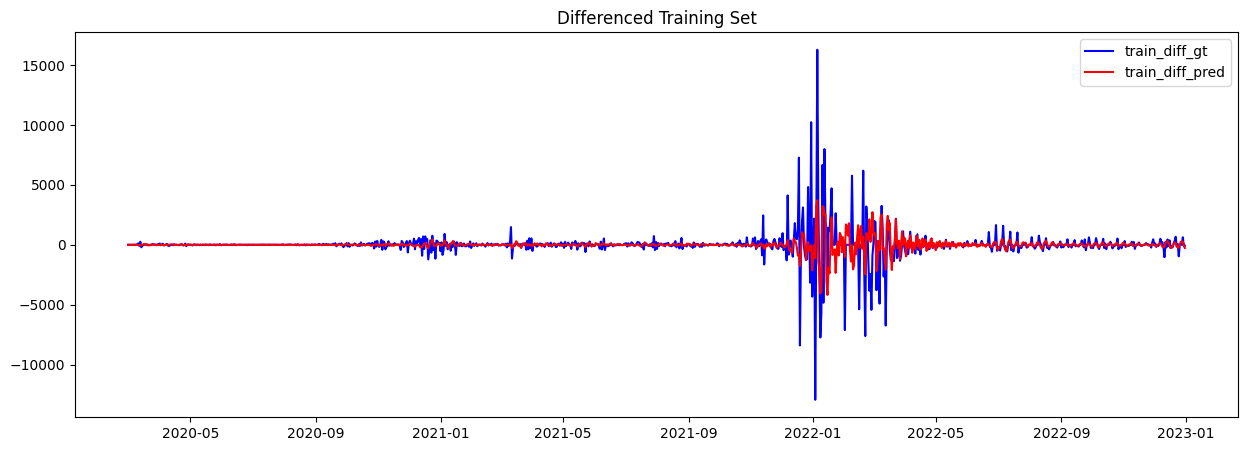

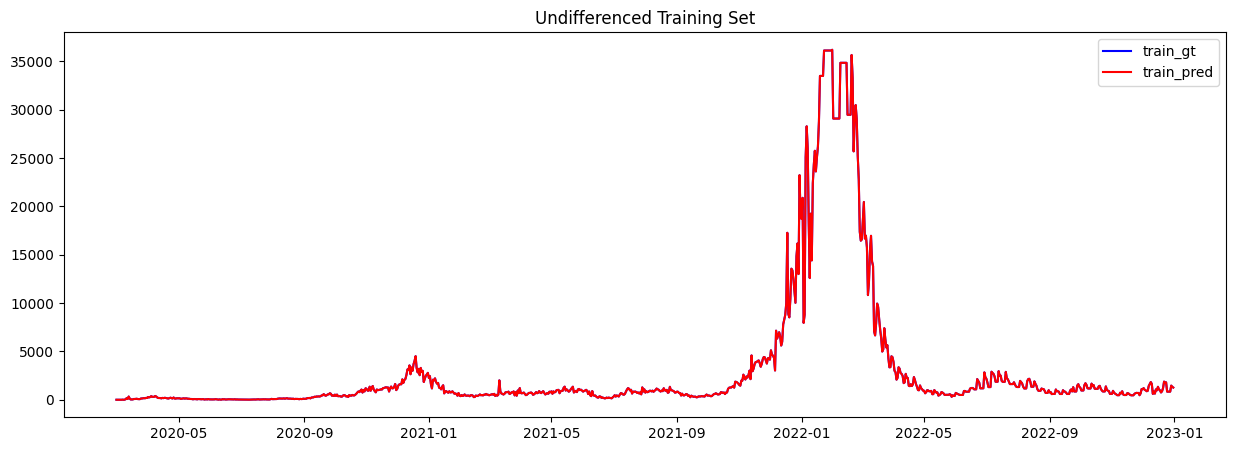

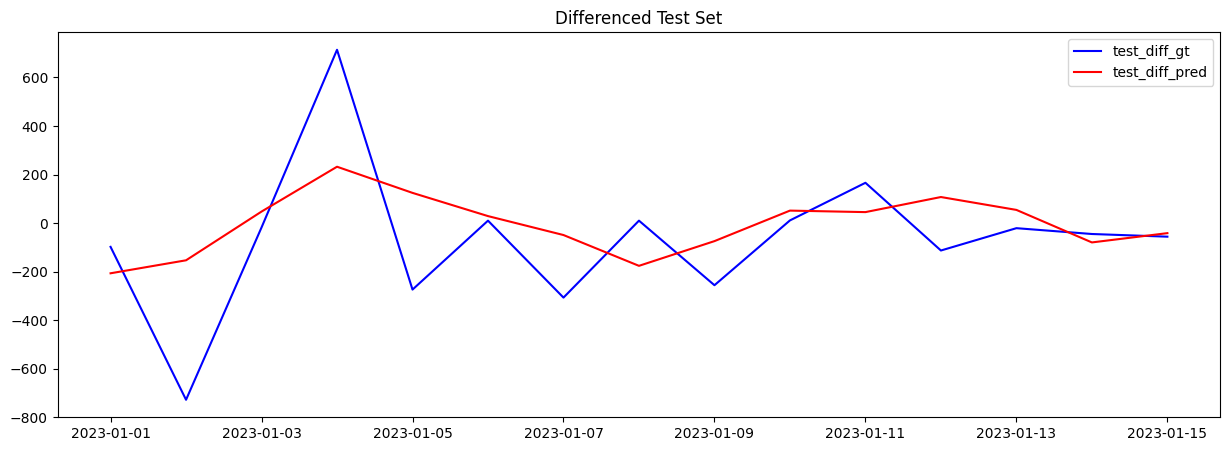

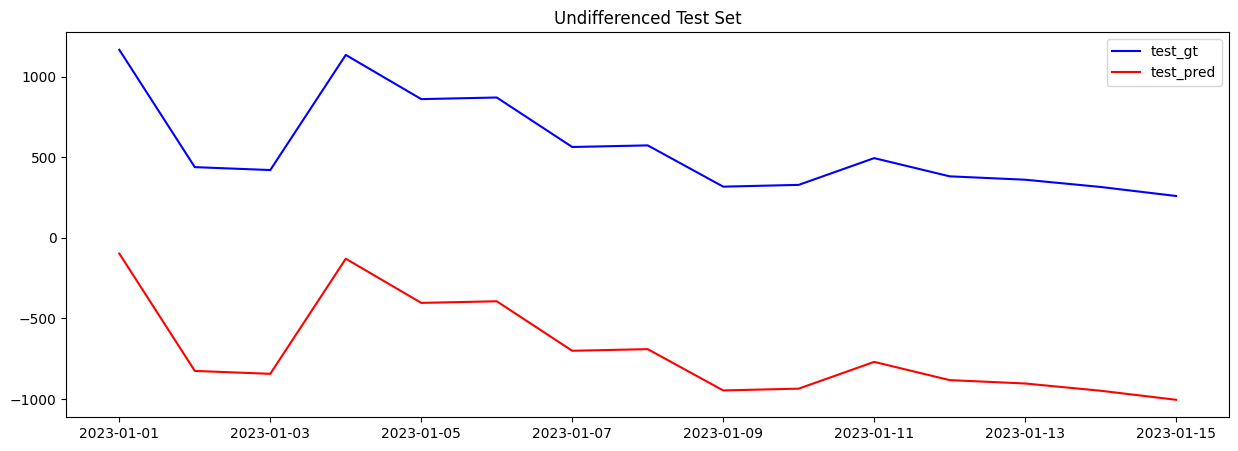

Train RMSE: 7535.096119295827
Test RMSE: 710.4815737699794
Test sRMSE: -1060.420259358178


In [140]:
denmark_df = differenced_df[differenced_df['location'] == 'Denmark']
train_size = 0.98667935
denmark_split = int(len(denmark_df) * train_size)
denmark_train = denmark_df.iloc[:denmark_split]
denmark_test = denmark_df.iloc[denmark_split:]

# Fit the ARIMA model on the differenced data
model = ARIMA(denmark_train['new_cases_diff'], order=(4, 0, 4))
model = model.fit()

# Get predictions on the differenced training set
train_pred_diff = model.fittedvalues

# Construct the differenced DataFrame for training set
differenced_train = denmark_train.copy()
differenced_train['new_cases_pred_diff'] = train_pred_diff

# Plot differenced training set
plt.figure(figsize=(15, 5))
plt.plot(denmark_train['new_cases_diff'], label='train_diff_gt', color='blue')
plt.plot(train_pred_diff, label='train_diff_pred', color='red')
plt.legend()
plt.title('Differenced Training Set')
plt.show()

# Undifference the training predictions
train_pred = differenced_train['new_cases_diff'].cumsum()

# Construct the undifferenced DataFrame for training set
undifferenced_train = denmark_train.copy()
undifferenced_train['new_cases_pred'] = train_pred

# Plot undifferenced training set
plt.figure(figsize=(15, 5))
plt.plot(undifferenced_train['new_cases'], label='train_gt', color='blue')
plt.plot(train_pred, label='train_pred', color='red')
plt.legend()
plt.title('Undifferenced Training Set')
plt.show()

# Get predictions on the differenced test set
test_pred_diff = model.predict(start=len(denmark_train), end=len(denmark_train) + len(denmark_test) - 1, dynamic=True)

# Construct the differenced DataFrame for test set
differenced_test = denmark_test.copy()
differenced_test['new_cases_pred_diff'] = test_pred_diff

# Plot differenced test set
plt.figure(figsize=(15, 5))
plt.plot(differenced_test['new_cases_diff'], label='test_diff_gt', color='blue')
plt.plot(test_pred_diff, label='test_diff_pred', color='red')
plt.legend()
plt.title('Differenced Test Set')
plt.show()

# Undifference the test predictions
test_pred = differenced_test['new_cases_diff'].cumsum()

# Construct the undifferenced DataFrame for test set
undifferenced_test = denmark_test.copy()
undifferenced_test['new_cases_pred'] = test_pred

# Plot undifferenced test set
plt.figure(figsize=(15, 5))
plt.plot(undifferenced_test['new_cases'], label='test_gt', color='blue')
plt.plot(test_pred, label='test_pred', color='red')
plt.legend()
plt.title('Undifferenced Test Set')
plt.show()

# Calculate RMSE for training and test sets
train_rmse = np.sqrt(mean_squared_error(differenced_train['new_cases_diff'], train_pred))
test_rmse = np.sqrt(mean_squared_error(differenced_test['new_cases_diff'], test_pred))
test_srmse = test_rmse / np.mean(differenced_test['new_cases_diff']) * 100

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Test sRMSE: {test_srmse}')

denmark_train_rmse = train_rmse
denmark_test_rmse = test_rmse
denmark_test_srmse = test_srmse

8. Finland

/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


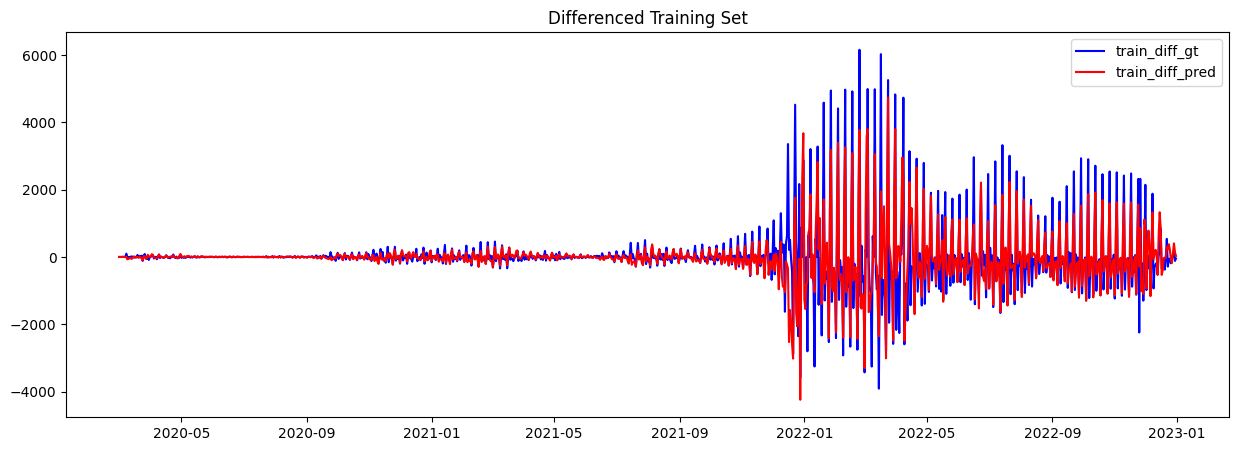

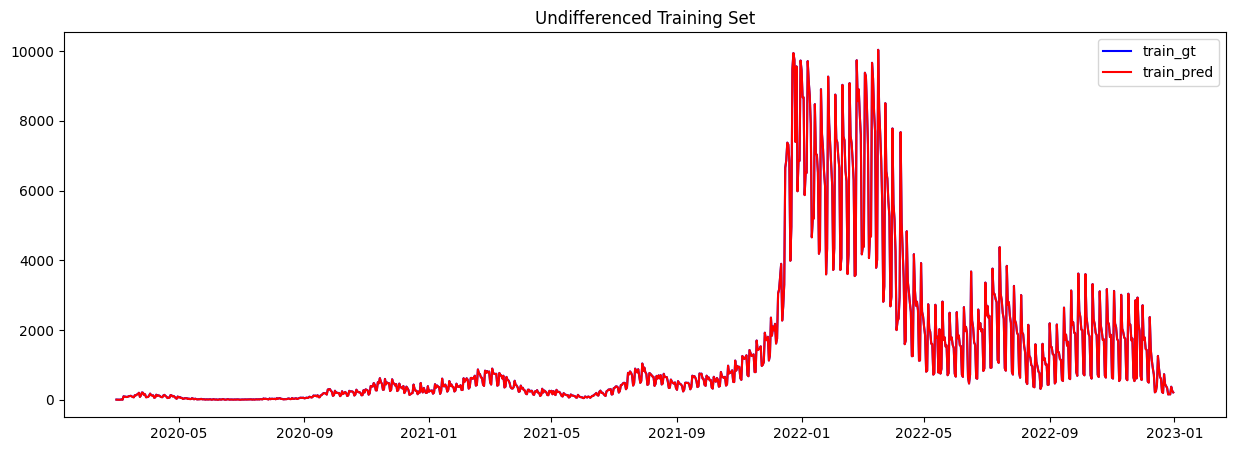

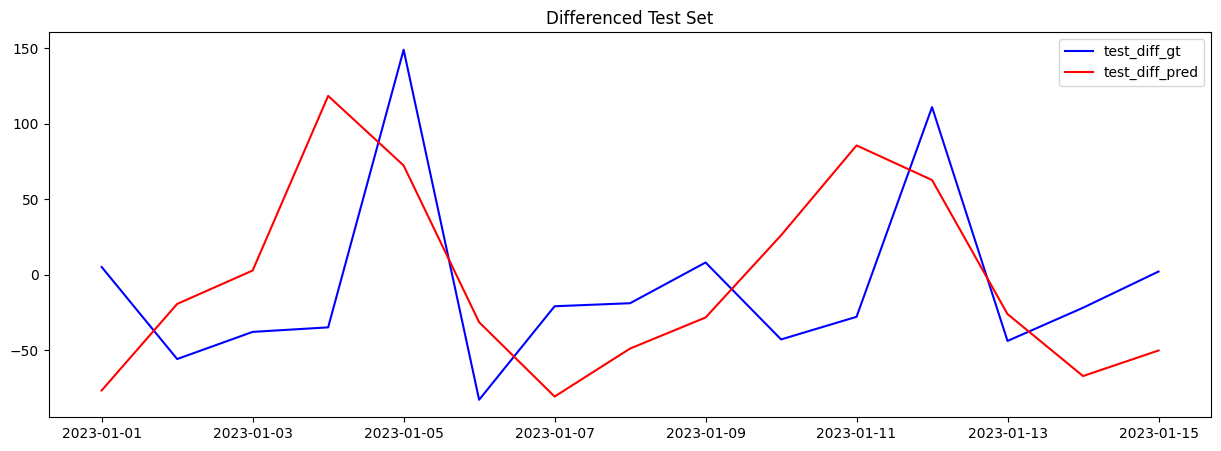

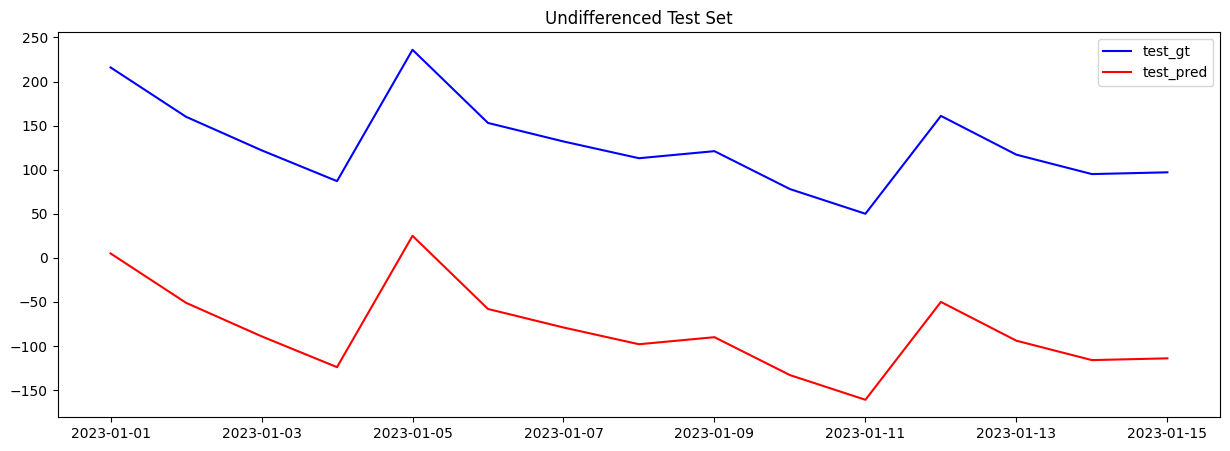

Train RMSE: 2523.1975146382115
Test RMSE: 90.28067345783371
Test sRMSE: -1187.903598129391


In [141]:
finland_df = differenced_df[differenced_df['location'] == 'Finland']
train_size = 0.98667935
finland_split = int(len(finland_df) * train_size)
finland_train = finland_df.iloc[:finland_split]
finland_test = finland_df.iloc[finland_split:]

# Fit the ARIMA model on the differenced data
model = ARIMA(finland_train['new_cases_diff'], order=(5, 0, 3))
model = model.fit()

# Get predictions on the differenced training set
train_pred_diff = model.fittedvalues

# Construct the differenced DataFrame for training set
differenced_train = finland_train.copy()
differenced_train['new_cases_pred_diff'] = train_pred_diff

# Plot differenced training set
plt.figure(figsize=(15, 5))
plt.plot(finland_train['new_cases_diff'], label='train_diff_gt', color='blue')
plt.plot(train_pred_diff, label='train_diff_pred', color='red')
plt.legend()
plt.title('Differenced Training Set')
plt.show()

# Undifference the training predictions
train_pred = differenced_train['new_cases_diff'].cumsum()

# Construct the undifferenced DataFrame for training set
undifferenced_train = finland_train.copy()
undifferenced_train['new_cases_pred'] = train_pred

# Plot undifferenced training set
plt.figure(figsize=(15, 5))
plt.plot(undifferenced_train['new_cases'], label='train_gt', color='blue')
plt.plot(train_pred, label='train_pred', color='red')
plt.legend()
plt.title('Undifferenced Training Set')
plt.show()

# Get predictions on the differenced test set
test_pred_diff = model.predict(start=len(finland_train), end=len(finland_train) + len(finland_test) - 1, dynamic=True)

# Construct the differenced DataFrame for test set
differenced_test = finland_test.copy()
differenced_test['new_cases_pred_diff'] = test_pred_diff

# Plot differenced test set
plt.figure(figsize=(15, 5))
plt.plot(differenced_test['new_cases_diff'], label='test_diff_gt', color='blue')
plt.plot(test_pred_diff, label='test_diff_pred', color='red')
plt.legend()
plt.title('Differenced Test Set')
plt.show()

# Undifference the test predictions
test_pred = differenced_test['new_cases_diff'].cumsum()

# Construct the undifferenced DataFrame for test set
undifferenced_test = finland_test.copy()
undifferenced_test['new_cases_pred'] = test_pred

# Plot undifferenced test set
plt.figure(figsize=(15, 5))
plt.plot(undifferenced_test['new_cases'], label='test_gt', color='blue')
plt.plot(test_pred, label='test_pred', color='red')
plt.legend()
plt.title('Undifferenced Test Set')
plt.show()

# Calculate RMSE for training and test sets
train_rmse = np.sqrt(mean_squared_error(differenced_train['new_cases_diff'], train_pred))
test_rmse = np.sqrt(mean_squared_error(differenced_test['new_cases_diff'], test_pred))
test_srmse = test_rmse / np.mean(differenced_test['new_cases_diff']) * 100

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Test sRMSE: {test_srmse}')

finland_train_rmse = train_rmse
finland_test_rmse = test_rmse
finland_test_srmse = test_srmse

9. Norway

/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


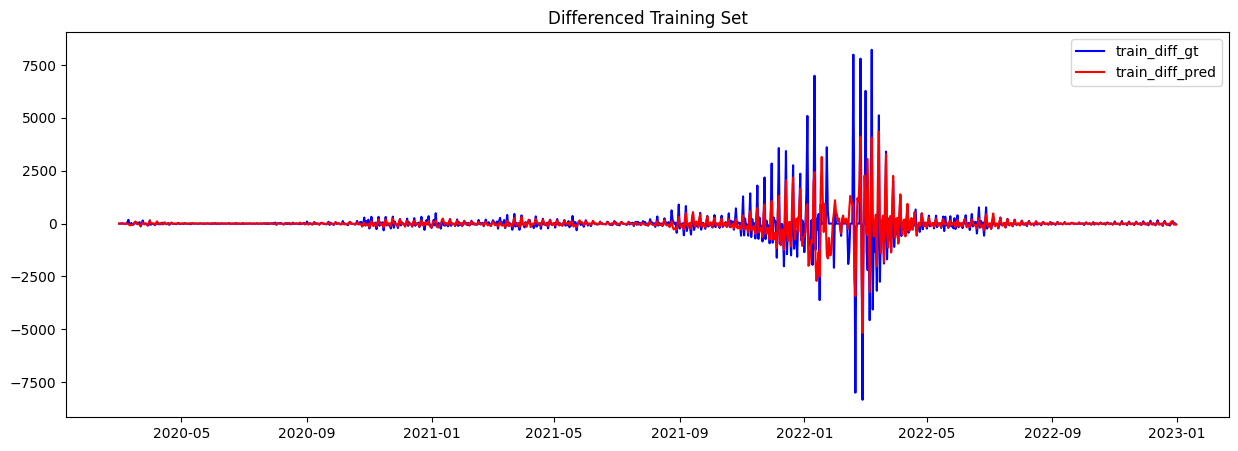

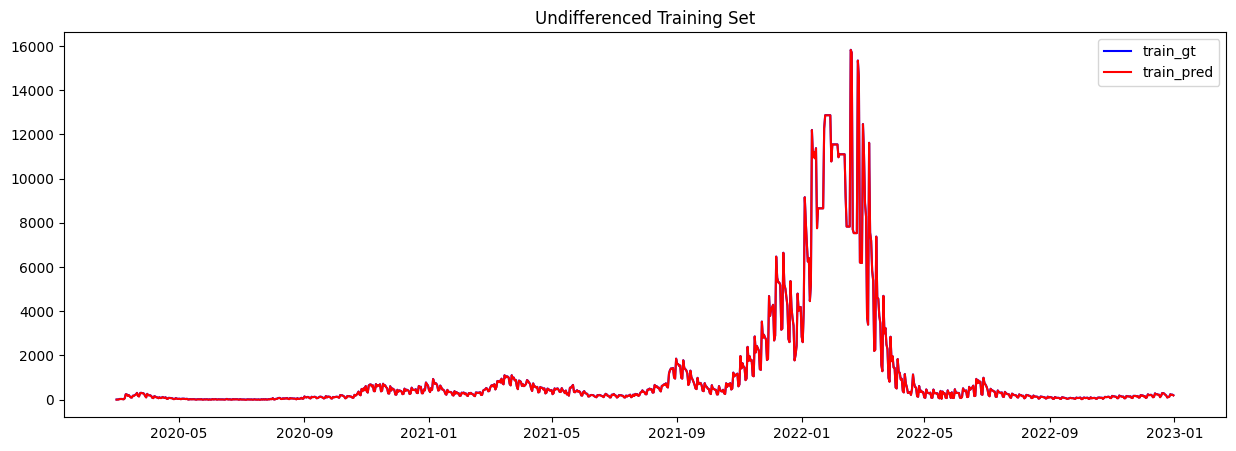

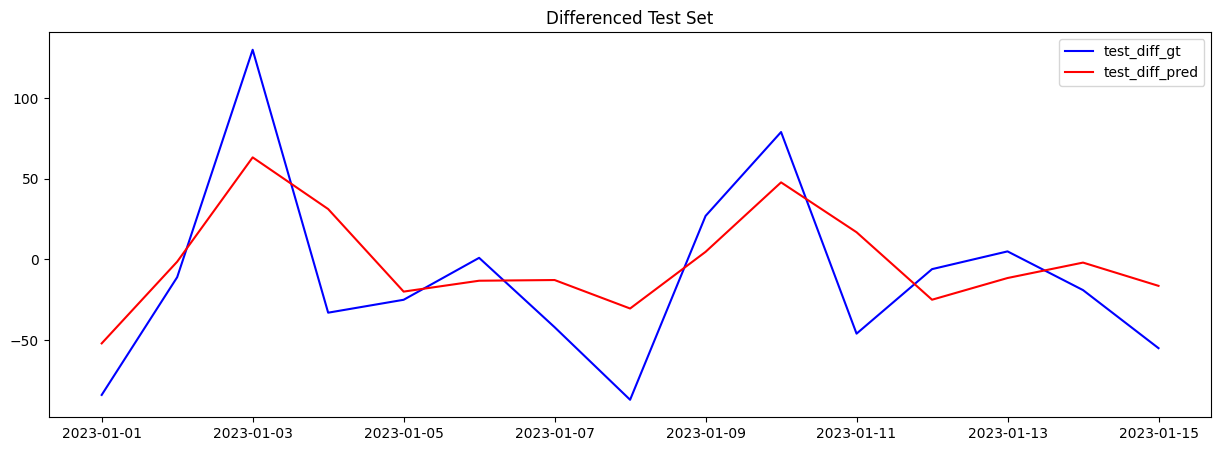

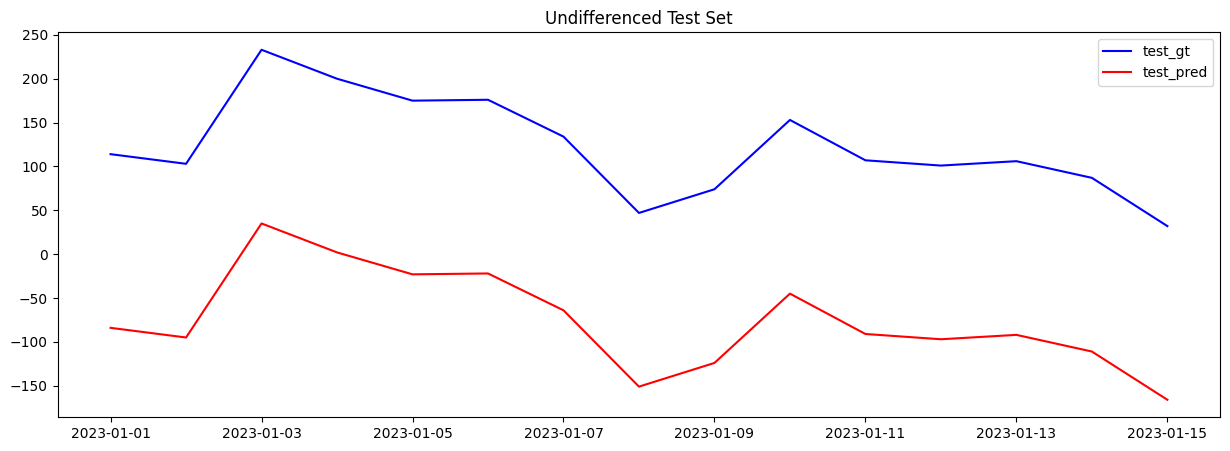

Train RMSE: 2768.1531927361966
Test RMSE: 82.09587890590693
Test sRMSE: -741.8302310774723


In [142]:
norway_df = differenced_df[differenced_df['location'] == 'Norway']
train_size = 0.98667935
norway_split = int(len(norway_df) * train_size)
norway_train = norway_df.iloc[:norway_split]
norway_test = norway_df.iloc[norway_split:]

# Fit the ARIMA model on the differenced data
model = ARIMA(norway_train['new_cases_diff'], order=(5, 0, 4))
model = model.fit()

# Get predictions on the differenced training set
train_pred_diff = model.fittedvalues

# Construct the differenced DataFrame for training set
differenced_train = norway_train.copy()
differenced_train['new_cases_pred_diff'] = train_pred_diff

# Plot differenced training set
plt.figure(figsize=(15, 5))
plt.plot(norway_train['new_cases_diff'], label='train_diff_gt', color='blue')
plt.plot(train_pred_diff, label='train_diff_pred', color='red')
plt.legend()
plt.title('Differenced Training Set')
plt.show()

# Undifference the training predictions
train_pred = differenced_train['new_cases_diff'].cumsum()

# Construct the undifferenced DataFrame for training set
undifferenced_train = norway_train.copy()
undifferenced_train['new_cases_pred'] = train_pred

# Plot undifferenced training set
plt.figure(figsize=(15, 5))
plt.plot(undifferenced_train['new_cases'], label='train_gt', color='blue')
plt.plot(train_pred, label='train_pred', color='red')
plt.legend()
plt.title('Undifferenced Training Set')
plt.show()

# Get predictions on the differenced test set
test_pred_diff = model.predict(start=len(norway_train), end=len(norway_train) + len(norway_test) - 1, dynamic=True)

# Construct the differenced DataFrame for test set
differenced_test = norway_test.copy()
differenced_test['new_cases_pred_diff'] = test_pred_diff

# Plot differenced test set
plt.figure(figsize=(15, 5))
plt.plot(differenced_test['new_cases_diff'], label='test_diff_gt', color='blue')
plt.plot(test_pred_diff, label='test_diff_pred', color='red')
plt.legend()
plt.title('Differenced Test Set')
plt.show()

# Undifference the test predictions
test_pred = differenced_test['new_cases_diff'].cumsum()

# Construct the undifferenced DataFrame for test set
undifferenced_test = norway_test.copy()
undifferenced_test['new_cases_pred'] = test_pred

# Plot undifferenced test set
plt.figure(figsize=(15, 5))
plt.plot(undifferenced_test['new_cases'], label='test_gt', color='blue')
plt.plot(test_pred, label='test_pred', color='red')
plt.legend()
plt.title('Undifferenced Test Set')
plt.show()


train_rmse = np.sqrt(mean_squared_error(differenced_train['new_cases_diff'], train_pred))
test_rmse = np.sqrt(mean_squared_error(differenced_test['new_cases_diff'], test_pred))
test_srmse = test_rmse / np.mean(differenced_test['new_cases_diff']) * 100

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Test sRMSE: {test_srmse}')

norway_train_rmse = train_rmse
norway_test_rmse = test_rmse
norway_test_srmse = test_srmse

Both ACF and PACF tail off - hard to manually find p & q (without doing it by hand)
Will use auto-ARIMA inputs: ARIMA (0, 1, 0) - random walk

10. Switzerland

/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


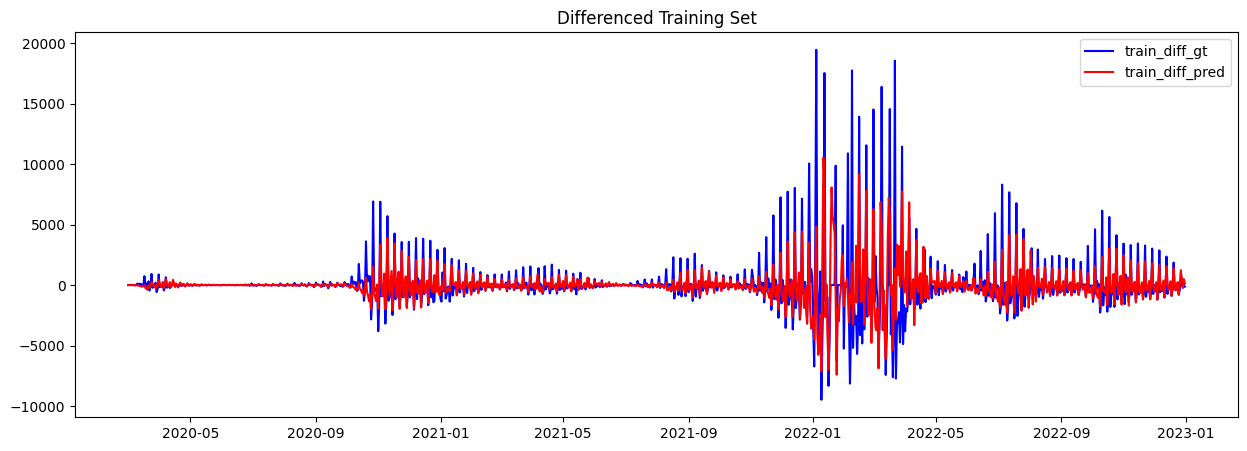

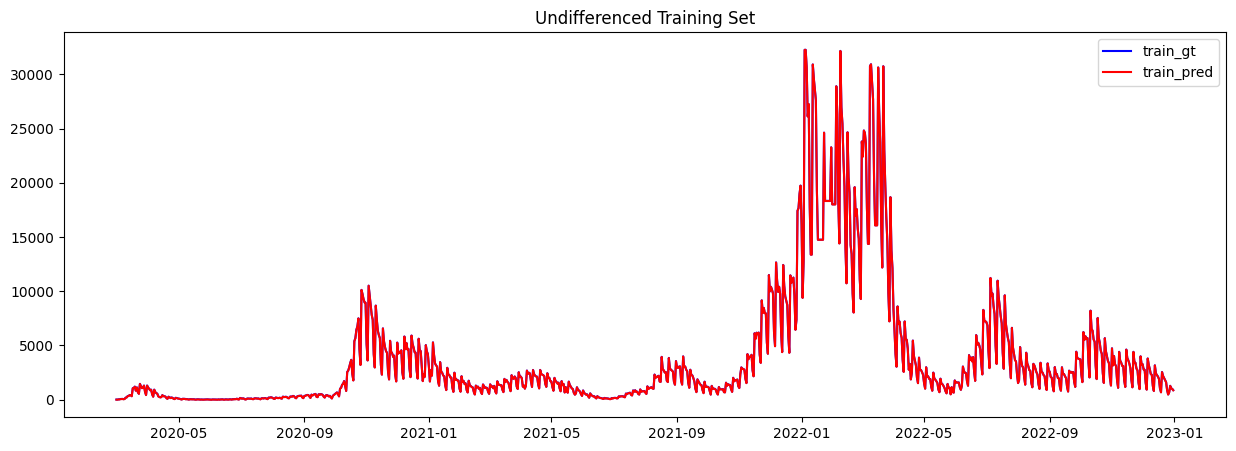

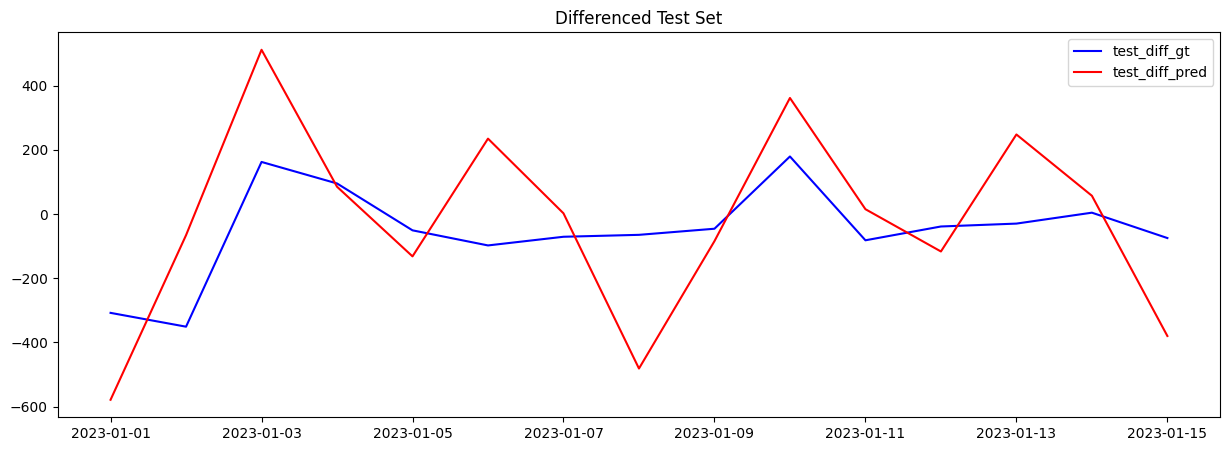

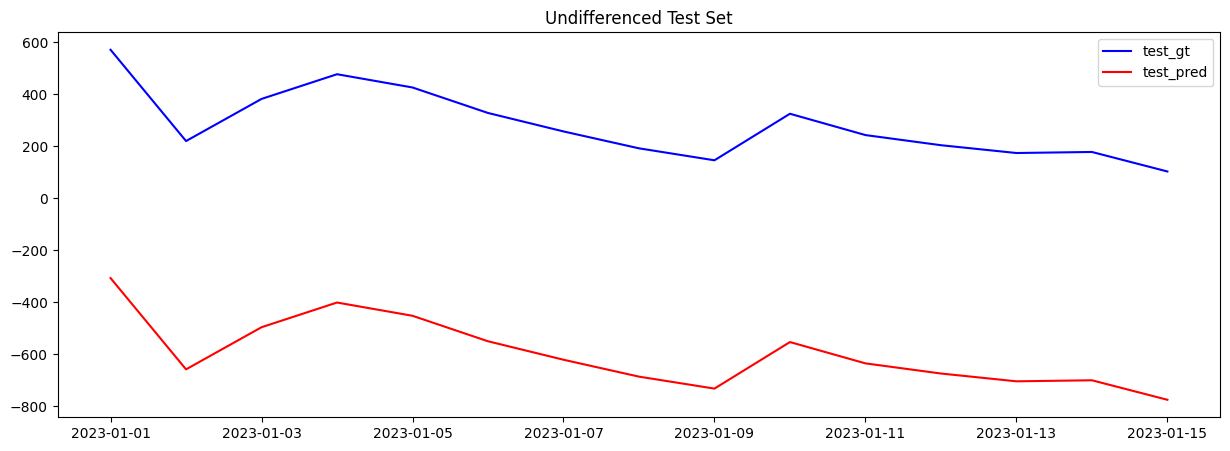

Train RMSE: 6971.356724699403
Test RMSE: 577.2447776579129
Test sRMSE: -1115.8082042356564


In [143]:
switzerland_df = differenced_df[differenced_df['location'] == 'Switzerland']
train_size = 0.98667935
switzerland_split = int(len(switzerland_df) * train_size)
switzerland_train = switzerland_df.iloc[:switzerland_split]
switzerland_test = switzerland_df.iloc[switzerland_split:]

# Fit the ARIMA model on the differenced data
model = ARIMA(switzerland_train['new_cases_diff'], order=(5, 0, 4))
model = model.fit()

# Get predictions on the differenced training set
train_pred_diff = model.fittedvalues

# Construct the differenced DataFrame for training set
differenced_train = switzerland_train.copy()
differenced_train['new_cases_pred_diff'] = train_pred_diff

# Plot differenced training set
plt.figure(figsize=(15, 5))
plt.plot(switzerland_train['new_cases_diff'], label='train_diff_gt', color='blue')
plt.plot(train_pred_diff, label='train_diff_pred', color='red')
plt.legend()
plt.title('Differenced Training Set')
plt.show()

# Undifference the training predictions
train_pred = differenced_train['new_cases_diff'].cumsum()

# Construct the undifferenced DataFrame for training set
undifferenced_train = switzerland_train.copy()
undifferenced_train['new_cases_pred'] = train_pred

# Plot undifferenced training set
plt.figure(figsize=(15, 5))
plt.plot(undifferenced_train['new_cases'], label='train_gt', color='blue')
plt.plot(train_pred, label='train_pred', color='red')
plt.legend()
plt.title('Undifferenced Training Set')
plt.show()

# Get predictions on the differenced test set
test_pred_diff = model.predict(start=len(switzerland_train), end=len(switzerland_train) + len(switzerland_test) - 1, dynamic=True)

# Construct the differenced DataFrame for test set
differenced_test = switzerland_test.copy()
differenced_test['new_cases_pred_diff'] = test_pred_diff

# Plot differenced test set
plt.figure(figsize=(15, 5))
plt.plot(differenced_test['new_cases_diff'], label='test_diff_gt', color='blue')
plt.plot(test_pred_diff, label='test_diff_pred', color='red')
plt.legend()
plt.title('Differenced Test Set')
plt.show()

# Undifference the test predictions
test_pred = differenced_test['new_cases_diff'].cumsum()

# Construct the undifferenced DataFrame for test set
undifferenced_test = switzerland_test.copy()
undifferenced_test['new_cases_pred'] = test_pred

# Plot undifferenced test set
plt.figure(figsize=(15, 5))
plt.plot(undifferenced_test['new_cases'], label='test_gt', color='blue')
plt.plot(test_pred, label='test_pred', color='red')
plt.legend()
plt.title('Undifferenced Test Set')
plt.show()

# Calculate RMSE for training and test sets
train_rmse = np.sqrt(mean_squared_error(differenced_train['new_cases_diff'], train_pred))
test_rmse = np.sqrt(mean_squared_error(differenced_test['new_cases_diff'], test_pred))
test_srmse = test_rmse / np.mean(differenced_test['new_cases_diff']) * 100

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Test sRMSE: {test_srmse}')


switzerland_train_rmse = train_rmse
switzerland_test_rmse = test_rmse
switzerland_test_srmse = test_srmse

### Results

In [144]:
train_rmses = [belgium_train_rmse, denmark_train_rmse, finland_train_rmse, ireland_train_rmse, italy_train_rmse,
               lithuania_train_rmse, norway_train_rmse, poland_train_rmse, switzerland_train_rmse, uk_train_rmse]

test_rmses = [belgium_test_rmse, denmark_test_rmse, finland_test_rmse, ireland_test_rmse, italy_test_rmse,
              lithuania_test_rmse, norway_test_rmse, poland_test_rmse, switzerland_test_rmse, uk_test_rmse]

#test_srmses = [belgium_test_srmse, denmark_test_srmse, finland_test_srmse, ireland_test_srmse, italy_test_srmse,
              # lithuania_test_srmse, norway_test_srmse, poland_test_srmse, switzerland_test_srmse, uk_test_srmse]

auto_ARIMA_results_table = pd.DataFrame({
    'Location': country_list,
    'Train RMSE': train_rmses,
    'Test RMSE': test_rmses})

auto_ARIMA_results_table

Location   Train RMSE    Test RMSE
0         Belgium  6754.471563   494.959594
1         Denmark  7535.096119   710.481574
2         Finland  2523.197515    90.280673
3         Ireland   622.642359   309.267065
4           Italy  9725.273046  9945.403957
5       Lithuania   362.607544   182.407002
6          Norway  2768.153193    82.095879
7          Poland  1561.500405   225.595748
8     Switzerland  6971.356725   577.244778
9  United Kingdom  4606.358366  3270.860463

In [145]:
results_table

Location    Train RMSE    Test RMSE
0         Belgium   6754.471563   494.959594
1         Denmark   7535.096119   710.481574
2         Finland   2523.197515    90.280673
3         Ireland    628.394561   397.169742
4           Italy  10792.857535  9753.826544
5       Lithuania    447.685764   244.722426
6          Norway   2768.153193    82.095879
7          Poland   2202.598673  1706.647007
8     Switzerland   6971.356725   577.244778
9  United Kingdom   5863.345391  4051.928107

In [146]:
auto_ARIMA_results_table

Location   Train RMSE    Test RMSE
0         Belgium  6754.471563   494.959594
1         Denmark  7535.096119   710.481574
2         Finland  2523.197515    90.280673
3         Ireland   622.642359   309.267065
4           Italy  9725.273046  9945.403957
5       Lithuania   362.607544   182.407002
6          Norway  2768.153193    82.095879
7          Poland  1561.500405   225.595748
8     Switzerland  6971.356725   577.244778
9  United Kingdom  4606.358366  3270.860463